HW 3 - FINM 33165 - Moushumi Pardesi

In [129]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim

In [130]:
df = pd.read_csv('credit.csv')

In [131]:
legit, fraud = df[df['Class'] == 0], df[df['Class'] == 1]
X_train, X_test = train_test_split(legit, test_size=0.25, random_state=42)

In [132]:
y_test = X_test['Class']

In [133]:
X_train = X_train.drop(['Class'], axis=1)
X_test = X_test.drop(['Class'], axis=1)

In [134]:
X_train = torch.from_numpy(X_train.values).to(torch.float)
X_test = torch.from_numpy(X_test.values).to(torch.float)

In [135]:
input_dim = X_train.shape[1]
print("Input Dimension:", input_dim)

Input Dimension: 30


6. Write an Encoder class that outputs mean $(\mathbf{x})$ and variance $(\mathbf{x})$ of the latent distribution $q_\phi(\mathbf{z} \mid \mathbf{x})=\mathcal{N}(\mathbf{z} \mid$ mean $(\mathbf{x})$, variance $(\mathbf{x}))$

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()

        
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc_mean = nn.Linear(32, latent_dim)
        self.fc_var = nn.Linear(32, latent_dim)

    def forward(self, x):
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))

        
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)

        return mean, log_var


input_dim = X_train.shape[1]
latent_dim = 10  


encoder = Encoder(input_dim, latent_dim)


X_train_tensor = torch.from_numpy(X_train.numpy()).to(torch.float)


mean, log_var = encoder(X_train_tensor)


variance = torch.exp(torch.clamp(log_var, min=-15, max=15))  


print("Mean:", mean)
print("Variance:", variance)


Mean: tensor([[-0.0793,  0.9619,  0.3365,  ..., -0.0228,  0.3139, -0.4676],
        [-0.0612,  1.3982,  0.4909,  ...,  0.1281,  0.4303, -0.5737],
        [-0.2894, -0.0281, -0.0704,  ...,  0.1810, -0.0628,  0.0689],
        ...,
        [-0.3938,  0.5707, -0.1612,  ..., -0.1763, -0.5068,  0.0051],
        [-0.4463,  0.5057, -0.2437,  ..., -0.0917, -0.5494,  0.0894],
        [-0.3323,  0.5527, -0.0807,  ..., -0.1687, -0.3893, -0.0630]],
       grad_fn=<AddmmBackward0>)
Variance: tensor([[0.5650, 0.9935, 0.6998,  ..., 0.8116, 1.0273, 0.7066],
        [0.4828, 1.0054, 0.4960,  ..., 0.6933, 0.9959, 0.6463],
        [0.8893, 0.7183, 0.7378,  ..., 1.0387, 1.0321, 1.0507],
        ...,
        [0.9155, 1.0097, 1.0223,  ..., 1.3369, 1.3925, 0.8745],
        [0.9740, 1.0200, 0.9355,  ..., 1.3628, 1.4759, 0.8781],
        [0.8718, 0.9890, 1.0439,  ..., 1.2491, 1.2968, 0.8652]],
       grad_fn=<ExpBackward0>)


7. Write a Decoder class that takes a sample $\mathbf{z}$ from the latent distribution and outputs mean $(\mathbf{z})$ and variance (z) of the conditional data distribution $p_\theta(\mathbf{x} \mid \mathbf{z})=\mathcal{N}(\mathbf{x} \mid \operatorname{mean}(\mathbf{z}), \operatorname{variance}(\mathbf{z}))$

In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()

        
        self.fc1 = nn.Linear(latent_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc_mean = nn.Linear(64, output_dim)
        self.fc_var = nn.Linear(64, output_dim)

    def forward(self, z):
        
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))

        
        mean = self.fc_mean(z)
        log_var = self.fc_var(z)

        return mean, log_var


output_dim = X_train.shape[1]  


decoder = Decoder(latent_dim, output_dim)


sample_z = torch.randn(1, latent_dim)  
mean_output, log_var_output = decoder(sample_z)


variance_output = torch.exp(torch.clamp(log_var_output, min=-15, max=15))  


print("Mean of Conditional Distribution:", mean_output)
print("Variance of Conditional Distribution:", variance_output)


Mean of Conditional Distribution: tensor([[ 0.2359, -0.0777, -0.0830,  0.2129,  0.0788, -0.0483,  0.1923,  0.0523,
         -0.0565, -0.0613,  0.0422, -0.0019, -0.0423,  0.1230, -0.0204,  0.0203,
          0.0025, -0.0446, -0.0428, -0.0422, -0.0542,  0.0988, -0.2204,  0.0699,
         -0.0264,  0.0787,  0.1273,  0.1548, -0.0125, -0.0111]],
       grad_fn=<AddmmBackward0>)
Variance of Conditional Distribution: tensor([[1.1168, 0.9532, 0.8613, 1.0527, 1.0313, 0.9217, 0.9986, 1.0961, 1.0767,
         0.8814, 0.8992, 1.1076, 1.0746, 0.9660, 0.9860, 0.9822, 0.8579, 0.9789,
         1.1295, 0.9704, 1.2450, 1.0467, 0.9981, 0.9777, 0.9488, 0.9515, 0.9089,
         1.0421, 1.0458, 1.2269]], grad_fn=<ExpBackward0>)


8. Write a VAE class using either pyro or Pytorch (in which case you have to code the loss function =-ELBO yourself ). If you use pyro, you can use the VAE class from home work 2 as a template just replace loc_im by $x_{-}$loc, $x_{-}$scale and the Bernoulli distribution by the Normal distribution

In [138]:
import torch
import torch.nn as nn
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        
        self.encoder = Encoder(input_dim, latent_dim)

        
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, mean, log_var):
        
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def forward(self, x):
        
        mean, log_var = self.encoder(x)

        
        z = self.reparameterize(mean, log_var)

        
        recon_mean, recon_log_var = self.decoder(z)

        return recon_mean, recon_log_var, mean, log_var

    def elbo_loss(self, x, recon_mean, recon_log_var, mean, log_var):
        
        recon_loss = 0.5 * torch.sum((x - recon_mean)**2 / torch.exp(recon_log_var) + recon_log_var, dim=1)

        
        kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)

        
        total_loss = recon_loss + kl_loss
        return -torch.mean(total_loss)


input_dim = X_train.shape[1]
latent_dim = 10  


vae = VAE(input_dim, latent_dim)


X_train_tensor = torch.from_numpy(X_train.numpy()).to(torch.float)


recon_mean, recon_log_var, mean, log_var = vae(X_train_tensor)


loss = vae.elbo_loss(X_train_tensor, recon_mean, recon_log_var, mean, log_var)


print("Negative ELBO Loss:", loss.item())


Negative ELBO Loss: -14537500672.0


9. Train the model on the training set (if you have a fast machine do 100 epochs otherwise 25)

In [139]:
import torch.optim as optim


num_epochs = 25
learning_rate = 0.001


vae = VAE(input_dim, latent_dim)


optimizer = optim.Adam(vae.parameters(), lr=learning_rate)


X_train_tensor = torch.from_numpy(X_train.numpy()).to(torch.float)


for epoch in range(num_epochs):
    
    recon_mean, recon_log_var, mean, log_var = vae(X_train_tensor)

    
    loss = vae.elbo_loss(X_train_tensor, recon_mean, recon_log_var, mean, log_var)

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")


torch.save(vae.state_dict(), 'vae_model.pth')


Epoch [1/25], Loss: -12456788992.0
Epoch [2/25], Loss: -12915587072.0
Epoch [3/25], Loss: -13419017216.0
Epoch [4/25], Loss: -13966168064.0
Epoch [5/25], Loss: -14576321536.0
Epoch [6/25], Loss: -15048152064.0
Epoch [7/25], Loss: -16003335168.0
Epoch [8/25], Loss: -16804114432.0
Epoch [9/25], Loss: -17688322048.0
Epoch [10/25], Loss: -18666563584.0
Epoch [11/25], Loss: -19730307072.0
Epoch [12/25], Loss: -20912412672.0
Epoch [13/25], Loss: -22291533824.0
Epoch [14/25], Loss: -23815503872.0
Epoch [15/25], Loss: -25582405632.0
Epoch [16/25], Loss: -27669467136.0
Epoch [17/25], Loss: -30108286976.0
Epoch [18/25], Loss: -33103497216.0
Epoch [19/25], Loss: -36636868608.0
Epoch [20/25], Loss: -40963244032.0
Epoch [21/25], Loss: -46253727744.0
Epoch [22/25], Loss: -53137522688.0
Epoch [23/25], Loss: -62376194048.0
Epoch [24/25], Loss: -74412261376.0
Epoch [25/25], Loss: -85290860544.0


10.Now you want to compute the reconstruction probability $-\mathbb{E}_{q_\phi(\mathbf{z} \mid \mathbf{x})}\left(\log p_\theta(\mathbf{x} \mid \mathbf{z})\right)$. For every $\mathbf{x}$ in the test set generate 1000 samples from the latent distribution $q_\phi(\mathbf{z} \mid \mathbf{x})$ and for each of them compute $-\log p_\theta(\mathbf{x} \mid \mathbf{z})$ and average. Collect all the reconstruction errors from the test in an array set

In [140]:
import torch
import torch.nn.functional as F
import numpy as np


num_samples = 1000


vae.eval()


X_test_tensor = X_test.to(torch.float)


reconstruction_errors = []


with torch.no_grad():
    for i in range(len(X_test_tensor)):
        x = X_test_tensor[i].unsqueeze(0)  

        
        mean, log_var = vae.encoder(x)

        
        sample_errors = []

        
        for _ in range(num_samples):
            
            z = vae.reparameterize(mean, log_var)

            
            recon_mean, _ = vae.decoder(z)

            
            sample_error = F.mse_loss(x, recon_mean, reduction='sum')  
            sample_errors.append(sample_error.item())

        
        average_error = sum(sample_errors) / num_samples
        reconstruction_errors.append(average_error)

        
        print(f"Iteration {i + 1}/{len(X_test_tensor)}")


reconstruction_errors = np.array(reconstruction_errors)


print("Reconstruction Errors:", reconstruction_errors)


Iteration 1/71079
Iteration 2/71079
Iteration 3/71079
Iteration 4/71079
Iteration 5/71079
Iteration 6/71079
Iteration 7/71079
Iteration 8/71079
Iteration 9/71079
Iteration 10/71079
Iteration 11/71079
Iteration 12/71079
Iteration 13/71079
Iteration 14/71079
Iteration 15/71079
Iteration 16/71079
Iteration 17/71079
Iteration 18/71079
Iteration 19/71079
Iteration 20/71079
Iteration 21/71079
Iteration 22/71079
Iteration 23/71079
Iteration 24/71079
Iteration 25/71079
Iteration 26/71079
Iteration 27/71079
Iteration 28/71079
Iteration 29/71079
Iteration 30/71079
Iteration 31/71079
Iteration 32/71079
Iteration 33/71079
Iteration 34/71079
Iteration 35/71079
Iteration 36/71079
Iteration 37/71079
Iteration 38/71079
Iteration 39/71079
Iteration 40/71079
Iteration 41/71079
Iteration 42/71079
Iteration 43/71079
Iteration 44/71079
Iteration 45/71079
Iteration 46/71079
Iteration 47/71079
Iteration 48/71079
Iteration 49/71079
Iteration 50/71079
Iteration 51/71079
Iteration 52/71079
Iteration 53/71079
It

Iteration 417/71079
Iteration 418/71079
Iteration 419/71079
Iteration 420/71079
Iteration 421/71079
Iteration 422/71079
Iteration 423/71079
Iteration 424/71079
Iteration 425/71079
Iteration 426/71079
Iteration 427/71079
Iteration 428/71079
Iteration 429/71079
Iteration 430/71079
Iteration 431/71079
Iteration 432/71079
Iteration 433/71079
Iteration 434/71079
Iteration 435/71079
Iteration 436/71079
Iteration 437/71079
Iteration 438/71079
Iteration 439/71079
Iteration 440/71079
Iteration 441/71079
Iteration 442/71079
Iteration 443/71079
Iteration 444/71079
Iteration 445/71079
Iteration 446/71079
Iteration 447/71079
Iteration 448/71079
Iteration 449/71079
Iteration 450/71079
Iteration 451/71079
Iteration 452/71079
Iteration 453/71079
Iteration 454/71079
Iteration 455/71079
Iteration 456/71079
Iteration 457/71079
Iteration 458/71079
Iteration 459/71079
Iteration 460/71079
Iteration 461/71079
Iteration 462/71079
Iteration 463/71079
Iteration 464/71079
Iteration 465/71079
Iteration 466/71079


Iteration 829/71079
Iteration 830/71079
Iteration 831/71079
Iteration 832/71079
Iteration 833/71079
Iteration 834/71079
Iteration 835/71079
Iteration 836/71079
Iteration 837/71079
Iteration 838/71079
Iteration 839/71079
Iteration 840/71079
Iteration 841/71079
Iteration 842/71079
Iteration 843/71079
Iteration 844/71079
Iteration 845/71079
Iteration 846/71079
Iteration 847/71079
Iteration 848/71079
Iteration 849/71079
Iteration 850/71079
Iteration 851/71079
Iteration 852/71079
Iteration 853/71079
Iteration 854/71079
Iteration 855/71079
Iteration 856/71079
Iteration 857/71079
Iteration 858/71079
Iteration 859/71079
Iteration 860/71079
Iteration 861/71079
Iteration 862/71079
Iteration 863/71079
Iteration 864/71079
Iteration 865/71079
Iteration 866/71079
Iteration 867/71079
Iteration 868/71079
Iteration 869/71079
Iteration 870/71079
Iteration 871/71079
Iteration 872/71079
Iteration 873/71079
Iteration 874/71079
Iteration 875/71079
Iteration 876/71079
Iteration 877/71079
Iteration 878/71079


Iteration 1229/71079
Iteration 1230/71079
Iteration 1231/71079
Iteration 1232/71079
Iteration 1233/71079
Iteration 1234/71079
Iteration 1235/71079
Iteration 1236/71079
Iteration 1237/71079
Iteration 1238/71079
Iteration 1239/71079
Iteration 1240/71079
Iteration 1241/71079
Iteration 1242/71079
Iteration 1243/71079
Iteration 1244/71079
Iteration 1245/71079
Iteration 1246/71079
Iteration 1247/71079
Iteration 1248/71079
Iteration 1249/71079
Iteration 1250/71079
Iteration 1251/71079
Iteration 1252/71079
Iteration 1253/71079
Iteration 1254/71079
Iteration 1255/71079
Iteration 1256/71079
Iteration 1257/71079
Iteration 1258/71079
Iteration 1259/71079
Iteration 1260/71079
Iteration 1261/71079
Iteration 1262/71079
Iteration 1263/71079
Iteration 1264/71079
Iteration 1265/71079
Iteration 1266/71079
Iteration 1267/71079
Iteration 1268/71079
Iteration 1269/71079
Iteration 1270/71079
Iteration 1271/71079
Iteration 1272/71079
Iteration 1273/71079
Iteration 1274/71079
Iteration 1275/71079
Iteration 127

Iteration 1621/71079
Iteration 1622/71079
Iteration 1623/71079
Iteration 1624/71079
Iteration 1625/71079
Iteration 1626/71079
Iteration 1627/71079
Iteration 1628/71079
Iteration 1629/71079
Iteration 1630/71079
Iteration 1631/71079
Iteration 1632/71079
Iteration 1633/71079
Iteration 1634/71079
Iteration 1635/71079
Iteration 1636/71079
Iteration 1637/71079
Iteration 1638/71079
Iteration 1639/71079
Iteration 1640/71079
Iteration 1641/71079
Iteration 1642/71079
Iteration 1643/71079
Iteration 1644/71079
Iteration 1645/71079
Iteration 1646/71079
Iteration 1647/71079
Iteration 1648/71079
Iteration 1649/71079
Iteration 1650/71079
Iteration 1651/71079
Iteration 1652/71079
Iteration 1653/71079
Iteration 1654/71079
Iteration 1655/71079
Iteration 1656/71079
Iteration 1657/71079
Iteration 1658/71079
Iteration 1659/71079
Iteration 1660/71079
Iteration 1661/71079
Iteration 1662/71079
Iteration 1663/71079
Iteration 1664/71079
Iteration 1665/71079
Iteration 1666/71079
Iteration 1667/71079
Iteration 166

Iteration 2013/71079
Iteration 2014/71079
Iteration 2015/71079
Iteration 2016/71079
Iteration 2017/71079
Iteration 2018/71079
Iteration 2019/71079
Iteration 2020/71079
Iteration 2021/71079
Iteration 2022/71079
Iteration 2023/71079
Iteration 2024/71079
Iteration 2025/71079
Iteration 2026/71079
Iteration 2027/71079
Iteration 2028/71079
Iteration 2029/71079
Iteration 2030/71079
Iteration 2031/71079
Iteration 2032/71079
Iteration 2033/71079
Iteration 2034/71079
Iteration 2035/71079
Iteration 2036/71079
Iteration 2037/71079
Iteration 2038/71079
Iteration 2039/71079
Iteration 2040/71079
Iteration 2041/71079
Iteration 2042/71079
Iteration 2043/71079
Iteration 2044/71079
Iteration 2045/71079
Iteration 2046/71079
Iteration 2047/71079
Iteration 2048/71079
Iteration 2049/71079
Iteration 2050/71079
Iteration 2051/71079
Iteration 2052/71079
Iteration 2053/71079
Iteration 2054/71079
Iteration 2055/71079
Iteration 2056/71079
Iteration 2057/71079
Iteration 2058/71079
Iteration 2059/71079
Iteration 206

Iteration 2405/71079
Iteration 2406/71079
Iteration 2407/71079
Iteration 2408/71079
Iteration 2409/71079
Iteration 2410/71079
Iteration 2411/71079
Iteration 2412/71079
Iteration 2413/71079
Iteration 2414/71079
Iteration 2415/71079
Iteration 2416/71079
Iteration 2417/71079
Iteration 2418/71079
Iteration 2419/71079
Iteration 2420/71079
Iteration 2421/71079
Iteration 2422/71079
Iteration 2423/71079
Iteration 2424/71079
Iteration 2425/71079
Iteration 2426/71079
Iteration 2427/71079
Iteration 2428/71079
Iteration 2429/71079
Iteration 2430/71079
Iteration 2431/71079
Iteration 2432/71079
Iteration 2433/71079
Iteration 2434/71079
Iteration 2435/71079
Iteration 2436/71079
Iteration 2437/71079
Iteration 2438/71079
Iteration 2439/71079
Iteration 2440/71079
Iteration 2441/71079
Iteration 2442/71079
Iteration 2443/71079
Iteration 2444/71079
Iteration 2445/71079
Iteration 2446/71079
Iteration 2447/71079
Iteration 2448/71079
Iteration 2449/71079
Iteration 2450/71079
Iteration 2451/71079
Iteration 245

Iteration 2797/71079
Iteration 2798/71079
Iteration 2799/71079
Iteration 2800/71079
Iteration 2801/71079
Iteration 2802/71079
Iteration 2803/71079
Iteration 2804/71079
Iteration 2805/71079
Iteration 2806/71079
Iteration 2807/71079
Iteration 2808/71079
Iteration 2809/71079
Iteration 2810/71079
Iteration 2811/71079
Iteration 2812/71079
Iteration 2813/71079
Iteration 2814/71079
Iteration 2815/71079
Iteration 2816/71079
Iteration 2817/71079
Iteration 2818/71079
Iteration 2819/71079
Iteration 2820/71079
Iteration 2821/71079
Iteration 2822/71079
Iteration 2823/71079
Iteration 2824/71079
Iteration 2825/71079
Iteration 2826/71079
Iteration 2827/71079
Iteration 2828/71079
Iteration 2829/71079
Iteration 2830/71079
Iteration 2831/71079
Iteration 2832/71079
Iteration 2833/71079
Iteration 2834/71079
Iteration 2835/71079
Iteration 2836/71079
Iteration 2837/71079
Iteration 2838/71079
Iteration 2839/71079
Iteration 2840/71079
Iteration 2841/71079
Iteration 2842/71079
Iteration 2843/71079
Iteration 284

Iteration 3190/71079
Iteration 3191/71079
Iteration 3192/71079
Iteration 3193/71079
Iteration 3194/71079
Iteration 3195/71079
Iteration 3196/71079
Iteration 3197/71079
Iteration 3198/71079
Iteration 3199/71079
Iteration 3200/71079
Iteration 3201/71079
Iteration 3202/71079
Iteration 3203/71079
Iteration 3204/71079
Iteration 3205/71079
Iteration 3206/71079
Iteration 3207/71079
Iteration 3208/71079
Iteration 3209/71079
Iteration 3210/71079
Iteration 3211/71079
Iteration 3212/71079
Iteration 3213/71079
Iteration 3214/71079
Iteration 3215/71079
Iteration 3216/71079
Iteration 3217/71079
Iteration 3218/71079
Iteration 3219/71079
Iteration 3220/71079
Iteration 3221/71079
Iteration 3222/71079
Iteration 3223/71079
Iteration 3224/71079
Iteration 3225/71079
Iteration 3226/71079
Iteration 3227/71079
Iteration 3228/71079
Iteration 3229/71079
Iteration 3230/71079
Iteration 3231/71079
Iteration 3232/71079
Iteration 3233/71079
Iteration 3234/71079
Iteration 3235/71079
Iteration 3236/71079
Iteration 323

Iteration 3582/71079
Iteration 3583/71079
Iteration 3584/71079
Iteration 3585/71079
Iteration 3586/71079
Iteration 3587/71079
Iteration 3588/71079
Iteration 3589/71079
Iteration 3590/71079
Iteration 3591/71079
Iteration 3592/71079
Iteration 3593/71079
Iteration 3594/71079
Iteration 3595/71079
Iteration 3596/71079
Iteration 3597/71079
Iteration 3598/71079
Iteration 3599/71079
Iteration 3600/71079
Iteration 3601/71079
Iteration 3602/71079
Iteration 3603/71079
Iteration 3604/71079
Iteration 3605/71079
Iteration 3606/71079
Iteration 3607/71079
Iteration 3608/71079
Iteration 3609/71079
Iteration 3610/71079
Iteration 3611/71079
Iteration 3612/71079
Iteration 3613/71079
Iteration 3614/71079
Iteration 3615/71079
Iteration 3616/71079
Iteration 3617/71079
Iteration 3618/71079
Iteration 3619/71079
Iteration 3620/71079
Iteration 3621/71079
Iteration 3622/71079
Iteration 3623/71079
Iteration 3624/71079
Iteration 3625/71079
Iteration 3626/71079
Iteration 3627/71079
Iteration 3628/71079
Iteration 362

Iteration 3976/71079
Iteration 3977/71079
Iteration 3978/71079
Iteration 3979/71079
Iteration 3980/71079
Iteration 3981/71079
Iteration 3982/71079
Iteration 3983/71079
Iteration 3984/71079
Iteration 3985/71079
Iteration 3986/71079
Iteration 3987/71079
Iteration 3988/71079
Iteration 3989/71079
Iteration 3990/71079
Iteration 3991/71079
Iteration 3992/71079
Iteration 3993/71079
Iteration 3994/71079
Iteration 3995/71079
Iteration 3996/71079
Iteration 3997/71079
Iteration 3998/71079
Iteration 3999/71079
Iteration 4000/71079
Iteration 4001/71079
Iteration 4002/71079
Iteration 4003/71079
Iteration 4004/71079
Iteration 4005/71079
Iteration 4006/71079
Iteration 4007/71079
Iteration 4008/71079
Iteration 4009/71079
Iteration 4010/71079
Iteration 4011/71079
Iteration 4012/71079
Iteration 4013/71079
Iteration 4014/71079
Iteration 4015/71079
Iteration 4016/71079
Iteration 4017/71079
Iteration 4018/71079
Iteration 4019/71079
Iteration 4020/71079
Iteration 4021/71079
Iteration 4022/71079
Iteration 402

Iteration 4368/71079
Iteration 4369/71079
Iteration 4370/71079
Iteration 4371/71079
Iteration 4372/71079
Iteration 4373/71079
Iteration 4374/71079
Iteration 4375/71079
Iteration 4376/71079
Iteration 4377/71079
Iteration 4378/71079
Iteration 4379/71079
Iteration 4380/71079
Iteration 4381/71079
Iteration 4382/71079
Iteration 4383/71079
Iteration 4384/71079
Iteration 4385/71079
Iteration 4386/71079
Iteration 4387/71079
Iteration 4388/71079
Iteration 4389/71079
Iteration 4390/71079
Iteration 4391/71079
Iteration 4392/71079
Iteration 4393/71079
Iteration 4394/71079
Iteration 4395/71079
Iteration 4396/71079
Iteration 4397/71079
Iteration 4398/71079
Iteration 4399/71079
Iteration 4400/71079
Iteration 4401/71079
Iteration 4402/71079
Iteration 4403/71079
Iteration 4404/71079
Iteration 4405/71079
Iteration 4406/71079
Iteration 4407/71079
Iteration 4408/71079
Iteration 4409/71079
Iteration 4410/71079
Iteration 4411/71079
Iteration 4412/71079
Iteration 4413/71079
Iteration 4414/71079
Iteration 441

Iteration 4759/71079
Iteration 4760/71079
Iteration 4761/71079
Iteration 4762/71079
Iteration 4763/71079
Iteration 4764/71079
Iteration 4765/71079
Iteration 4766/71079
Iteration 4767/71079
Iteration 4768/71079
Iteration 4769/71079
Iteration 4770/71079
Iteration 4771/71079
Iteration 4772/71079
Iteration 4773/71079
Iteration 4774/71079
Iteration 4775/71079
Iteration 4776/71079
Iteration 4777/71079
Iteration 4778/71079
Iteration 4779/71079
Iteration 4780/71079
Iteration 4781/71079
Iteration 4782/71079
Iteration 4783/71079
Iteration 4784/71079
Iteration 4785/71079
Iteration 4786/71079
Iteration 4787/71079
Iteration 4788/71079
Iteration 4789/71079
Iteration 4790/71079
Iteration 4791/71079
Iteration 4792/71079
Iteration 4793/71079
Iteration 4794/71079
Iteration 4795/71079
Iteration 4796/71079
Iteration 4797/71079
Iteration 4798/71079
Iteration 4799/71079
Iteration 4800/71079
Iteration 4801/71079
Iteration 4802/71079
Iteration 4803/71079
Iteration 4804/71079
Iteration 4805/71079
Iteration 480

Iteration 5151/71079
Iteration 5152/71079
Iteration 5153/71079
Iteration 5154/71079
Iteration 5155/71079
Iteration 5156/71079
Iteration 5157/71079
Iteration 5158/71079
Iteration 5159/71079
Iteration 5160/71079
Iteration 5161/71079
Iteration 5162/71079
Iteration 5163/71079
Iteration 5164/71079
Iteration 5165/71079
Iteration 5166/71079
Iteration 5167/71079
Iteration 5168/71079
Iteration 5169/71079
Iteration 5170/71079
Iteration 5171/71079
Iteration 5172/71079
Iteration 5173/71079
Iteration 5174/71079
Iteration 5175/71079
Iteration 5176/71079
Iteration 5177/71079
Iteration 5178/71079
Iteration 5179/71079
Iteration 5180/71079
Iteration 5181/71079
Iteration 5182/71079
Iteration 5183/71079
Iteration 5184/71079
Iteration 5185/71079
Iteration 5186/71079
Iteration 5187/71079
Iteration 5188/71079
Iteration 5189/71079
Iteration 5190/71079
Iteration 5191/71079
Iteration 5192/71079
Iteration 5193/71079
Iteration 5194/71079
Iteration 5195/71079
Iteration 5196/71079
Iteration 5197/71079
Iteration 519

Iteration 5542/71079
Iteration 5543/71079
Iteration 5544/71079
Iteration 5545/71079
Iteration 5546/71079
Iteration 5547/71079
Iteration 5548/71079
Iteration 5549/71079
Iteration 5550/71079
Iteration 5551/71079
Iteration 5552/71079
Iteration 5553/71079
Iteration 5554/71079
Iteration 5555/71079
Iteration 5556/71079
Iteration 5557/71079
Iteration 5558/71079
Iteration 5559/71079
Iteration 5560/71079
Iteration 5561/71079
Iteration 5562/71079
Iteration 5563/71079
Iteration 5564/71079
Iteration 5565/71079
Iteration 5566/71079
Iteration 5567/71079
Iteration 5568/71079
Iteration 5569/71079
Iteration 5570/71079
Iteration 5571/71079
Iteration 5572/71079
Iteration 5573/71079
Iteration 5574/71079
Iteration 5575/71079
Iteration 5576/71079
Iteration 5577/71079
Iteration 5578/71079
Iteration 5579/71079
Iteration 5580/71079
Iteration 5581/71079
Iteration 5582/71079
Iteration 5583/71079
Iteration 5584/71079
Iteration 5585/71079
Iteration 5586/71079
Iteration 5587/71079
Iteration 5588/71079
Iteration 558

Iteration 5933/71079
Iteration 5934/71079
Iteration 5935/71079
Iteration 5936/71079
Iteration 5937/71079
Iteration 5938/71079
Iteration 5939/71079
Iteration 5940/71079
Iteration 5941/71079
Iteration 5942/71079
Iteration 5943/71079
Iteration 5944/71079
Iteration 5945/71079
Iteration 5946/71079
Iteration 5947/71079
Iteration 5948/71079
Iteration 5949/71079
Iteration 5950/71079
Iteration 5951/71079
Iteration 5952/71079
Iteration 5953/71079
Iteration 5954/71079
Iteration 5955/71079
Iteration 5956/71079
Iteration 5957/71079
Iteration 5958/71079
Iteration 5959/71079
Iteration 5960/71079
Iteration 5961/71079
Iteration 5962/71079
Iteration 5963/71079
Iteration 5964/71079
Iteration 5965/71079
Iteration 5966/71079
Iteration 5967/71079
Iteration 5968/71079
Iteration 5969/71079
Iteration 5970/71079
Iteration 5971/71079
Iteration 5972/71079
Iteration 5973/71079
Iteration 5974/71079
Iteration 5975/71079
Iteration 5976/71079
Iteration 5977/71079
Iteration 5978/71079
Iteration 5979/71079
Iteration 598

Iteration 6324/71079
Iteration 6325/71079
Iteration 6326/71079
Iteration 6327/71079
Iteration 6328/71079
Iteration 6329/71079
Iteration 6330/71079
Iteration 6331/71079
Iteration 6332/71079
Iteration 6333/71079
Iteration 6334/71079
Iteration 6335/71079
Iteration 6336/71079
Iteration 6337/71079
Iteration 6338/71079
Iteration 6339/71079
Iteration 6340/71079
Iteration 6341/71079
Iteration 6342/71079
Iteration 6343/71079
Iteration 6344/71079
Iteration 6345/71079
Iteration 6346/71079
Iteration 6347/71079
Iteration 6348/71079
Iteration 6349/71079
Iteration 6350/71079
Iteration 6351/71079
Iteration 6352/71079
Iteration 6353/71079
Iteration 6354/71079
Iteration 6355/71079
Iteration 6356/71079
Iteration 6357/71079
Iteration 6358/71079
Iteration 6359/71079
Iteration 6360/71079
Iteration 6361/71079
Iteration 6362/71079
Iteration 6363/71079
Iteration 6364/71079
Iteration 6365/71079
Iteration 6366/71079
Iteration 6367/71079
Iteration 6368/71079
Iteration 6369/71079
Iteration 6370/71079
Iteration 637

Iteration 6715/71079
Iteration 6716/71079
Iteration 6717/71079
Iteration 6718/71079
Iteration 6719/71079
Iteration 6720/71079
Iteration 6721/71079
Iteration 6722/71079
Iteration 6723/71079
Iteration 6724/71079
Iteration 6725/71079
Iteration 6726/71079
Iteration 6727/71079
Iteration 6728/71079
Iteration 6729/71079
Iteration 6730/71079
Iteration 6731/71079
Iteration 6732/71079
Iteration 6733/71079
Iteration 6734/71079
Iteration 6735/71079
Iteration 6736/71079
Iteration 6737/71079
Iteration 6738/71079
Iteration 6739/71079
Iteration 6740/71079
Iteration 6741/71079
Iteration 6742/71079
Iteration 6743/71079
Iteration 6744/71079
Iteration 6745/71079
Iteration 6746/71079
Iteration 6747/71079
Iteration 6748/71079
Iteration 6749/71079
Iteration 6750/71079
Iteration 6751/71079
Iteration 6752/71079
Iteration 6753/71079
Iteration 6754/71079
Iteration 6755/71079
Iteration 6756/71079
Iteration 6757/71079
Iteration 6758/71079
Iteration 6759/71079
Iteration 6760/71079
Iteration 6761/71079
Iteration 676

Iteration 7108/71079
Iteration 7109/71079
Iteration 7110/71079
Iteration 7111/71079
Iteration 7112/71079
Iteration 7113/71079
Iteration 7114/71079
Iteration 7115/71079
Iteration 7116/71079
Iteration 7117/71079
Iteration 7118/71079
Iteration 7119/71079
Iteration 7120/71079
Iteration 7121/71079
Iteration 7122/71079
Iteration 7123/71079
Iteration 7124/71079
Iteration 7125/71079
Iteration 7126/71079
Iteration 7127/71079
Iteration 7128/71079
Iteration 7129/71079
Iteration 7130/71079
Iteration 7131/71079
Iteration 7132/71079
Iteration 7133/71079
Iteration 7134/71079
Iteration 7135/71079
Iteration 7136/71079
Iteration 7137/71079
Iteration 7138/71079
Iteration 7139/71079
Iteration 7140/71079
Iteration 7141/71079
Iteration 7142/71079
Iteration 7143/71079
Iteration 7144/71079
Iteration 7145/71079
Iteration 7146/71079
Iteration 7147/71079
Iteration 7148/71079
Iteration 7149/71079
Iteration 7150/71079
Iteration 7151/71079
Iteration 7152/71079
Iteration 7153/71079
Iteration 7154/71079
Iteration 715

Iteration 7499/71079
Iteration 7500/71079
Iteration 7501/71079
Iteration 7502/71079
Iteration 7503/71079
Iteration 7504/71079
Iteration 7505/71079
Iteration 7506/71079
Iteration 7507/71079
Iteration 7508/71079
Iteration 7509/71079
Iteration 7510/71079
Iteration 7511/71079
Iteration 7512/71079
Iteration 7513/71079
Iteration 7514/71079
Iteration 7515/71079
Iteration 7516/71079
Iteration 7517/71079
Iteration 7518/71079
Iteration 7519/71079
Iteration 7520/71079
Iteration 7521/71079
Iteration 7522/71079
Iteration 7523/71079
Iteration 7524/71079
Iteration 7525/71079
Iteration 7526/71079
Iteration 7527/71079
Iteration 7528/71079
Iteration 7529/71079
Iteration 7530/71079
Iteration 7531/71079
Iteration 7532/71079
Iteration 7533/71079
Iteration 7534/71079
Iteration 7535/71079
Iteration 7536/71079
Iteration 7537/71079
Iteration 7538/71079
Iteration 7539/71079
Iteration 7540/71079
Iteration 7541/71079
Iteration 7542/71079
Iteration 7543/71079
Iteration 7544/71079
Iteration 7545/71079
Iteration 754

Iteration 7891/71079
Iteration 7892/71079
Iteration 7893/71079
Iteration 7894/71079
Iteration 7895/71079
Iteration 7896/71079
Iteration 7897/71079
Iteration 7898/71079
Iteration 7899/71079
Iteration 7900/71079
Iteration 7901/71079
Iteration 7902/71079
Iteration 7903/71079
Iteration 7904/71079
Iteration 7905/71079
Iteration 7906/71079
Iteration 7907/71079
Iteration 7908/71079
Iteration 7909/71079
Iteration 7910/71079
Iteration 7911/71079
Iteration 7912/71079
Iteration 7913/71079
Iteration 7914/71079
Iteration 7915/71079
Iteration 7916/71079
Iteration 7917/71079
Iteration 7918/71079
Iteration 7919/71079
Iteration 7920/71079
Iteration 7921/71079
Iteration 7922/71079
Iteration 7923/71079
Iteration 7924/71079
Iteration 7925/71079
Iteration 7926/71079
Iteration 7927/71079
Iteration 7928/71079
Iteration 7929/71079
Iteration 7930/71079
Iteration 7931/71079
Iteration 7932/71079
Iteration 7933/71079
Iteration 7934/71079
Iteration 7935/71079
Iteration 7936/71079
Iteration 7937/71079
Iteration 793

Iteration 8284/71079
Iteration 8285/71079
Iteration 8286/71079
Iteration 8287/71079
Iteration 8288/71079
Iteration 8289/71079
Iteration 8290/71079
Iteration 8291/71079
Iteration 8292/71079
Iteration 8293/71079
Iteration 8294/71079
Iteration 8295/71079
Iteration 8296/71079
Iteration 8297/71079
Iteration 8298/71079
Iteration 8299/71079
Iteration 8300/71079
Iteration 8301/71079
Iteration 8302/71079
Iteration 8303/71079
Iteration 8304/71079
Iteration 8305/71079
Iteration 8306/71079
Iteration 8307/71079
Iteration 8308/71079
Iteration 8309/71079
Iteration 8310/71079
Iteration 8311/71079
Iteration 8312/71079
Iteration 8313/71079
Iteration 8314/71079
Iteration 8315/71079
Iteration 8316/71079
Iteration 8317/71079
Iteration 8318/71079
Iteration 8319/71079
Iteration 8320/71079
Iteration 8321/71079
Iteration 8322/71079
Iteration 8323/71079
Iteration 8324/71079
Iteration 8325/71079
Iteration 8326/71079
Iteration 8327/71079
Iteration 8328/71079
Iteration 8329/71079
Iteration 8330/71079
Iteration 833

Iteration 8675/71079
Iteration 8676/71079
Iteration 8677/71079
Iteration 8678/71079
Iteration 8679/71079
Iteration 8680/71079
Iteration 8681/71079
Iteration 8682/71079
Iteration 8683/71079
Iteration 8684/71079
Iteration 8685/71079
Iteration 8686/71079
Iteration 8687/71079
Iteration 8688/71079
Iteration 8689/71079
Iteration 8690/71079
Iteration 8691/71079
Iteration 8692/71079
Iteration 8693/71079
Iteration 8694/71079
Iteration 8695/71079
Iteration 8696/71079
Iteration 8697/71079
Iteration 8698/71079
Iteration 8699/71079
Iteration 8700/71079
Iteration 8701/71079
Iteration 8702/71079
Iteration 8703/71079
Iteration 8704/71079
Iteration 8705/71079
Iteration 8706/71079
Iteration 8707/71079
Iteration 8708/71079
Iteration 8709/71079
Iteration 8710/71079
Iteration 8711/71079
Iteration 8712/71079
Iteration 8713/71079
Iteration 8714/71079
Iteration 8715/71079
Iteration 8716/71079
Iteration 8717/71079
Iteration 8718/71079
Iteration 8719/71079
Iteration 8720/71079
Iteration 8721/71079
Iteration 872

Iteration 9067/71079
Iteration 9068/71079
Iteration 9069/71079
Iteration 9070/71079
Iteration 9071/71079
Iteration 9072/71079
Iteration 9073/71079
Iteration 9074/71079
Iteration 9075/71079
Iteration 9076/71079
Iteration 9077/71079
Iteration 9078/71079
Iteration 9079/71079
Iteration 9080/71079
Iteration 9081/71079
Iteration 9082/71079
Iteration 9083/71079
Iteration 9084/71079
Iteration 9085/71079
Iteration 9086/71079
Iteration 9087/71079
Iteration 9088/71079
Iteration 9089/71079
Iteration 9090/71079
Iteration 9091/71079
Iteration 9092/71079
Iteration 9093/71079
Iteration 9094/71079
Iteration 9095/71079
Iteration 9096/71079
Iteration 9097/71079
Iteration 9098/71079
Iteration 9099/71079
Iteration 9100/71079
Iteration 9101/71079
Iteration 9102/71079
Iteration 9103/71079
Iteration 9104/71079
Iteration 9105/71079
Iteration 9106/71079
Iteration 9107/71079
Iteration 9108/71079
Iteration 9109/71079
Iteration 9110/71079
Iteration 9111/71079
Iteration 9112/71079
Iteration 9113/71079
Iteration 911

Iteration 9459/71079
Iteration 9460/71079
Iteration 9461/71079
Iteration 9462/71079
Iteration 9463/71079
Iteration 9464/71079
Iteration 9465/71079
Iteration 9466/71079
Iteration 9467/71079
Iteration 9468/71079
Iteration 9469/71079
Iteration 9470/71079
Iteration 9471/71079
Iteration 9472/71079
Iteration 9473/71079
Iteration 9474/71079
Iteration 9475/71079
Iteration 9476/71079
Iteration 9477/71079
Iteration 9478/71079
Iteration 9479/71079
Iteration 9480/71079
Iteration 9481/71079
Iteration 9482/71079
Iteration 9483/71079
Iteration 9484/71079
Iteration 9485/71079
Iteration 9486/71079
Iteration 9487/71079
Iteration 9488/71079
Iteration 9489/71079
Iteration 9490/71079
Iteration 9491/71079
Iteration 9492/71079
Iteration 9493/71079
Iteration 9494/71079
Iteration 9495/71079
Iteration 9496/71079
Iteration 9497/71079
Iteration 9498/71079
Iteration 9499/71079
Iteration 9500/71079
Iteration 9501/71079
Iteration 9502/71079
Iteration 9503/71079
Iteration 9504/71079
Iteration 9505/71079
Iteration 950

Iteration 9852/71079
Iteration 9853/71079
Iteration 9854/71079
Iteration 9855/71079
Iteration 9856/71079
Iteration 9857/71079
Iteration 9858/71079
Iteration 9859/71079
Iteration 9860/71079
Iteration 9861/71079
Iteration 9862/71079
Iteration 9863/71079
Iteration 9864/71079
Iteration 9865/71079
Iteration 9866/71079
Iteration 9867/71079
Iteration 9868/71079
Iteration 9869/71079
Iteration 9870/71079
Iteration 9871/71079
Iteration 9872/71079
Iteration 9873/71079
Iteration 9874/71079
Iteration 9875/71079
Iteration 9876/71079
Iteration 9877/71079
Iteration 9878/71079
Iteration 9879/71079
Iteration 9880/71079
Iteration 9881/71079
Iteration 9882/71079
Iteration 9883/71079
Iteration 9884/71079
Iteration 9885/71079
Iteration 9886/71079
Iteration 9887/71079
Iteration 9888/71079
Iteration 9889/71079
Iteration 9890/71079
Iteration 9891/71079
Iteration 9892/71079
Iteration 9893/71079
Iteration 9894/71079
Iteration 9895/71079
Iteration 9896/71079
Iteration 9897/71079
Iteration 9898/71079
Iteration 989

Iteration 10233/71079
Iteration 10234/71079
Iteration 10235/71079
Iteration 10236/71079
Iteration 10237/71079
Iteration 10238/71079
Iteration 10239/71079
Iteration 10240/71079
Iteration 10241/71079
Iteration 10242/71079
Iteration 10243/71079
Iteration 10244/71079
Iteration 10245/71079
Iteration 10246/71079
Iteration 10247/71079
Iteration 10248/71079
Iteration 10249/71079
Iteration 10250/71079
Iteration 10251/71079
Iteration 10252/71079
Iteration 10253/71079
Iteration 10254/71079
Iteration 10255/71079
Iteration 10256/71079
Iteration 10257/71079
Iteration 10258/71079
Iteration 10259/71079
Iteration 10260/71079
Iteration 10261/71079
Iteration 10262/71079
Iteration 10263/71079
Iteration 10264/71079
Iteration 10265/71079
Iteration 10266/71079
Iteration 10267/71079
Iteration 10268/71079
Iteration 10269/71079
Iteration 10270/71079
Iteration 10271/71079
Iteration 10272/71079
Iteration 10273/71079
Iteration 10274/71079
Iteration 10275/71079
Iteration 10276/71079
Iteration 10277/71079
Iteration 

Iteration 10609/71079
Iteration 10610/71079
Iteration 10611/71079
Iteration 10612/71079
Iteration 10613/71079
Iteration 10614/71079
Iteration 10615/71079
Iteration 10616/71079
Iteration 10617/71079
Iteration 10618/71079
Iteration 10619/71079
Iteration 10620/71079
Iteration 10621/71079
Iteration 10622/71079
Iteration 10623/71079
Iteration 10624/71079
Iteration 10625/71079
Iteration 10626/71079
Iteration 10627/71079
Iteration 10628/71079
Iteration 10629/71079
Iteration 10630/71079
Iteration 10631/71079
Iteration 10632/71079
Iteration 10633/71079
Iteration 10634/71079
Iteration 10635/71079
Iteration 10636/71079
Iteration 10637/71079
Iteration 10638/71079
Iteration 10639/71079
Iteration 10640/71079
Iteration 10641/71079
Iteration 10642/71079
Iteration 10643/71079
Iteration 10644/71079
Iteration 10645/71079
Iteration 10646/71079
Iteration 10647/71079
Iteration 10648/71079
Iteration 10649/71079
Iteration 10650/71079
Iteration 10651/71079
Iteration 10652/71079
Iteration 10653/71079
Iteration 

Iteration 10984/71079
Iteration 10985/71079
Iteration 10986/71079
Iteration 10987/71079
Iteration 10988/71079
Iteration 10989/71079
Iteration 10990/71079
Iteration 10991/71079
Iteration 10992/71079
Iteration 10993/71079
Iteration 10994/71079
Iteration 10995/71079
Iteration 10996/71079
Iteration 10997/71079
Iteration 10998/71079
Iteration 10999/71079
Iteration 11000/71079
Iteration 11001/71079
Iteration 11002/71079
Iteration 11003/71079
Iteration 11004/71079
Iteration 11005/71079
Iteration 11006/71079
Iteration 11007/71079
Iteration 11008/71079
Iteration 11009/71079
Iteration 11010/71079
Iteration 11011/71079
Iteration 11012/71079
Iteration 11013/71079
Iteration 11014/71079
Iteration 11015/71079
Iteration 11016/71079
Iteration 11017/71079
Iteration 11018/71079
Iteration 11019/71079
Iteration 11020/71079
Iteration 11021/71079
Iteration 11022/71079
Iteration 11023/71079
Iteration 11024/71079
Iteration 11025/71079
Iteration 11026/71079
Iteration 11027/71079
Iteration 11028/71079
Iteration 

Iteration 11360/71079
Iteration 11361/71079
Iteration 11362/71079
Iteration 11363/71079
Iteration 11364/71079
Iteration 11365/71079
Iteration 11366/71079
Iteration 11367/71079
Iteration 11368/71079
Iteration 11369/71079
Iteration 11370/71079
Iteration 11371/71079
Iteration 11372/71079
Iteration 11373/71079
Iteration 11374/71079
Iteration 11375/71079
Iteration 11376/71079
Iteration 11377/71079
Iteration 11378/71079
Iteration 11379/71079
Iteration 11380/71079
Iteration 11381/71079
Iteration 11382/71079
Iteration 11383/71079
Iteration 11384/71079
Iteration 11385/71079
Iteration 11386/71079
Iteration 11387/71079
Iteration 11388/71079
Iteration 11389/71079
Iteration 11390/71079
Iteration 11391/71079
Iteration 11392/71079
Iteration 11393/71079
Iteration 11394/71079
Iteration 11395/71079
Iteration 11396/71079
Iteration 11397/71079
Iteration 11398/71079
Iteration 11399/71079
Iteration 11400/71079
Iteration 11401/71079
Iteration 11402/71079
Iteration 11403/71079
Iteration 11404/71079
Iteration 

Iteration 11735/71079
Iteration 11736/71079
Iteration 11737/71079
Iteration 11738/71079
Iteration 11739/71079
Iteration 11740/71079
Iteration 11741/71079
Iteration 11742/71079
Iteration 11743/71079
Iteration 11744/71079
Iteration 11745/71079
Iteration 11746/71079
Iteration 11747/71079
Iteration 11748/71079
Iteration 11749/71079
Iteration 11750/71079
Iteration 11751/71079
Iteration 11752/71079
Iteration 11753/71079
Iteration 11754/71079
Iteration 11755/71079
Iteration 11756/71079
Iteration 11757/71079
Iteration 11758/71079
Iteration 11759/71079
Iteration 11760/71079
Iteration 11761/71079
Iteration 11762/71079
Iteration 11763/71079
Iteration 11764/71079
Iteration 11765/71079
Iteration 11766/71079
Iteration 11767/71079
Iteration 11768/71079
Iteration 11769/71079
Iteration 11770/71079
Iteration 11771/71079
Iteration 11772/71079
Iteration 11773/71079
Iteration 11774/71079
Iteration 11775/71079
Iteration 11776/71079
Iteration 11777/71079
Iteration 11778/71079
Iteration 11779/71079
Iteration 

Iteration 12111/71079
Iteration 12112/71079
Iteration 12113/71079
Iteration 12114/71079
Iteration 12115/71079
Iteration 12116/71079
Iteration 12117/71079
Iteration 12118/71079
Iteration 12119/71079
Iteration 12120/71079
Iteration 12121/71079
Iteration 12122/71079
Iteration 12123/71079
Iteration 12124/71079
Iteration 12125/71079
Iteration 12126/71079
Iteration 12127/71079
Iteration 12128/71079
Iteration 12129/71079
Iteration 12130/71079
Iteration 12131/71079
Iteration 12132/71079
Iteration 12133/71079
Iteration 12134/71079
Iteration 12135/71079
Iteration 12136/71079
Iteration 12137/71079
Iteration 12138/71079
Iteration 12139/71079
Iteration 12140/71079
Iteration 12141/71079
Iteration 12142/71079
Iteration 12143/71079
Iteration 12144/71079
Iteration 12145/71079
Iteration 12146/71079
Iteration 12147/71079
Iteration 12148/71079
Iteration 12149/71079
Iteration 12150/71079
Iteration 12151/71079
Iteration 12152/71079
Iteration 12153/71079
Iteration 12154/71079
Iteration 12155/71079
Iteration 

Iteration 12487/71079
Iteration 12488/71079
Iteration 12489/71079
Iteration 12490/71079
Iteration 12491/71079
Iteration 12492/71079
Iteration 12493/71079
Iteration 12494/71079
Iteration 12495/71079
Iteration 12496/71079
Iteration 12497/71079
Iteration 12498/71079
Iteration 12499/71079
Iteration 12500/71079
Iteration 12501/71079
Iteration 12502/71079
Iteration 12503/71079
Iteration 12504/71079
Iteration 12505/71079
Iteration 12506/71079
Iteration 12507/71079
Iteration 12508/71079
Iteration 12509/71079
Iteration 12510/71079
Iteration 12511/71079
Iteration 12512/71079
Iteration 12513/71079
Iteration 12514/71079
Iteration 12515/71079
Iteration 12516/71079
Iteration 12517/71079
Iteration 12518/71079
Iteration 12519/71079
Iteration 12520/71079
Iteration 12521/71079
Iteration 12522/71079
Iteration 12523/71079
Iteration 12524/71079
Iteration 12525/71079
Iteration 12526/71079
Iteration 12527/71079
Iteration 12528/71079
Iteration 12529/71079
Iteration 12530/71079
Iteration 12531/71079
Iteration 

Iteration 12860/71079
Iteration 12861/71079
Iteration 12862/71079
Iteration 12863/71079
Iteration 12864/71079
Iteration 12865/71079
Iteration 12866/71079
Iteration 12867/71079
Iteration 12868/71079
Iteration 12869/71079
Iteration 12870/71079
Iteration 12871/71079
Iteration 12872/71079
Iteration 12873/71079
Iteration 12874/71079
Iteration 12875/71079
Iteration 12876/71079
Iteration 12877/71079
Iteration 12878/71079
Iteration 12879/71079
Iteration 12880/71079
Iteration 12881/71079
Iteration 12882/71079
Iteration 12883/71079
Iteration 12884/71079
Iteration 12885/71079
Iteration 12886/71079
Iteration 12887/71079
Iteration 12888/71079
Iteration 12889/71079
Iteration 12890/71079
Iteration 12891/71079
Iteration 12892/71079
Iteration 12893/71079
Iteration 12894/71079
Iteration 12895/71079
Iteration 12896/71079
Iteration 12897/71079
Iteration 12898/71079
Iteration 12899/71079
Iteration 12900/71079
Iteration 12901/71079
Iteration 12902/71079
Iteration 12903/71079
Iteration 12904/71079
Iteration 

Iteration 13233/71079
Iteration 13234/71079
Iteration 13235/71079
Iteration 13236/71079
Iteration 13237/71079
Iteration 13238/71079
Iteration 13239/71079
Iteration 13240/71079
Iteration 13241/71079
Iteration 13242/71079
Iteration 13243/71079
Iteration 13244/71079
Iteration 13245/71079
Iteration 13246/71079
Iteration 13247/71079
Iteration 13248/71079
Iteration 13249/71079
Iteration 13250/71079
Iteration 13251/71079
Iteration 13252/71079
Iteration 13253/71079
Iteration 13254/71079
Iteration 13255/71079
Iteration 13256/71079
Iteration 13257/71079
Iteration 13258/71079
Iteration 13259/71079
Iteration 13260/71079
Iteration 13261/71079
Iteration 13262/71079
Iteration 13263/71079
Iteration 13264/71079
Iteration 13265/71079
Iteration 13266/71079
Iteration 13267/71079
Iteration 13268/71079
Iteration 13269/71079
Iteration 13270/71079
Iteration 13271/71079
Iteration 13272/71079
Iteration 13273/71079
Iteration 13274/71079
Iteration 13275/71079
Iteration 13276/71079
Iteration 13277/71079
Iteration 

Iteration 13609/71079
Iteration 13610/71079
Iteration 13611/71079
Iteration 13612/71079
Iteration 13613/71079
Iteration 13614/71079
Iteration 13615/71079
Iteration 13616/71079
Iteration 13617/71079
Iteration 13618/71079
Iteration 13619/71079
Iteration 13620/71079
Iteration 13621/71079
Iteration 13622/71079
Iteration 13623/71079
Iteration 13624/71079
Iteration 13625/71079
Iteration 13626/71079
Iteration 13627/71079
Iteration 13628/71079
Iteration 13629/71079
Iteration 13630/71079
Iteration 13631/71079
Iteration 13632/71079
Iteration 13633/71079
Iteration 13634/71079
Iteration 13635/71079
Iteration 13636/71079
Iteration 13637/71079
Iteration 13638/71079
Iteration 13639/71079
Iteration 13640/71079
Iteration 13641/71079
Iteration 13642/71079
Iteration 13643/71079
Iteration 13644/71079
Iteration 13645/71079
Iteration 13646/71079
Iteration 13647/71079
Iteration 13648/71079
Iteration 13649/71079
Iteration 13650/71079
Iteration 13651/71079
Iteration 13652/71079
Iteration 13653/71079
Iteration 

Iteration 13984/71079
Iteration 13985/71079
Iteration 13986/71079
Iteration 13987/71079
Iteration 13988/71079
Iteration 13989/71079
Iteration 13990/71079
Iteration 13991/71079
Iteration 13992/71079
Iteration 13993/71079
Iteration 13994/71079
Iteration 13995/71079
Iteration 13996/71079
Iteration 13997/71079
Iteration 13998/71079
Iteration 13999/71079
Iteration 14000/71079
Iteration 14001/71079
Iteration 14002/71079
Iteration 14003/71079
Iteration 14004/71079
Iteration 14005/71079
Iteration 14006/71079
Iteration 14007/71079
Iteration 14008/71079
Iteration 14009/71079
Iteration 14010/71079
Iteration 14011/71079
Iteration 14012/71079
Iteration 14013/71079
Iteration 14014/71079
Iteration 14015/71079
Iteration 14016/71079
Iteration 14017/71079
Iteration 14018/71079
Iteration 14019/71079
Iteration 14020/71079
Iteration 14021/71079
Iteration 14022/71079
Iteration 14023/71079
Iteration 14024/71079
Iteration 14025/71079
Iteration 14026/71079
Iteration 14027/71079
Iteration 14028/71079
Iteration 

Iteration 14357/71079
Iteration 14358/71079
Iteration 14359/71079
Iteration 14360/71079
Iteration 14361/71079
Iteration 14362/71079
Iteration 14363/71079
Iteration 14364/71079
Iteration 14365/71079
Iteration 14366/71079
Iteration 14367/71079
Iteration 14368/71079
Iteration 14369/71079
Iteration 14370/71079
Iteration 14371/71079
Iteration 14372/71079
Iteration 14373/71079
Iteration 14374/71079
Iteration 14375/71079
Iteration 14376/71079
Iteration 14377/71079
Iteration 14378/71079
Iteration 14379/71079
Iteration 14380/71079
Iteration 14381/71079
Iteration 14382/71079
Iteration 14383/71079
Iteration 14384/71079
Iteration 14385/71079
Iteration 14386/71079
Iteration 14387/71079
Iteration 14388/71079
Iteration 14389/71079
Iteration 14390/71079
Iteration 14391/71079
Iteration 14392/71079
Iteration 14393/71079
Iteration 14394/71079
Iteration 14395/71079
Iteration 14396/71079
Iteration 14397/71079
Iteration 14398/71079
Iteration 14399/71079
Iteration 14400/71079
Iteration 14401/71079
Iteration 

Iteration 14732/71079
Iteration 14733/71079
Iteration 14734/71079
Iteration 14735/71079
Iteration 14736/71079
Iteration 14737/71079
Iteration 14738/71079
Iteration 14739/71079
Iteration 14740/71079
Iteration 14741/71079
Iteration 14742/71079
Iteration 14743/71079
Iteration 14744/71079
Iteration 14745/71079
Iteration 14746/71079
Iteration 14747/71079
Iteration 14748/71079
Iteration 14749/71079
Iteration 14750/71079
Iteration 14751/71079
Iteration 14752/71079
Iteration 14753/71079
Iteration 14754/71079
Iteration 14755/71079
Iteration 14756/71079
Iteration 14757/71079
Iteration 14758/71079
Iteration 14759/71079
Iteration 14760/71079
Iteration 14761/71079
Iteration 14762/71079
Iteration 14763/71079
Iteration 14764/71079
Iteration 14765/71079
Iteration 14766/71079
Iteration 14767/71079
Iteration 14768/71079
Iteration 14769/71079
Iteration 14770/71079
Iteration 14771/71079
Iteration 14772/71079
Iteration 14773/71079
Iteration 14774/71079
Iteration 14775/71079
Iteration 14776/71079
Iteration 

Iteration 15105/71079
Iteration 15106/71079
Iteration 15107/71079
Iteration 15108/71079
Iteration 15109/71079
Iteration 15110/71079
Iteration 15111/71079
Iteration 15112/71079
Iteration 15113/71079
Iteration 15114/71079
Iteration 15115/71079
Iteration 15116/71079
Iteration 15117/71079
Iteration 15118/71079
Iteration 15119/71079
Iteration 15120/71079
Iteration 15121/71079
Iteration 15122/71079
Iteration 15123/71079
Iteration 15124/71079
Iteration 15125/71079
Iteration 15126/71079
Iteration 15127/71079
Iteration 15128/71079
Iteration 15129/71079
Iteration 15130/71079
Iteration 15131/71079
Iteration 15132/71079
Iteration 15133/71079
Iteration 15134/71079
Iteration 15135/71079
Iteration 15136/71079
Iteration 15137/71079
Iteration 15138/71079
Iteration 15139/71079
Iteration 15140/71079
Iteration 15141/71079
Iteration 15142/71079
Iteration 15143/71079
Iteration 15144/71079
Iteration 15145/71079
Iteration 15146/71079
Iteration 15147/71079
Iteration 15148/71079
Iteration 15149/71079
Iteration 

Iteration 15479/71079
Iteration 15480/71079
Iteration 15481/71079
Iteration 15482/71079
Iteration 15483/71079
Iteration 15484/71079
Iteration 15485/71079
Iteration 15486/71079
Iteration 15487/71079
Iteration 15488/71079
Iteration 15489/71079
Iteration 15490/71079
Iteration 15491/71079
Iteration 15492/71079
Iteration 15493/71079
Iteration 15494/71079
Iteration 15495/71079
Iteration 15496/71079
Iteration 15497/71079
Iteration 15498/71079
Iteration 15499/71079
Iteration 15500/71079
Iteration 15501/71079
Iteration 15502/71079
Iteration 15503/71079
Iteration 15504/71079
Iteration 15505/71079
Iteration 15506/71079
Iteration 15507/71079
Iteration 15508/71079
Iteration 15509/71079
Iteration 15510/71079
Iteration 15511/71079
Iteration 15512/71079
Iteration 15513/71079
Iteration 15514/71079
Iteration 15515/71079
Iteration 15516/71079
Iteration 15517/71079
Iteration 15518/71079
Iteration 15519/71079
Iteration 15520/71079
Iteration 15521/71079
Iteration 15522/71079
Iteration 15523/71079
Iteration 

Iteration 15855/71079
Iteration 15856/71079
Iteration 15857/71079
Iteration 15858/71079
Iteration 15859/71079
Iteration 15860/71079
Iteration 15861/71079
Iteration 15862/71079
Iteration 15863/71079
Iteration 15864/71079
Iteration 15865/71079
Iteration 15866/71079
Iteration 15867/71079
Iteration 15868/71079
Iteration 15869/71079
Iteration 15870/71079
Iteration 15871/71079
Iteration 15872/71079
Iteration 15873/71079
Iteration 15874/71079
Iteration 15875/71079
Iteration 15876/71079
Iteration 15877/71079
Iteration 15878/71079
Iteration 15879/71079
Iteration 15880/71079
Iteration 15881/71079
Iteration 15882/71079
Iteration 15883/71079
Iteration 15884/71079
Iteration 15885/71079
Iteration 15886/71079
Iteration 15887/71079
Iteration 15888/71079
Iteration 15889/71079
Iteration 15890/71079
Iteration 15891/71079
Iteration 15892/71079
Iteration 15893/71079
Iteration 15894/71079
Iteration 15895/71079
Iteration 15896/71079
Iteration 15897/71079
Iteration 15898/71079
Iteration 15899/71079
Iteration 

Iteration 16231/71079
Iteration 16232/71079
Iteration 16233/71079
Iteration 16234/71079
Iteration 16235/71079
Iteration 16236/71079
Iteration 16237/71079
Iteration 16238/71079
Iteration 16239/71079
Iteration 16240/71079
Iteration 16241/71079
Iteration 16242/71079
Iteration 16243/71079
Iteration 16244/71079
Iteration 16245/71079
Iteration 16246/71079
Iteration 16247/71079
Iteration 16248/71079
Iteration 16249/71079
Iteration 16250/71079
Iteration 16251/71079
Iteration 16252/71079
Iteration 16253/71079
Iteration 16254/71079
Iteration 16255/71079
Iteration 16256/71079
Iteration 16257/71079
Iteration 16258/71079
Iteration 16259/71079
Iteration 16260/71079
Iteration 16261/71079
Iteration 16262/71079
Iteration 16263/71079
Iteration 16264/71079
Iteration 16265/71079
Iteration 16266/71079
Iteration 16267/71079
Iteration 16268/71079
Iteration 16269/71079
Iteration 16270/71079
Iteration 16271/71079
Iteration 16272/71079
Iteration 16273/71079
Iteration 16274/71079
Iteration 16275/71079
Iteration 

Iteration 16607/71079
Iteration 16608/71079
Iteration 16609/71079
Iteration 16610/71079
Iteration 16611/71079
Iteration 16612/71079
Iteration 16613/71079
Iteration 16614/71079
Iteration 16615/71079
Iteration 16616/71079
Iteration 16617/71079
Iteration 16618/71079
Iteration 16619/71079
Iteration 16620/71079
Iteration 16621/71079
Iteration 16622/71079
Iteration 16623/71079
Iteration 16624/71079
Iteration 16625/71079
Iteration 16626/71079
Iteration 16627/71079
Iteration 16628/71079
Iteration 16629/71079
Iteration 16630/71079
Iteration 16631/71079
Iteration 16632/71079
Iteration 16633/71079
Iteration 16634/71079
Iteration 16635/71079
Iteration 16636/71079
Iteration 16637/71079
Iteration 16638/71079
Iteration 16639/71079
Iteration 16640/71079
Iteration 16641/71079
Iteration 16642/71079
Iteration 16643/71079
Iteration 16644/71079
Iteration 16645/71079
Iteration 16646/71079
Iteration 16647/71079
Iteration 16648/71079
Iteration 16649/71079
Iteration 16650/71079
Iteration 16651/71079
Iteration 

Iteration 16983/71079
Iteration 16984/71079
Iteration 16985/71079
Iteration 16986/71079
Iteration 16987/71079
Iteration 16988/71079
Iteration 16989/71079
Iteration 16990/71079
Iteration 16991/71079
Iteration 16992/71079
Iteration 16993/71079
Iteration 16994/71079
Iteration 16995/71079
Iteration 16996/71079
Iteration 16997/71079
Iteration 16998/71079
Iteration 16999/71079
Iteration 17000/71079
Iteration 17001/71079
Iteration 17002/71079
Iteration 17003/71079
Iteration 17004/71079
Iteration 17005/71079
Iteration 17006/71079
Iteration 17007/71079
Iteration 17008/71079
Iteration 17009/71079
Iteration 17010/71079
Iteration 17011/71079
Iteration 17012/71079
Iteration 17013/71079
Iteration 17014/71079
Iteration 17015/71079
Iteration 17016/71079
Iteration 17017/71079
Iteration 17018/71079
Iteration 17019/71079
Iteration 17020/71079
Iteration 17021/71079
Iteration 17022/71079
Iteration 17023/71079
Iteration 17024/71079
Iteration 17025/71079
Iteration 17026/71079
Iteration 17027/71079
Iteration 

Iteration 17357/71079
Iteration 17358/71079
Iteration 17359/71079
Iteration 17360/71079
Iteration 17361/71079
Iteration 17362/71079
Iteration 17363/71079
Iteration 17364/71079
Iteration 17365/71079
Iteration 17366/71079
Iteration 17367/71079
Iteration 17368/71079
Iteration 17369/71079
Iteration 17370/71079
Iteration 17371/71079
Iteration 17372/71079
Iteration 17373/71079
Iteration 17374/71079
Iteration 17375/71079
Iteration 17376/71079
Iteration 17377/71079
Iteration 17378/71079
Iteration 17379/71079
Iteration 17380/71079
Iteration 17381/71079
Iteration 17382/71079
Iteration 17383/71079
Iteration 17384/71079
Iteration 17385/71079
Iteration 17386/71079
Iteration 17387/71079
Iteration 17388/71079
Iteration 17389/71079
Iteration 17390/71079
Iteration 17391/71079
Iteration 17392/71079
Iteration 17393/71079
Iteration 17394/71079
Iteration 17395/71079
Iteration 17396/71079
Iteration 17397/71079
Iteration 17398/71079
Iteration 17399/71079
Iteration 17400/71079
Iteration 17401/71079
Iteration 

Iteration 17733/71079
Iteration 17734/71079
Iteration 17735/71079
Iteration 17736/71079
Iteration 17737/71079
Iteration 17738/71079
Iteration 17739/71079
Iteration 17740/71079
Iteration 17741/71079
Iteration 17742/71079
Iteration 17743/71079
Iteration 17744/71079
Iteration 17745/71079
Iteration 17746/71079
Iteration 17747/71079
Iteration 17748/71079
Iteration 17749/71079
Iteration 17750/71079
Iteration 17751/71079
Iteration 17752/71079
Iteration 17753/71079
Iteration 17754/71079
Iteration 17755/71079
Iteration 17756/71079
Iteration 17757/71079
Iteration 17758/71079
Iteration 17759/71079
Iteration 17760/71079
Iteration 17761/71079
Iteration 17762/71079
Iteration 17763/71079
Iteration 17764/71079
Iteration 17765/71079
Iteration 17766/71079
Iteration 17767/71079
Iteration 17768/71079
Iteration 17769/71079
Iteration 17770/71079
Iteration 17771/71079
Iteration 17772/71079
Iteration 17773/71079
Iteration 17774/71079
Iteration 17775/71079
Iteration 17776/71079
Iteration 17777/71079
Iteration 

Iteration 18109/71079
Iteration 18110/71079
Iteration 18111/71079
Iteration 18112/71079
Iteration 18113/71079
Iteration 18114/71079
Iteration 18115/71079
Iteration 18116/71079
Iteration 18117/71079
Iteration 18118/71079
Iteration 18119/71079
Iteration 18120/71079
Iteration 18121/71079
Iteration 18122/71079
Iteration 18123/71079
Iteration 18124/71079
Iteration 18125/71079
Iteration 18126/71079
Iteration 18127/71079
Iteration 18128/71079
Iteration 18129/71079
Iteration 18130/71079
Iteration 18131/71079
Iteration 18132/71079
Iteration 18133/71079
Iteration 18134/71079
Iteration 18135/71079
Iteration 18136/71079
Iteration 18137/71079
Iteration 18138/71079
Iteration 18139/71079
Iteration 18140/71079
Iteration 18141/71079
Iteration 18142/71079
Iteration 18143/71079
Iteration 18144/71079
Iteration 18145/71079
Iteration 18146/71079
Iteration 18147/71079
Iteration 18148/71079
Iteration 18149/71079
Iteration 18150/71079
Iteration 18151/71079
Iteration 18152/71079
Iteration 18153/71079
Iteration 

Iteration 18483/71079
Iteration 18484/71079
Iteration 18485/71079
Iteration 18486/71079
Iteration 18487/71079
Iteration 18488/71079
Iteration 18489/71079
Iteration 18490/71079
Iteration 18491/71079
Iteration 18492/71079
Iteration 18493/71079
Iteration 18494/71079
Iteration 18495/71079
Iteration 18496/71079
Iteration 18497/71079
Iteration 18498/71079
Iteration 18499/71079
Iteration 18500/71079
Iteration 18501/71079
Iteration 18502/71079
Iteration 18503/71079
Iteration 18504/71079
Iteration 18505/71079
Iteration 18506/71079
Iteration 18507/71079
Iteration 18508/71079
Iteration 18509/71079
Iteration 18510/71079
Iteration 18511/71079
Iteration 18512/71079
Iteration 18513/71079
Iteration 18514/71079
Iteration 18515/71079
Iteration 18516/71079
Iteration 18517/71079
Iteration 18518/71079
Iteration 18519/71079
Iteration 18520/71079
Iteration 18521/71079
Iteration 18522/71079
Iteration 18523/71079
Iteration 18524/71079
Iteration 18525/71079
Iteration 18526/71079
Iteration 18527/71079
Iteration 

Iteration 18856/71079
Iteration 18857/71079
Iteration 18858/71079
Iteration 18859/71079
Iteration 18860/71079
Iteration 18861/71079
Iteration 18862/71079
Iteration 18863/71079
Iteration 18864/71079
Iteration 18865/71079
Iteration 18866/71079
Iteration 18867/71079
Iteration 18868/71079
Iteration 18869/71079
Iteration 18870/71079
Iteration 18871/71079
Iteration 18872/71079
Iteration 18873/71079
Iteration 18874/71079
Iteration 18875/71079
Iteration 18876/71079
Iteration 18877/71079
Iteration 18878/71079
Iteration 18879/71079
Iteration 18880/71079
Iteration 18881/71079
Iteration 18882/71079
Iteration 18883/71079
Iteration 18884/71079
Iteration 18885/71079
Iteration 18886/71079
Iteration 18887/71079
Iteration 18888/71079
Iteration 18889/71079
Iteration 18890/71079
Iteration 18891/71079
Iteration 18892/71079
Iteration 18893/71079
Iteration 18894/71079
Iteration 18895/71079
Iteration 18896/71079
Iteration 18897/71079
Iteration 18898/71079
Iteration 18899/71079
Iteration 18900/71079
Iteration 

Iteration 19232/71079
Iteration 19233/71079
Iteration 19234/71079
Iteration 19235/71079
Iteration 19236/71079
Iteration 19237/71079
Iteration 19238/71079
Iteration 19239/71079
Iteration 19240/71079
Iteration 19241/71079
Iteration 19242/71079
Iteration 19243/71079
Iteration 19244/71079
Iteration 19245/71079
Iteration 19246/71079
Iteration 19247/71079
Iteration 19248/71079
Iteration 19249/71079
Iteration 19250/71079
Iteration 19251/71079
Iteration 19252/71079
Iteration 19253/71079
Iteration 19254/71079
Iteration 19255/71079
Iteration 19256/71079
Iteration 19257/71079
Iteration 19258/71079
Iteration 19259/71079
Iteration 19260/71079
Iteration 19261/71079
Iteration 19262/71079
Iteration 19263/71079
Iteration 19264/71079
Iteration 19265/71079
Iteration 19266/71079
Iteration 19267/71079
Iteration 19268/71079
Iteration 19269/71079
Iteration 19270/71079
Iteration 19271/71079
Iteration 19272/71079
Iteration 19273/71079
Iteration 19274/71079
Iteration 19275/71079
Iteration 19276/71079
Iteration 

Iteration 19608/71079
Iteration 19609/71079
Iteration 19610/71079
Iteration 19611/71079
Iteration 19612/71079
Iteration 19613/71079
Iteration 19614/71079
Iteration 19615/71079
Iteration 19616/71079
Iteration 19617/71079
Iteration 19618/71079
Iteration 19619/71079
Iteration 19620/71079
Iteration 19621/71079
Iteration 19622/71079
Iteration 19623/71079
Iteration 19624/71079
Iteration 19625/71079
Iteration 19626/71079
Iteration 19627/71079
Iteration 19628/71079
Iteration 19629/71079
Iteration 19630/71079
Iteration 19631/71079
Iteration 19632/71079
Iteration 19633/71079
Iteration 19634/71079
Iteration 19635/71079
Iteration 19636/71079
Iteration 19637/71079
Iteration 19638/71079
Iteration 19639/71079
Iteration 19640/71079
Iteration 19641/71079
Iteration 19642/71079
Iteration 19643/71079
Iteration 19644/71079
Iteration 19645/71079
Iteration 19646/71079
Iteration 19647/71079
Iteration 19648/71079
Iteration 19649/71079
Iteration 19650/71079
Iteration 19651/71079
Iteration 19652/71079
Iteration 

Iteration 19982/71079
Iteration 19983/71079
Iteration 19984/71079
Iteration 19985/71079
Iteration 19986/71079
Iteration 19987/71079
Iteration 19988/71079
Iteration 19989/71079
Iteration 19990/71079
Iteration 19991/71079
Iteration 19992/71079
Iteration 19993/71079
Iteration 19994/71079
Iteration 19995/71079
Iteration 19996/71079
Iteration 19997/71079
Iteration 19998/71079
Iteration 19999/71079
Iteration 20000/71079
Iteration 20001/71079
Iteration 20002/71079
Iteration 20003/71079
Iteration 20004/71079
Iteration 20005/71079
Iteration 20006/71079
Iteration 20007/71079
Iteration 20008/71079
Iteration 20009/71079
Iteration 20010/71079
Iteration 20011/71079
Iteration 20012/71079
Iteration 20013/71079
Iteration 20014/71079
Iteration 20015/71079
Iteration 20016/71079
Iteration 20017/71079
Iteration 20018/71079
Iteration 20019/71079
Iteration 20020/71079
Iteration 20021/71079
Iteration 20022/71079
Iteration 20023/71079
Iteration 20024/71079
Iteration 20025/71079
Iteration 20026/71079
Iteration 

Iteration 20358/71079
Iteration 20359/71079
Iteration 20360/71079
Iteration 20361/71079
Iteration 20362/71079
Iteration 20363/71079
Iteration 20364/71079
Iteration 20365/71079
Iteration 20366/71079
Iteration 20367/71079
Iteration 20368/71079
Iteration 20369/71079
Iteration 20370/71079
Iteration 20371/71079
Iteration 20372/71079
Iteration 20373/71079
Iteration 20374/71079
Iteration 20375/71079
Iteration 20376/71079
Iteration 20377/71079
Iteration 20378/71079
Iteration 20379/71079
Iteration 20380/71079
Iteration 20381/71079
Iteration 20382/71079
Iteration 20383/71079
Iteration 20384/71079
Iteration 20385/71079
Iteration 20386/71079
Iteration 20387/71079
Iteration 20388/71079
Iteration 20389/71079
Iteration 20390/71079
Iteration 20391/71079
Iteration 20392/71079
Iteration 20393/71079
Iteration 20394/71079
Iteration 20395/71079
Iteration 20396/71079
Iteration 20397/71079
Iteration 20398/71079
Iteration 20399/71079
Iteration 20400/71079
Iteration 20401/71079
Iteration 20402/71079
Iteration 

Iteration 20734/71079
Iteration 20735/71079
Iteration 20736/71079
Iteration 20737/71079
Iteration 20738/71079
Iteration 20739/71079
Iteration 20740/71079
Iteration 20741/71079
Iteration 20742/71079
Iteration 20743/71079
Iteration 20744/71079
Iteration 20745/71079
Iteration 20746/71079
Iteration 20747/71079
Iteration 20748/71079
Iteration 20749/71079
Iteration 20750/71079
Iteration 20751/71079
Iteration 20752/71079
Iteration 20753/71079
Iteration 20754/71079
Iteration 20755/71079
Iteration 20756/71079
Iteration 20757/71079
Iteration 20758/71079
Iteration 20759/71079
Iteration 20760/71079
Iteration 20761/71079
Iteration 20762/71079
Iteration 20763/71079
Iteration 20764/71079
Iteration 20765/71079
Iteration 20766/71079
Iteration 20767/71079
Iteration 20768/71079
Iteration 20769/71079
Iteration 20770/71079
Iteration 20771/71079
Iteration 20772/71079
Iteration 20773/71079
Iteration 20774/71079
Iteration 20775/71079
Iteration 20776/71079
Iteration 20777/71079
Iteration 20778/71079
Iteration 

Iteration 21108/71079
Iteration 21109/71079
Iteration 21110/71079
Iteration 21111/71079
Iteration 21112/71079
Iteration 21113/71079
Iteration 21114/71079
Iteration 21115/71079
Iteration 21116/71079
Iteration 21117/71079
Iteration 21118/71079
Iteration 21119/71079
Iteration 21120/71079
Iteration 21121/71079
Iteration 21122/71079
Iteration 21123/71079
Iteration 21124/71079
Iteration 21125/71079
Iteration 21126/71079
Iteration 21127/71079
Iteration 21128/71079
Iteration 21129/71079
Iteration 21130/71079
Iteration 21131/71079
Iteration 21132/71079
Iteration 21133/71079
Iteration 21134/71079
Iteration 21135/71079
Iteration 21136/71079
Iteration 21137/71079
Iteration 21138/71079
Iteration 21139/71079
Iteration 21140/71079
Iteration 21141/71079
Iteration 21142/71079
Iteration 21143/71079
Iteration 21144/71079
Iteration 21145/71079
Iteration 21146/71079
Iteration 21147/71079
Iteration 21148/71079
Iteration 21149/71079
Iteration 21150/71079
Iteration 21151/71079
Iteration 21152/71079
Iteration 

Iteration 21484/71079
Iteration 21485/71079
Iteration 21486/71079
Iteration 21487/71079
Iteration 21488/71079
Iteration 21489/71079
Iteration 21490/71079
Iteration 21491/71079
Iteration 21492/71079
Iteration 21493/71079
Iteration 21494/71079
Iteration 21495/71079
Iteration 21496/71079
Iteration 21497/71079
Iteration 21498/71079
Iteration 21499/71079
Iteration 21500/71079
Iteration 21501/71079
Iteration 21502/71079
Iteration 21503/71079
Iteration 21504/71079
Iteration 21505/71079
Iteration 21506/71079
Iteration 21507/71079
Iteration 21508/71079
Iteration 21509/71079
Iteration 21510/71079
Iteration 21511/71079
Iteration 21512/71079
Iteration 21513/71079
Iteration 21514/71079
Iteration 21515/71079
Iteration 21516/71079
Iteration 21517/71079
Iteration 21518/71079
Iteration 21519/71079
Iteration 21520/71079
Iteration 21521/71079
Iteration 21522/71079
Iteration 21523/71079
Iteration 21524/71079
Iteration 21525/71079
Iteration 21526/71079
Iteration 21527/71079
Iteration 21528/71079
Iteration 

Iteration 21860/71079
Iteration 21861/71079
Iteration 21862/71079
Iteration 21863/71079
Iteration 21864/71079
Iteration 21865/71079
Iteration 21866/71079
Iteration 21867/71079
Iteration 21868/71079
Iteration 21869/71079
Iteration 21870/71079
Iteration 21871/71079
Iteration 21872/71079
Iteration 21873/71079
Iteration 21874/71079
Iteration 21875/71079
Iteration 21876/71079
Iteration 21877/71079
Iteration 21878/71079
Iteration 21879/71079
Iteration 21880/71079
Iteration 21881/71079
Iteration 21882/71079
Iteration 21883/71079
Iteration 21884/71079
Iteration 21885/71079
Iteration 21886/71079
Iteration 21887/71079
Iteration 21888/71079
Iteration 21889/71079
Iteration 21890/71079
Iteration 21891/71079
Iteration 21892/71079
Iteration 21893/71079
Iteration 21894/71079
Iteration 21895/71079
Iteration 21896/71079
Iteration 21897/71079
Iteration 21898/71079
Iteration 21899/71079
Iteration 21900/71079
Iteration 21901/71079
Iteration 21902/71079
Iteration 21903/71079
Iteration 21904/71079
Iteration 

Iteration 22236/71079
Iteration 22237/71079
Iteration 22238/71079
Iteration 22239/71079
Iteration 22240/71079
Iteration 22241/71079
Iteration 22242/71079
Iteration 22243/71079
Iteration 22244/71079
Iteration 22245/71079
Iteration 22246/71079
Iteration 22247/71079
Iteration 22248/71079
Iteration 22249/71079
Iteration 22250/71079
Iteration 22251/71079
Iteration 22252/71079
Iteration 22253/71079
Iteration 22254/71079
Iteration 22255/71079
Iteration 22256/71079
Iteration 22257/71079
Iteration 22258/71079
Iteration 22259/71079
Iteration 22260/71079
Iteration 22261/71079
Iteration 22262/71079
Iteration 22263/71079
Iteration 22264/71079
Iteration 22265/71079
Iteration 22266/71079
Iteration 22267/71079
Iteration 22268/71079
Iteration 22269/71079
Iteration 22270/71079
Iteration 22271/71079
Iteration 22272/71079
Iteration 22273/71079
Iteration 22274/71079
Iteration 22275/71079
Iteration 22276/71079
Iteration 22277/71079
Iteration 22278/71079
Iteration 22279/71079
Iteration 22280/71079
Iteration 

Iteration 22612/71079
Iteration 22613/71079
Iteration 22614/71079
Iteration 22615/71079
Iteration 22616/71079
Iteration 22617/71079
Iteration 22618/71079
Iteration 22619/71079
Iteration 22620/71079
Iteration 22621/71079
Iteration 22622/71079
Iteration 22623/71079
Iteration 22624/71079
Iteration 22625/71079
Iteration 22626/71079
Iteration 22627/71079
Iteration 22628/71079
Iteration 22629/71079
Iteration 22630/71079
Iteration 22631/71079
Iteration 22632/71079
Iteration 22633/71079
Iteration 22634/71079
Iteration 22635/71079
Iteration 22636/71079
Iteration 22637/71079
Iteration 22638/71079
Iteration 22639/71079
Iteration 22640/71079
Iteration 22641/71079
Iteration 22642/71079
Iteration 22643/71079
Iteration 22644/71079
Iteration 22645/71079
Iteration 22646/71079
Iteration 22647/71079
Iteration 22648/71079
Iteration 22649/71079
Iteration 22650/71079
Iteration 22651/71079
Iteration 22652/71079
Iteration 22653/71079
Iteration 22654/71079
Iteration 22655/71079
Iteration 22656/71079
Iteration 

Iteration 22988/71079
Iteration 22989/71079
Iteration 22990/71079
Iteration 22991/71079
Iteration 22992/71079
Iteration 22993/71079
Iteration 22994/71079
Iteration 22995/71079
Iteration 22996/71079
Iteration 22997/71079
Iteration 22998/71079
Iteration 22999/71079
Iteration 23000/71079
Iteration 23001/71079
Iteration 23002/71079
Iteration 23003/71079
Iteration 23004/71079
Iteration 23005/71079
Iteration 23006/71079
Iteration 23007/71079
Iteration 23008/71079
Iteration 23009/71079
Iteration 23010/71079
Iteration 23011/71079
Iteration 23012/71079
Iteration 23013/71079
Iteration 23014/71079
Iteration 23015/71079
Iteration 23016/71079
Iteration 23017/71079
Iteration 23018/71079
Iteration 23019/71079
Iteration 23020/71079
Iteration 23021/71079
Iteration 23022/71079
Iteration 23023/71079
Iteration 23024/71079
Iteration 23025/71079
Iteration 23026/71079
Iteration 23027/71079
Iteration 23028/71079
Iteration 23029/71079
Iteration 23030/71079
Iteration 23031/71079
Iteration 23032/71079
Iteration 

Iteration 23364/71079
Iteration 23365/71079
Iteration 23366/71079
Iteration 23367/71079
Iteration 23368/71079
Iteration 23369/71079
Iteration 23370/71079
Iteration 23371/71079
Iteration 23372/71079
Iteration 23373/71079
Iteration 23374/71079
Iteration 23375/71079
Iteration 23376/71079
Iteration 23377/71079
Iteration 23378/71079
Iteration 23379/71079
Iteration 23380/71079
Iteration 23381/71079
Iteration 23382/71079
Iteration 23383/71079
Iteration 23384/71079
Iteration 23385/71079
Iteration 23386/71079
Iteration 23387/71079
Iteration 23388/71079
Iteration 23389/71079
Iteration 23390/71079
Iteration 23391/71079
Iteration 23392/71079
Iteration 23393/71079
Iteration 23394/71079
Iteration 23395/71079
Iteration 23396/71079
Iteration 23397/71079
Iteration 23398/71079
Iteration 23399/71079
Iteration 23400/71079
Iteration 23401/71079
Iteration 23402/71079
Iteration 23403/71079
Iteration 23404/71079
Iteration 23405/71079
Iteration 23406/71079
Iteration 23407/71079
Iteration 23408/71079
Iteration 

Iteration 23740/71079
Iteration 23741/71079
Iteration 23742/71079
Iteration 23743/71079
Iteration 23744/71079
Iteration 23745/71079
Iteration 23746/71079
Iteration 23747/71079
Iteration 23748/71079
Iteration 23749/71079
Iteration 23750/71079
Iteration 23751/71079
Iteration 23752/71079
Iteration 23753/71079
Iteration 23754/71079
Iteration 23755/71079
Iteration 23756/71079
Iteration 23757/71079
Iteration 23758/71079
Iteration 23759/71079
Iteration 23760/71079
Iteration 23761/71079
Iteration 23762/71079
Iteration 23763/71079
Iteration 23764/71079
Iteration 23765/71079
Iteration 23766/71079
Iteration 23767/71079
Iteration 23768/71079
Iteration 23769/71079
Iteration 23770/71079
Iteration 23771/71079
Iteration 23772/71079
Iteration 23773/71079
Iteration 23774/71079
Iteration 23775/71079
Iteration 23776/71079
Iteration 23777/71079
Iteration 23778/71079
Iteration 23779/71079
Iteration 23780/71079
Iteration 23781/71079
Iteration 23782/71079
Iteration 23783/71079
Iteration 23784/71079
Iteration 

Iteration 24116/71079
Iteration 24117/71079
Iteration 24118/71079
Iteration 24119/71079
Iteration 24120/71079
Iteration 24121/71079
Iteration 24122/71079
Iteration 24123/71079
Iteration 24124/71079
Iteration 24125/71079
Iteration 24126/71079
Iteration 24127/71079
Iteration 24128/71079
Iteration 24129/71079
Iteration 24130/71079
Iteration 24131/71079
Iteration 24132/71079
Iteration 24133/71079
Iteration 24134/71079
Iteration 24135/71079
Iteration 24136/71079
Iteration 24137/71079
Iteration 24138/71079
Iteration 24139/71079
Iteration 24140/71079
Iteration 24141/71079
Iteration 24142/71079
Iteration 24143/71079
Iteration 24144/71079
Iteration 24145/71079
Iteration 24146/71079
Iteration 24147/71079
Iteration 24148/71079
Iteration 24149/71079
Iteration 24150/71079
Iteration 24151/71079
Iteration 24152/71079
Iteration 24153/71079
Iteration 24154/71079
Iteration 24155/71079
Iteration 24156/71079
Iteration 24157/71079
Iteration 24158/71079
Iteration 24159/71079
Iteration 24160/71079
Iteration 

Iteration 24492/71079
Iteration 24493/71079
Iteration 24494/71079
Iteration 24495/71079
Iteration 24496/71079
Iteration 24497/71079
Iteration 24498/71079
Iteration 24499/71079
Iteration 24500/71079
Iteration 24501/71079
Iteration 24502/71079
Iteration 24503/71079
Iteration 24504/71079
Iteration 24505/71079
Iteration 24506/71079
Iteration 24507/71079
Iteration 24508/71079
Iteration 24509/71079
Iteration 24510/71079
Iteration 24511/71079
Iteration 24512/71079
Iteration 24513/71079
Iteration 24514/71079
Iteration 24515/71079
Iteration 24516/71079
Iteration 24517/71079
Iteration 24518/71079
Iteration 24519/71079
Iteration 24520/71079
Iteration 24521/71079
Iteration 24522/71079
Iteration 24523/71079
Iteration 24524/71079
Iteration 24525/71079
Iteration 24526/71079
Iteration 24527/71079
Iteration 24528/71079
Iteration 24529/71079
Iteration 24530/71079
Iteration 24531/71079
Iteration 24532/71079
Iteration 24533/71079
Iteration 24534/71079
Iteration 24535/71079
Iteration 24536/71079
Iteration 

Iteration 24867/71079
Iteration 24868/71079
Iteration 24869/71079
Iteration 24870/71079
Iteration 24871/71079
Iteration 24872/71079
Iteration 24873/71079
Iteration 24874/71079
Iteration 24875/71079
Iteration 24876/71079
Iteration 24877/71079
Iteration 24878/71079
Iteration 24879/71079
Iteration 24880/71079
Iteration 24881/71079
Iteration 24882/71079
Iteration 24883/71079
Iteration 24884/71079
Iteration 24885/71079
Iteration 24886/71079
Iteration 24887/71079
Iteration 24888/71079
Iteration 24889/71079
Iteration 24890/71079
Iteration 24891/71079
Iteration 24892/71079
Iteration 24893/71079
Iteration 24894/71079
Iteration 24895/71079
Iteration 24896/71079
Iteration 24897/71079
Iteration 24898/71079
Iteration 24899/71079
Iteration 24900/71079
Iteration 24901/71079
Iteration 24902/71079
Iteration 24903/71079
Iteration 24904/71079
Iteration 24905/71079
Iteration 24906/71079
Iteration 24907/71079
Iteration 24908/71079
Iteration 24909/71079
Iteration 24910/71079
Iteration 24911/71079
Iteration 

Iteration 25243/71079
Iteration 25244/71079
Iteration 25245/71079
Iteration 25246/71079
Iteration 25247/71079
Iteration 25248/71079
Iteration 25249/71079
Iteration 25250/71079
Iteration 25251/71079
Iteration 25252/71079
Iteration 25253/71079
Iteration 25254/71079
Iteration 25255/71079
Iteration 25256/71079
Iteration 25257/71079
Iteration 25258/71079
Iteration 25259/71079
Iteration 25260/71079
Iteration 25261/71079
Iteration 25262/71079
Iteration 25263/71079
Iteration 25264/71079
Iteration 25265/71079
Iteration 25266/71079
Iteration 25267/71079
Iteration 25268/71079
Iteration 25269/71079
Iteration 25270/71079
Iteration 25271/71079
Iteration 25272/71079
Iteration 25273/71079
Iteration 25274/71079
Iteration 25275/71079
Iteration 25276/71079
Iteration 25277/71079
Iteration 25278/71079
Iteration 25279/71079
Iteration 25280/71079
Iteration 25281/71079
Iteration 25282/71079
Iteration 25283/71079
Iteration 25284/71079
Iteration 25285/71079
Iteration 25286/71079
Iteration 25287/71079
Iteration 

Iteration 25619/71079
Iteration 25620/71079
Iteration 25621/71079
Iteration 25622/71079
Iteration 25623/71079
Iteration 25624/71079
Iteration 25625/71079
Iteration 25626/71079
Iteration 25627/71079
Iteration 25628/71079
Iteration 25629/71079
Iteration 25630/71079
Iteration 25631/71079
Iteration 25632/71079
Iteration 25633/71079
Iteration 25634/71079
Iteration 25635/71079
Iteration 25636/71079
Iteration 25637/71079
Iteration 25638/71079
Iteration 25639/71079
Iteration 25640/71079
Iteration 25641/71079
Iteration 25642/71079
Iteration 25643/71079
Iteration 25644/71079
Iteration 25645/71079
Iteration 25646/71079
Iteration 25647/71079
Iteration 25648/71079
Iteration 25649/71079
Iteration 25650/71079
Iteration 25651/71079
Iteration 25652/71079
Iteration 25653/71079
Iteration 25654/71079
Iteration 25655/71079
Iteration 25656/71079
Iteration 25657/71079
Iteration 25658/71079
Iteration 25659/71079
Iteration 25660/71079
Iteration 25661/71079
Iteration 25662/71079
Iteration 25663/71079
Iteration 

Iteration 25995/71079
Iteration 25996/71079
Iteration 25997/71079
Iteration 25998/71079
Iteration 25999/71079
Iteration 26000/71079
Iteration 26001/71079
Iteration 26002/71079
Iteration 26003/71079
Iteration 26004/71079
Iteration 26005/71079
Iteration 26006/71079
Iteration 26007/71079
Iteration 26008/71079
Iteration 26009/71079
Iteration 26010/71079
Iteration 26011/71079
Iteration 26012/71079
Iteration 26013/71079
Iteration 26014/71079
Iteration 26015/71079
Iteration 26016/71079
Iteration 26017/71079
Iteration 26018/71079
Iteration 26019/71079
Iteration 26020/71079
Iteration 26021/71079
Iteration 26022/71079
Iteration 26023/71079
Iteration 26024/71079
Iteration 26025/71079
Iteration 26026/71079
Iteration 26027/71079
Iteration 26028/71079
Iteration 26029/71079
Iteration 26030/71079
Iteration 26031/71079
Iteration 26032/71079
Iteration 26033/71079
Iteration 26034/71079
Iteration 26035/71079
Iteration 26036/71079
Iteration 26037/71079
Iteration 26038/71079
Iteration 26039/71079
Iteration 

Iteration 26371/71079
Iteration 26372/71079
Iteration 26373/71079
Iteration 26374/71079
Iteration 26375/71079
Iteration 26376/71079
Iteration 26377/71079
Iteration 26378/71079
Iteration 26379/71079
Iteration 26380/71079
Iteration 26381/71079
Iteration 26382/71079
Iteration 26383/71079
Iteration 26384/71079
Iteration 26385/71079
Iteration 26386/71079
Iteration 26387/71079
Iteration 26388/71079
Iteration 26389/71079
Iteration 26390/71079
Iteration 26391/71079
Iteration 26392/71079
Iteration 26393/71079
Iteration 26394/71079
Iteration 26395/71079
Iteration 26396/71079
Iteration 26397/71079
Iteration 26398/71079
Iteration 26399/71079
Iteration 26400/71079
Iteration 26401/71079
Iteration 26402/71079
Iteration 26403/71079
Iteration 26404/71079
Iteration 26405/71079
Iteration 26406/71079
Iteration 26407/71079
Iteration 26408/71079
Iteration 26409/71079
Iteration 26410/71079
Iteration 26411/71079
Iteration 26412/71079
Iteration 26413/71079
Iteration 26414/71079
Iteration 26415/71079
Iteration 

Iteration 26747/71079
Iteration 26748/71079
Iteration 26749/71079
Iteration 26750/71079
Iteration 26751/71079
Iteration 26752/71079
Iteration 26753/71079
Iteration 26754/71079
Iteration 26755/71079
Iteration 26756/71079
Iteration 26757/71079
Iteration 26758/71079
Iteration 26759/71079
Iteration 26760/71079
Iteration 26761/71079
Iteration 26762/71079
Iteration 26763/71079
Iteration 26764/71079
Iteration 26765/71079
Iteration 26766/71079
Iteration 26767/71079
Iteration 26768/71079
Iteration 26769/71079
Iteration 26770/71079
Iteration 26771/71079
Iteration 26772/71079
Iteration 26773/71079
Iteration 26774/71079
Iteration 26775/71079
Iteration 26776/71079
Iteration 26777/71079
Iteration 26778/71079
Iteration 26779/71079
Iteration 26780/71079
Iteration 26781/71079
Iteration 26782/71079
Iteration 26783/71079
Iteration 26784/71079
Iteration 26785/71079
Iteration 26786/71079
Iteration 26787/71079
Iteration 26788/71079
Iteration 26789/71079
Iteration 26790/71079
Iteration 26791/71079
Iteration 

Iteration 27123/71079
Iteration 27124/71079
Iteration 27125/71079
Iteration 27126/71079
Iteration 27127/71079
Iteration 27128/71079
Iteration 27129/71079
Iteration 27130/71079
Iteration 27131/71079
Iteration 27132/71079
Iteration 27133/71079
Iteration 27134/71079
Iteration 27135/71079
Iteration 27136/71079
Iteration 27137/71079
Iteration 27138/71079
Iteration 27139/71079
Iteration 27140/71079
Iteration 27141/71079
Iteration 27142/71079
Iteration 27143/71079
Iteration 27144/71079
Iteration 27145/71079
Iteration 27146/71079
Iteration 27147/71079
Iteration 27148/71079
Iteration 27149/71079
Iteration 27150/71079
Iteration 27151/71079
Iteration 27152/71079
Iteration 27153/71079
Iteration 27154/71079
Iteration 27155/71079
Iteration 27156/71079
Iteration 27157/71079
Iteration 27158/71079
Iteration 27159/71079
Iteration 27160/71079
Iteration 27161/71079
Iteration 27162/71079
Iteration 27163/71079
Iteration 27164/71079
Iteration 27165/71079
Iteration 27166/71079
Iteration 27167/71079
Iteration 

Iteration 27499/71079
Iteration 27500/71079
Iteration 27501/71079
Iteration 27502/71079
Iteration 27503/71079
Iteration 27504/71079
Iteration 27505/71079
Iteration 27506/71079
Iteration 27507/71079
Iteration 27508/71079
Iteration 27509/71079
Iteration 27510/71079
Iteration 27511/71079
Iteration 27512/71079
Iteration 27513/71079
Iteration 27514/71079
Iteration 27515/71079
Iteration 27516/71079
Iteration 27517/71079
Iteration 27518/71079
Iteration 27519/71079
Iteration 27520/71079
Iteration 27521/71079
Iteration 27522/71079
Iteration 27523/71079
Iteration 27524/71079
Iteration 27525/71079
Iteration 27526/71079
Iteration 27527/71079
Iteration 27528/71079
Iteration 27529/71079
Iteration 27530/71079
Iteration 27531/71079
Iteration 27532/71079
Iteration 27533/71079
Iteration 27534/71079
Iteration 27535/71079
Iteration 27536/71079
Iteration 27537/71079
Iteration 27538/71079
Iteration 27539/71079
Iteration 27540/71079
Iteration 27541/71079
Iteration 27542/71079
Iteration 27543/71079
Iteration 

Iteration 27875/71079
Iteration 27876/71079
Iteration 27877/71079
Iteration 27878/71079
Iteration 27879/71079
Iteration 27880/71079
Iteration 27881/71079
Iteration 27882/71079
Iteration 27883/71079
Iteration 27884/71079
Iteration 27885/71079
Iteration 27886/71079
Iteration 27887/71079
Iteration 27888/71079
Iteration 27889/71079
Iteration 27890/71079
Iteration 27891/71079
Iteration 27892/71079
Iteration 27893/71079
Iteration 27894/71079
Iteration 27895/71079
Iteration 27896/71079
Iteration 27897/71079
Iteration 27898/71079
Iteration 27899/71079
Iteration 27900/71079
Iteration 27901/71079
Iteration 27902/71079
Iteration 27903/71079
Iteration 27904/71079
Iteration 27905/71079
Iteration 27906/71079
Iteration 27907/71079
Iteration 27908/71079
Iteration 27909/71079
Iteration 27910/71079
Iteration 27911/71079
Iteration 27912/71079
Iteration 27913/71079
Iteration 27914/71079
Iteration 27915/71079
Iteration 27916/71079
Iteration 27917/71079
Iteration 27918/71079
Iteration 27919/71079
Iteration 

Iteration 28251/71079
Iteration 28252/71079
Iteration 28253/71079
Iteration 28254/71079
Iteration 28255/71079
Iteration 28256/71079
Iteration 28257/71079
Iteration 28258/71079
Iteration 28259/71079
Iteration 28260/71079
Iteration 28261/71079
Iteration 28262/71079
Iteration 28263/71079
Iteration 28264/71079
Iteration 28265/71079
Iteration 28266/71079
Iteration 28267/71079
Iteration 28268/71079
Iteration 28269/71079
Iteration 28270/71079
Iteration 28271/71079
Iteration 28272/71079
Iteration 28273/71079
Iteration 28274/71079
Iteration 28275/71079
Iteration 28276/71079
Iteration 28277/71079
Iteration 28278/71079
Iteration 28279/71079
Iteration 28280/71079
Iteration 28281/71079
Iteration 28282/71079
Iteration 28283/71079
Iteration 28284/71079
Iteration 28285/71079
Iteration 28286/71079
Iteration 28287/71079
Iteration 28288/71079
Iteration 28289/71079
Iteration 28290/71079
Iteration 28291/71079
Iteration 28292/71079
Iteration 28293/71079
Iteration 28294/71079
Iteration 28295/71079
Iteration 

Iteration 28625/71079
Iteration 28626/71079
Iteration 28627/71079
Iteration 28628/71079
Iteration 28629/71079
Iteration 28630/71079
Iteration 28631/71079
Iteration 28632/71079
Iteration 28633/71079
Iteration 28634/71079
Iteration 28635/71079
Iteration 28636/71079
Iteration 28637/71079
Iteration 28638/71079
Iteration 28639/71079
Iteration 28640/71079
Iteration 28641/71079
Iteration 28642/71079
Iteration 28643/71079
Iteration 28644/71079
Iteration 28645/71079
Iteration 28646/71079
Iteration 28647/71079
Iteration 28648/71079
Iteration 28649/71079
Iteration 28650/71079
Iteration 28651/71079
Iteration 28652/71079
Iteration 28653/71079
Iteration 28654/71079
Iteration 28655/71079
Iteration 28656/71079
Iteration 28657/71079
Iteration 28658/71079
Iteration 28659/71079
Iteration 28660/71079
Iteration 28661/71079
Iteration 28662/71079
Iteration 28663/71079
Iteration 28664/71079
Iteration 28665/71079
Iteration 28666/71079
Iteration 28667/71079
Iteration 28668/71079
Iteration 28669/71079
Iteration 

Iteration 29001/71079
Iteration 29002/71079
Iteration 29003/71079
Iteration 29004/71079
Iteration 29005/71079
Iteration 29006/71079
Iteration 29007/71079
Iteration 29008/71079
Iteration 29009/71079
Iteration 29010/71079
Iteration 29011/71079
Iteration 29012/71079
Iteration 29013/71079
Iteration 29014/71079
Iteration 29015/71079
Iteration 29016/71079
Iteration 29017/71079
Iteration 29018/71079
Iteration 29019/71079
Iteration 29020/71079
Iteration 29021/71079
Iteration 29022/71079
Iteration 29023/71079
Iteration 29024/71079
Iteration 29025/71079
Iteration 29026/71079
Iteration 29027/71079
Iteration 29028/71079
Iteration 29029/71079
Iteration 29030/71079
Iteration 29031/71079
Iteration 29032/71079
Iteration 29033/71079
Iteration 29034/71079
Iteration 29035/71079
Iteration 29036/71079
Iteration 29037/71079
Iteration 29038/71079
Iteration 29039/71079
Iteration 29040/71079
Iteration 29041/71079
Iteration 29042/71079
Iteration 29043/71079
Iteration 29044/71079
Iteration 29045/71079
Iteration 

Iteration 29377/71079
Iteration 29378/71079
Iteration 29379/71079
Iteration 29380/71079
Iteration 29381/71079
Iteration 29382/71079
Iteration 29383/71079
Iteration 29384/71079
Iteration 29385/71079
Iteration 29386/71079
Iteration 29387/71079
Iteration 29388/71079
Iteration 29389/71079
Iteration 29390/71079
Iteration 29391/71079
Iteration 29392/71079
Iteration 29393/71079
Iteration 29394/71079
Iteration 29395/71079
Iteration 29396/71079
Iteration 29397/71079
Iteration 29398/71079
Iteration 29399/71079
Iteration 29400/71079
Iteration 29401/71079
Iteration 29402/71079
Iteration 29403/71079
Iteration 29404/71079
Iteration 29405/71079
Iteration 29406/71079
Iteration 29407/71079
Iteration 29408/71079
Iteration 29409/71079
Iteration 29410/71079
Iteration 29411/71079
Iteration 29412/71079
Iteration 29413/71079
Iteration 29414/71079
Iteration 29415/71079
Iteration 29416/71079
Iteration 29417/71079
Iteration 29418/71079
Iteration 29419/71079
Iteration 29420/71079
Iteration 29421/71079
Iteration 

Iteration 29753/71079
Iteration 29754/71079
Iteration 29755/71079
Iteration 29756/71079
Iteration 29757/71079
Iteration 29758/71079
Iteration 29759/71079
Iteration 29760/71079
Iteration 29761/71079
Iteration 29762/71079
Iteration 29763/71079
Iteration 29764/71079
Iteration 29765/71079
Iteration 29766/71079
Iteration 29767/71079
Iteration 29768/71079
Iteration 29769/71079
Iteration 29770/71079
Iteration 29771/71079
Iteration 29772/71079
Iteration 29773/71079
Iteration 29774/71079
Iteration 29775/71079
Iteration 29776/71079
Iteration 29777/71079
Iteration 29778/71079
Iteration 29779/71079
Iteration 29780/71079
Iteration 29781/71079
Iteration 29782/71079
Iteration 29783/71079
Iteration 29784/71079
Iteration 29785/71079
Iteration 29786/71079
Iteration 29787/71079
Iteration 29788/71079
Iteration 29789/71079
Iteration 29790/71079
Iteration 29791/71079
Iteration 29792/71079
Iteration 29793/71079
Iteration 29794/71079
Iteration 29795/71079
Iteration 29796/71079
Iteration 29797/71079
Iteration 

Iteration 30129/71079
Iteration 30130/71079
Iteration 30131/71079
Iteration 30132/71079
Iteration 30133/71079
Iteration 30134/71079
Iteration 30135/71079
Iteration 30136/71079
Iteration 30137/71079
Iteration 30138/71079
Iteration 30139/71079
Iteration 30140/71079
Iteration 30141/71079
Iteration 30142/71079
Iteration 30143/71079
Iteration 30144/71079
Iteration 30145/71079
Iteration 30146/71079
Iteration 30147/71079
Iteration 30148/71079
Iteration 30149/71079
Iteration 30150/71079
Iteration 30151/71079
Iteration 30152/71079
Iteration 30153/71079
Iteration 30154/71079
Iteration 30155/71079
Iteration 30156/71079
Iteration 30157/71079
Iteration 30158/71079
Iteration 30159/71079
Iteration 30160/71079
Iteration 30161/71079
Iteration 30162/71079
Iteration 30163/71079
Iteration 30164/71079
Iteration 30165/71079
Iteration 30166/71079
Iteration 30167/71079
Iteration 30168/71079
Iteration 30169/71079
Iteration 30170/71079
Iteration 30171/71079
Iteration 30172/71079
Iteration 30173/71079
Iteration 

Iteration 30505/71079
Iteration 30506/71079
Iteration 30507/71079
Iteration 30508/71079
Iteration 30509/71079
Iteration 30510/71079
Iteration 30511/71079
Iteration 30512/71079
Iteration 30513/71079
Iteration 30514/71079
Iteration 30515/71079
Iteration 30516/71079
Iteration 30517/71079
Iteration 30518/71079
Iteration 30519/71079
Iteration 30520/71079
Iteration 30521/71079
Iteration 30522/71079
Iteration 30523/71079
Iteration 30524/71079
Iteration 30525/71079
Iteration 30526/71079
Iteration 30527/71079
Iteration 30528/71079
Iteration 30529/71079
Iteration 30530/71079
Iteration 30531/71079
Iteration 30532/71079
Iteration 30533/71079
Iteration 30534/71079
Iteration 30535/71079
Iteration 30536/71079
Iteration 30537/71079
Iteration 30538/71079
Iteration 30539/71079
Iteration 30540/71079
Iteration 30541/71079
Iteration 30542/71079
Iteration 30543/71079
Iteration 30544/71079
Iteration 30545/71079
Iteration 30546/71079
Iteration 30547/71079
Iteration 30548/71079
Iteration 30549/71079
Iteration 

Iteration 30881/71079
Iteration 30882/71079
Iteration 30883/71079
Iteration 30884/71079
Iteration 30885/71079
Iteration 30886/71079
Iteration 30887/71079
Iteration 30888/71079
Iteration 30889/71079
Iteration 30890/71079
Iteration 30891/71079
Iteration 30892/71079
Iteration 30893/71079
Iteration 30894/71079
Iteration 30895/71079
Iteration 30896/71079
Iteration 30897/71079
Iteration 30898/71079
Iteration 30899/71079
Iteration 30900/71079
Iteration 30901/71079
Iteration 30902/71079
Iteration 30903/71079
Iteration 30904/71079
Iteration 30905/71079
Iteration 30906/71079
Iteration 30907/71079
Iteration 30908/71079
Iteration 30909/71079
Iteration 30910/71079
Iteration 30911/71079
Iteration 30912/71079
Iteration 30913/71079
Iteration 30914/71079
Iteration 30915/71079
Iteration 30916/71079
Iteration 30917/71079
Iteration 30918/71079
Iteration 30919/71079
Iteration 30920/71079
Iteration 30921/71079
Iteration 30922/71079
Iteration 30923/71079
Iteration 30924/71079
Iteration 30925/71079
Iteration 

Iteration 31257/71079
Iteration 31258/71079
Iteration 31259/71079
Iteration 31260/71079
Iteration 31261/71079
Iteration 31262/71079
Iteration 31263/71079
Iteration 31264/71079
Iteration 31265/71079
Iteration 31266/71079
Iteration 31267/71079
Iteration 31268/71079
Iteration 31269/71079
Iteration 31270/71079
Iteration 31271/71079
Iteration 31272/71079
Iteration 31273/71079
Iteration 31274/71079
Iteration 31275/71079
Iteration 31276/71079
Iteration 31277/71079
Iteration 31278/71079
Iteration 31279/71079
Iteration 31280/71079
Iteration 31281/71079
Iteration 31282/71079
Iteration 31283/71079
Iteration 31284/71079
Iteration 31285/71079
Iteration 31286/71079
Iteration 31287/71079
Iteration 31288/71079
Iteration 31289/71079
Iteration 31290/71079
Iteration 31291/71079
Iteration 31292/71079
Iteration 31293/71079
Iteration 31294/71079
Iteration 31295/71079
Iteration 31296/71079
Iteration 31297/71079
Iteration 31298/71079
Iteration 31299/71079
Iteration 31300/71079
Iteration 31301/71079
Iteration 

Iteration 31633/71079
Iteration 31634/71079
Iteration 31635/71079
Iteration 31636/71079
Iteration 31637/71079
Iteration 31638/71079
Iteration 31639/71079
Iteration 31640/71079
Iteration 31641/71079
Iteration 31642/71079
Iteration 31643/71079
Iteration 31644/71079
Iteration 31645/71079
Iteration 31646/71079
Iteration 31647/71079
Iteration 31648/71079
Iteration 31649/71079
Iteration 31650/71079
Iteration 31651/71079
Iteration 31652/71079
Iteration 31653/71079
Iteration 31654/71079
Iteration 31655/71079
Iteration 31656/71079
Iteration 31657/71079
Iteration 31658/71079
Iteration 31659/71079
Iteration 31660/71079
Iteration 31661/71079
Iteration 31662/71079
Iteration 31663/71079
Iteration 31664/71079
Iteration 31665/71079
Iteration 31666/71079
Iteration 31667/71079
Iteration 31668/71079
Iteration 31669/71079
Iteration 31670/71079
Iteration 31671/71079
Iteration 31672/71079
Iteration 31673/71079
Iteration 31674/71079
Iteration 31675/71079
Iteration 31676/71079
Iteration 31677/71079
Iteration 

Iteration 32009/71079
Iteration 32010/71079
Iteration 32011/71079
Iteration 32012/71079
Iteration 32013/71079
Iteration 32014/71079
Iteration 32015/71079
Iteration 32016/71079
Iteration 32017/71079
Iteration 32018/71079
Iteration 32019/71079
Iteration 32020/71079
Iteration 32021/71079
Iteration 32022/71079
Iteration 32023/71079
Iteration 32024/71079
Iteration 32025/71079
Iteration 32026/71079
Iteration 32027/71079
Iteration 32028/71079
Iteration 32029/71079
Iteration 32030/71079
Iteration 32031/71079
Iteration 32032/71079
Iteration 32033/71079
Iteration 32034/71079
Iteration 32035/71079
Iteration 32036/71079
Iteration 32037/71079
Iteration 32038/71079
Iteration 32039/71079
Iteration 32040/71079
Iteration 32041/71079
Iteration 32042/71079
Iteration 32043/71079
Iteration 32044/71079
Iteration 32045/71079
Iteration 32046/71079
Iteration 32047/71079
Iteration 32048/71079
Iteration 32049/71079
Iteration 32050/71079
Iteration 32051/71079
Iteration 32052/71079
Iteration 32053/71079
Iteration 

Iteration 32385/71079
Iteration 32386/71079
Iteration 32387/71079
Iteration 32388/71079
Iteration 32389/71079
Iteration 32390/71079
Iteration 32391/71079
Iteration 32392/71079
Iteration 32393/71079
Iteration 32394/71079
Iteration 32395/71079
Iteration 32396/71079
Iteration 32397/71079
Iteration 32398/71079
Iteration 32399/71079
Iteration 32400/71079
Iteration 32401/71079
Iteration 32402/71079
Iteration 32403/71079
Iteration 32404/71079
Iteration 32405/71079
Iteration 32406/71079
Iteration 32407/71079
Iteration 32408/71079
Iteration 32409/71079
Iteration 32410/71079
Iteration 32411/71079
Iteration 32412/71079
Iteration 32413/71079
Iteration 32414/71079
Iteration 32415/71079
Iteration 32416/71079
Iteration 32417/71079
Iteration 32418/71079
Iteration 32419/71079
Iteration 32420/71079
Iteration 32421/71079
Iteration 32422/71079
Iteration 32423/71079
Iteration 32424/71079
Iteration 32425/71079
Iteration 32426/71079
Iteration 32427/71079
Iteration 32428/71079
Iteration 32429/71079
Iteration 

Iteration 32761/71079
Iteration 32762/71079
Iteration 32763/71079
Iteration 32764/71079
Iteration 32765/71079
Iteration 32766/71079
Iteration 32767/71079
Iteration 32768/71079
Iteration 32769/71079
Iteration 32770/71079
Iteration 32771/71079
Iteration 32772/71079
Iteration 32773/71079
Iteration 32774/71079
Iteration 32775/71079
Iteration 32776/71079
Iteration 32777/71079
Iteration 32778/71079
Iteration 32779/71079
Iteration 32780/71079
Iteration 32781/71079
Iteration 32782/71079
Iteration 32783/71079
Iteration 32784/71079
Iteration 32785/71079
Iteration 32786/71079
Iteration 32787/71079
Iteration 32788/71079
Iteration 32789/71079
Iteration 32790/71079
Iteration 32791/71079
Iteration 32792/71079
Iteration 32793/71079
Iteration 32794/71079
Iteration 32795/71079
Iteration 32796/71079
Iteration 32797/71079
Iteration 32798/71079
Iteration 32799/71079
Iteration 32800/71079
Iteration 32801/71079
Iteration 32802/71079
Iteration 32803/71079
Iteration 32804/71079
Iteration 32805/71079
Iteration 

Iteration 33137/71079
Iteration 33138/71079
Iteration 33139/71079
Iteration 33140/71079
Iteration 33141/71079
Iteration 33142/71079
Iteration 33143/71079
Iteration 33144/71079
Iteration 33145/71079
Iteration 33146/71079
Iteration 33147/71079
Iteration 33148/71079
Iteration 33149/71079
Iteration 33150/71079
Iteration 33151/71079
Iteration 33152/71079
Iteration 33153/71079
Iteration 33154/71079
Iteration 33155/71079
Iteration 33156/71079
Iteration 33157/71079
Iteration 33158/71079
Iteration 33159/71079
Iteration 33160/71079
Iteration 33161/71079
Iteration 33162/71079
Iteration 33163/71079
Iteration 33164/71079
Iteration 33165/71079
Iteration 33166/71079
Iteration 33167/71079
Iteration 33168/71079
Iteration 33169/71079
Iteration 33170/71079
Iteration 33171/71079
Iteration 33172/71079
Iteration 33173/71079
Iteration 33174/71079
Iteration 33175/71079
Iteration 33176/71079
Iteration 33177/71079
Iteration 33178/71079
Iteration 33179/71079
Iteration 33180/71079
Iteration 33181/71079
Iteration 

Iteration 33513/71079
Iteration 33514/71079
Iteration 33515/71079
Iteration 33516/71079
Iteration 33517/71079
Iteration 33518/71079
Iteration 33519/71079
Iteration 33520/71079
Iteration 33521/71079
Iteration 33522/71079
Iteration 33523/71079
Iteration 33524/71079
Iteration 33525/71079
Iteration 33526/71079
Iteration 33527/71079
Iteration 33528/71079
Iteration 33529/71079
Iteration 33530/71079
Iteration 33531/71079
Iteration 33532/71079
Iteration 33533/71079
Iteration 33534/71079
Iteration 33535/71079
Iteration 33536/71079
Iteration 33537/71079
Iteration 33538/71079
Iteration 33539/71079
Iteration 33540/71079
Iteration 33541/71079
Iteration 33542/71079
Iteration 33543/71079
Iteration 33544/71079
Iteration 33545/71079
Iteration 33546/71079
Iteration 33547/71079
Iteration 33548/71079
Iteration 33549/71079
Iteration 33550/71079
Iteration 33551/71079
Iteration 33552/71079
Iteration 33553/71079
Iteration 33554/71079
Iteration 33555/71079
Iteration 33556/71079
Iteration 33557/71079
Iteration 

Iteration 33888/71079
Iteration 33889/71079
Iteration 33890/71079
Iteration 33891/71079
Iteration 33892/71079
Iteration 33893/71079
Iteration 33894/71079
Iteration 33895/71079
Iteration 33896/71079
Iteration 33897/71079
Iteration 33898/71079
Iteration 33899/71079
Iteration 33900/71079
Iteration 33901/71079
Iteration 33902/71079
Iteration 33903/71079
Iteration 33904/71079
Iteration 33905/71079
Iteration 33906/71079
Iteration 33907/71079
Iteration 33908/71079
Iteration 33909/71079
Iteration 33910/71079
Iteration 33911/71079
Iteration 33912/71079
Iteration 33913/71079
Iteration 33914/71079
Iteration 33915/71079
Iteration 33916/71079
Iteration 33917/71079
Iteration 33918/71079
Iteration 33919/71079
Iteration 33920/71079
Iteration 33921/71079
Iteration 33922/71079
Iteration 33923/71079
Iteration 33924/71079
Iteration 33925/71079
Iteration 33926/71079
Iteration 33927/71079
Iteration 33928/71079
Iteration 33929/71079
Iteration 33930/71079
Iteration 33931/71079
Iteration 33932/71079
Iteration 

Iteration 34264/71079
Iteration 34265/71079
Iteration 34266/71079
Iteration 34267/71079
Iteration 34268/71079
Iteration 34269/71079
Iteration 34270/71079
Iteration 34271/71079
Iteration 34272/71079
Iteration 34273/71079
Iteration 34274/71079
Iteration 34275/71079
Iteration 34276/71079
Iteration 34277/71079
Iteration 34278/71079
Iteration 34279/71079
Iteration 34280/71079
Iteration 34281/71079
Iteration 34282/71079
Iteration 34283/71079
Iteration 34284/71079
Iteration 34285/71079
Iteration 34286/71079
Iteration 34287/71079
Iteration 34288/71079
Iteration 34289/71079
Iteration 34290/71079
Iteration 34291/71079
Iteration 34292/71079
Iteration 34293/71079
Iteration 34294/71079
Iteration 34295/71079
Iteration 34296/71079
Iteration 34297/71079
Iteration 34298/71079
Iteration 34299/71079
Iteration 34300/71079
Iteration 34301/71079
Iteration 34302/71079
Iteration 34303/71079
Iteration 34304/71079
Iteration 34305/71079
Iteration 34306/71079
Iteration 34307/71079
Iteration 34308/71079
Iteration 

Iteration 34640/71079
Iteration 34641/71079
Iteration 34642/71079
Iteration 34643/71079
Iteration 34644/71079
Iteration 34645/71079
Iteration 34646/71079
Iteration 34647/71079
Iteration 34648/71079
Iteration 34649/71079
Iteration 34650/71079
Iteration 34651/71079
Iteration 34652/71079
Iteration 34653/71079
Iteration 34654/71079
Iteration 34655/71079
Iteration 34656/71079
Iteration 34657/71079
Iteration 34658/71079
Iteration 34659/71079
Iteration 34660/71079
Iteration 34661/71079
Iteration 34662/71079
Iteration 34663/71079
Iteration 34664/71079
Iteration 34665/71079
Iteration 34666/71079
Iteration 34667/71079
Iteration 34668/71079
Iteration 34669/71079
Iteration 34670/71079
Iteration 34671/71079
Iteration 34672/71079
Iteration 34673/71079
Iteration 34674/71079
Iteration 34675/71079
Iteration 34676/71079
Iteration 34677/71079
Iteration 34678/71079
Iteration 34679/71079
Iteration 34680/71079
Iteration 34681/71079
Iteration 34682/71079
Iteration 34683/71079
Iteration 34684/71079
Iteration 

Iteration 35016/71079
Iteration 35017/71079
Iteration 35018/71079
Iteration 35019/71079
Iteration 35020/71079
Iteration 35021/71079
Iteration 35022/71079
Iteration 35023/71079
Iteration 35024/71079
Iteration 35025/71079
Iteration 35026/71079
Iteration 35027/71079
Iteration 35028/71079
Iteration 35029/71079
Iteration 35030/71079
Iteration 35031/71079
Iteration 35032/71079
Iteration 35033/71079
Iteration 35034/71079
Iteration 35035/71079
Iteration 35036/71079
Iteration 35037/71079
Iteration 35038/71079
Iteration 35039/71079
Iteration 35040/71079
Iteration 35041/71079
Iteration 35042/71079
Iteration 35043/71079
Iteration 35044/71079
Iteration 35045/71079
Iteration 35046/71079
Iteration 35047/71079
Iteration 35048/71079
Iteration 35049/71079
Iteration 35050/71079
Iteration 35051/71079
Iteration 35052/71079
Iteration 35053/71079
Iteration 35054/71079
Iteration 35055/71079
Iteration 35056/71079
Iteration 35057/71079
Iteration 35058/71079
Iteration 35059/71079
Iteration 35060/71079
Iteration 

Iteration 35392/71079
Iteration 35393/71079
Iteration 35394/71079
Iteration 35395/71079
Iteration 35396/71079
Iteration 35397/71079
Iteration 35398/71079
Iteration 35399/71079
Iteration 35400/71079
Iteration 35401/71079
Iteration 35402/71079
Iteration 35403/71079
Iteration 35404/71079
Iteration 35405/71079
Iteration 35406/71079
Iteration 35407/71079
Iteration 35408/71079
Iteration 35409/71079
Iteration 35410/71079
Iteration 35411/71079
Iteration 35412/71079
Iteration 35413/71079
Iteration 35414/71079
Iteration 35415/71079
Iteration 35416/71079
Iteration 35417/71079
Iteration 35418/71079
Iteration 35419/71079
Iteration 35420/71079
Iteration 35421/71079
Iteration 35422/71079
Iteration 35423/71079
Iteration 35424/71079
Iteration 35425/71079
Iteration 35426/71079
Iteration 35427/71079
Iteration 35428/71079
Iteration 35429/71079
Iteration 35430/71079
Iteration 35431/71079
Iteration 35432/71079
Iteration 35433/71079
Iteration 35434/71079
Iteration 35435/71079
Iteration 35436/71079
Iteration 

Iteration 35768/71079
Iteration 35769/71079
Iteration 35770/71079
Iteration 35771/71079
Iteration 35772/71079
Iteration 35773/71079
Iteration 35774/71079
Iteration 35775/71079
Iteration 35776/71079
Iteration 35777/71079
Iteration 35778/71079
Iteration 35779/71079
Iteration 35780/71079
Iteration 35781/71079
Iteration 35782/71079
Iteration 35783/71079
Iteration 35784/71079
Iteration 35785/71079
Iteration 35786/71079
Iteration 35787/71079
Iteration 35788/71079
Iteration 35789/71079
Iteration 35790/71079
Iteration 35791/71079
Iteration 35792/71079
Iteration 35793/71079
Iteration 35794/71079
Iteration 35795/71079
Iteration 35796/71079
Iteration 35797/71079
Iteration 35798/71079
Iteration 35799/71079
Iteration 35800/71079
Iteration 35801/71079
Iteration 35802/71079
Iteration 35803/71079
Iteration 35804/71079
Iteration 35805/71079
Iteration 35806/71079
Iteration 35807/71079
Iteration 35808/71079
Iteration 35809/71079
Iteration 35810/71079
Iteration 35811/71079
Iteration 35812/71079
Iteration 

Iteration 36144/71079
Iteration 36145/71079
Iteration 36146/71079
Iteration 36147/71079
Iteration 36148/71079
Iteration 36149/71079
Iteration 36150/71079
Iteration 36151/71079
Iteration 36152/71079
Iteration 36153/71079
Iteration 36154/71079
Iteration 36155/71079
Iteration 36156/71079
Iteration 36157/71079
Iteration 36158/71079
Iteration 36159/71079
Iteration 36160/71079
Iteration 36161/71079
Iteration 36162/71079
Iteration 36163/71079
Iteration 36164/71079
Iteration 36165/71079
Iteration 36166/71079
Iteration 36167/71079
Iteration 36168/71079
Iteration 36169/71079
Iteration 36170/71079
Iteration 36171/71079
Iteration 36172/71079
Iteration 36173/71079
Iteration 36174/71079
Iteration 36175/71079
Iteration 36176/71079
Iteration 36177/71079
Iteration 36178/71079
Iteration 36179/71079
Iteration 36180/71079
Iteration 36181/71079
Iteration 36182/71079
Iteration 36183/71079
Iteration 36184/71079
Iteration 36185/71079
Iteration 36186/71079
Iteration 36187/71079
Iteration 36188/71079
Iteration 

Iteration 36520/71079
Iteration 36521/71079
Iteration 36522/71079
Iteration 36523/71079
Iteration 36524/71079
Iteration 36525/71079
Iteration 36526/71079
Iteration 36527/71079
Iteration 36528/71079
Iteration 36529/71079
Iteration 36530/71079
Iteration 36531/71079
Iteration 36532/71079
Iteration 36533/71079
Iteration 36534/71079
Iteration 36535/71079
Iteration 36536/71079
Iteration 36537/71079
Iteration 36538/71079
Iteration 36539/71079
Iteration 36540/71079
Iteration 36541/71079
Iteration 36542/71079
Iteration 36543/71079
Iteration 36544/71079
Iteration 36545/71079
Iteration 36546/71079
Iteration 36547/71079
Iteration 36548/71079
Iteration 36549/71079
Iteration 36550/71079
Iteration 36551/71079
Iteration 36552/71079
Iteration 36553/71079
Iteration 36554/71079
Iteration 36555/71079
Iteration 36556/71079
Iteration 36557/71079
Iteration 36558/71079
Iteration 36559/71079
Iteration 36560/71079
Iteration 36561/71079
Iteration 36562/71079
Iteration 36563/71079
Iteration 36564/71079
Iteration 

Iteration 36896/71079
Iteration 36897/71079
Iteration 36898/71079
Iteration 36899/71079
Iteration 36900/71079
Iteration 36901/71079
Iteration 36902/71079
Iteration 36903/71079
Iteration 36904/71079
Iteration 36905/71079
Iteration 36906/71079
Iteration 36907/71079
Iteration 36908/71079
Iteration 36909/71079
Iteration 36910/71079
Iteration 36911/71079
Iteration 36912/71079
Iteration 36913/71079
Iteration 36914/71079
Iteration 36915/71079
Iteration 36916/71079
Iteration 36917/71079
Iteration 36918/71079
Iteration 36919/71079
Iteration 36920/71079
Iteration 36921/71079
Iteration 36922/71079
Iteration 36923/71079
Iteration 36924/71079
Iteration 36925/71079
Iteration 36926/71079
Iteration 36927/71079
Iteration 36928/71079
Iteration 36929/71079
Iteration 36930/71079
Iteration 36931/71079
Iteration 36932/71079
Iteration 36933/71079
Iteration 36934/71079
Iteration 36935/71079
Iteration 36936/71079
Iteration 36937/71079
Iteration 36938/71079
Iteration 36939/71079
Iteration 36940/71079
Iteration 

Iteration 37272/71079
Iteration 37273/71079
Iteration 37274/71079
Iteration 37275/71079
Iteration 37276/71079
Iteration 37277/71079
Iteration 37278/71079
Iteration 37279/71079
Iteration 37280/71079
Iteration 37281/71079
Iteration 37282/71079
Iteration 37283/71079
Iteration 37284/71079
Iteration 37285/71079
Iteration 37286/71079
Iteration 37287/71079
Iteration 37288/71079
Iteration 37289/71079
Iteration 37290/71079
Iteration 37291/71079
Iteration 37292/71079
Iteration 37293/71079
Iteration 37294/71079
Iteration 37295/71079
Iteration 37296/71079
Iteration 37297/71079
Iteration 37298/71079
Iteration 37299/71079
Iteration 37300/71079
Iteration 37301/71079
Iteration 37302/71079
Iteration 37303/71079
Iteration 37304/71079
Iteration 37305/71079
Iteration 37306/71079
Iteration 37307/71079
Iteration 37308/71079
Iteration 37309/71079
Iteration 37310/71079
Iteration 37311/71079
Iteration 37312/71079
Iteration 37313/71079
Iteration 37314/71079
Iteration 37315/71079
Iteration 37316/71079
Iteration 

Iteration 37645/71079
Iteration 37646/71079
Iteration 37647/71079
Iteration 37648/71079
Iteration 37649/71079
Iteration 37650/71079
Iteration 37651/71079
Iteration 37652/71079
Iteration 37653/71079
Iteration 37654/71079
Iteration 37655/71079
Iteration 37656/71079
Iteration 37657/71079
Iteration 37658/71079
Iteration 37659/71079
Iteration 37660/71079
Iteration 37661/71079
Iteration 37662/71079
Iteration 37663/71079
Iteration 37664/71079
Iteration 37665/71079
Iteration 37666/71079
Iteration 37667/71079
Iteration 37668/71079
Iteration 37669/71079
Iteration 37670/71079
Iteration 37671/71079
Iteration 37672/71079
Iteration 37673/71079
Iteration 37674/71079
Iteration 37675/71079
Iteration 37676/71079
Iteration 37677/71079
Iteration 37678/71079
Iteration 37679/71079
Iteration 37680/71079
Iteration 37681/71079
Iteration 37682/71079
Iteration 37683/71079
Iteration 37684/71079
Iteration 37685/71079
Iteration 37686/71079
Iteration 37687/71079
Iteration 37688/71079
Iteration 37689/71079
Iteration 

Iteration 38021/71079
Iteration 38022/71079
Iteration 38023/71079
Iteration 38024/71079
Iteration 38025/71079
Iteration 38026/71079
Iteration 38027/71079
Iteration 38028/71079
Iteration 38029/71079
Iteration 38030/71079
Iteration 38031/71079
Iteration 38032/71079
Iteration 38033/71079
Iteration 38034/71079
Iteration 38035/71079
Iteration 38036/71079
Iteration 38037/71079
Iteration 38038/71079
Iteration 38039/71079
Iteration 38040/71079
Iteration 38041/71079
Iteration 38042/71079
Iteration 38043/71079
Iteration 38044/71079
Iteration 38045/71079
Iteration 38046/71079
Iteration 38047/71079
Iteration 38048/71079
Iteration 38049/71079
Iteration 38050/71079
Iteration 38051/71079
Iteration 38052/71079
Iteration 38053/71079
Iteration 38054/71079
Iteration 38055/71079
Iteration 38056/71079
Iteration 38057/71079
Iteration 38058/71079
Iteration 38059/71079
Iteration 38060/71079
Iteration 38061/71079
Iteration 38062/71079
Iteration 38063/71079
Iteration 38064/71079
Iteration 38065/71079
Iteration 

Iteration 38396/71079
Iteration 38397/71079
Iteration 38398/71079
Iteration 38399/71079
Iteration 38400/71079
Iteration 38401/71079
Iteration 38402/71079
Iteration 38403/71079
Iteration 38404/71079
Iteration 38405/71079
Iteration 38406/71079
Iteration 38407/71079
Iteration 38408/71079
Iteration 38409/71079
Iteration 38410/71079
Iteration 38411/71079
Iteration 38412/71079
Iteration 38413/71079
Iteration 38414/71079
Iteration 38415/71079
Iteration 38416/71079
Iteration 38417/71079
Iteration 38418/71079
Iteration 38419/71079
Iteration 38420/71079
Iteration 38421/71079
Iteration 38422/71079
Iteration 38423/71079
Iteration 38424/71079
Iteration 38425/71079
Iteration 38426/71079
Iteration 38427/71079
Iteration 38428/71079
Iteration 38429/71079
Iteration 38430/71079
Iteration 38431/71079
Iteration 38432/71079
Iteration 38433/71079
Iteration 38434/71079
Iteration 38435/71079
Iteration 38436/71079
Iteration 38437/71079
Iteration 38438/71079
Iteration 38439/71079
Iteration 38440/71079
Iteration 

Iteration 38772/71079
Iteration 38773/71079
Iteration 38774/71079
Iteration 38775/71079
Iteration 38776/71079
Iteration 38777/71079
Iteration 38778/71079
Iteration 38779/71079
Iteration 38780/71079
Iteration 38781/71079
Iteration 38782/71079
Iteration 38783/71079
Iteration 38784/71079
Iteration 38785/71079
Iteration 38786/71079
Iteration 38787/71079
Iteration 38788/71079
Iteration 38789/71079
Iteration 38790/71079
Iteration 38791/71079
Iteration 38792/71079
Iteration 38793/71079
Iteration 38794/71079
Iteration 38795/71079
Iteration 38796/71079
Iteration 38797/71079
Iteration 38798/71079
Iteration 38799/71079
Iteration 38800/71079
Iteration 38801/71079
Iteration 38802/71079
Iteration 38803/71079
Iteration 38804/71079
Iteration 38805/71079
Iteration 38806/71079
Iteration 38807/71079
Iteration 38808/71079
Iteration 38809/71079
Iteration 38810/71079
Iteration 38811/71079
Iteration 38812/71079
Iteration 38813/71079
Iteration 38814/71079
Iteration 38815/71079
Iteration 38816/71079
Iteration 

Iteration 39148/71079
Iteration 39149/71079
Iteration 39150/71079
Iteration 39151/71079
Iteration 39152/71079
Iteration 39153/71079
Iteration 39154/71079
Iteration 39155/71079
Iteration 39156/71079
Iteration 39157/71079
Iteration 39158/71079
Iteration 39159/71079
Iteration 39160/71079
Iteration 39161/71079
Iteration 39162/71079
Iteration 39163/71079
Iteration 39164/71079
Iteration 39165/71079
Iteration 39166/71079
Iteration 39167/71079
Iteration 39168/71079
Iteration 39169/71079
Iteration 39170/71079
Iteration 39171/71079
Iteration 39172/71079
Iteration 39173/71079
Iteration 39174/71079
Iteration 39175/71079
Iteration 39176/71079
Iteration 39177/71079
Iteration 39178/71079
Iteration 39179/71079
Iteration 39180/71079
Iteration 39181/71079
Iteration 39182/71079
Iteration 39183/71079
Iteration 39184/71079
Iteration 39185/71079
Iteration 39186/71079
Iteration 39187/71079
Iteration 39188/71079
Iteration 39189/71079
Iteration 39190/71079
Iteration 39191/71079
Iteration 39192/71079
Iteration 

Iteration 39524/71079
Iteration 39525/71079
Iteration 39526/71079
Iteration 39527/71079
Iteration 39528/71079
Iteration 39529/71079
Iteration 39530/71079
Iteration 39531/71079
Iteration 39532/71079
Iteration 39533/71079
Iteration 39534/71079
Iteration 39535/71079
Iteration 39536/71079
Iteration 39537/71079
Iteration 39538/71079
Iteration 39539/71079
Iteration 39540/71079
Iteration 39541/71079
Iteration 39542/71079
Iteration 39543/71079
Iteration 39544/71079
Iteration 39545/71079
Iteration 39546/71079
Iteration 39547/71079
Iteration 39548/71079
Iteration 39549/71079
Iteration 39550/71079
Iteration 39551/71079
Iteration 39552/71079
Iteration 39553/71079
Iteration 39554/71079
Iteration 39555/71079
Iteration 39556/71079
Iteration 39557/71079
Iteration 39558/71079
Iteration 39559/71079
Iteration 39560/71079
Iteration 39561/71079
Iteration 39562/71079
Iteration 39563/71079
Iteration 39564/71079
Iteration 39565/71079
Iteration 39566/71079
Iteration 39567/71079
Iteration 39568/71079
Iteration 

Iteration 39900/71079
Iteration 39901/71079
Iteration 39902/71079
Iteration 39903/71079
Iteration 39904/71079
Iteration 39905/71079
Iteration 39906/71079
Iteration 39907/71079
Iteration 39908/71079
Iteration 39909/71079
Iteration 39910/71079
Iteration 39911/71079
Iteration 39912/71079
Iteration 39913/71079
Iteration 39914/71079
Iteration 39915/71079
Iteration 39916/71079
Iteration 39917/71079
Iteration 39918/71079
Iteration 39919/71079
Iteration 39920/71079
Iteration 39921/71079
Iteration 39922/71079
Iteration 39923/71079
Iteration 39924/71079
Iteration 39925/71079
Iteration 39926/71079
Iteration 39927/71079
Iteration 39928/71079
Iteration 39929/71079
Iteration 39930/71079
Iteration 39931/71079
Iteration 39932/71079
Iteration 39933/71079
Iteration 39934/71079
Iteration 39935/71079
Iteration 39936/71079
Iteration 39937/71079
Iteration 39938/71079
Iteration 39939/71079
Iteration 39940/71079
Iteration 39941/71079
Iteration 39942/71079
Iteration 39943/71079
Iteration 39944/71079
Iteration 

Iteration 40276/71079
Iteration 40277/71079
Iteration 40278/71079
Iteration 40279/71079
Iteration 40280/71079
Iteration 40281/71079
Iteration 40282/71079
Iteration 40283/71079
Iteration 40284/71079
Iteration 40285/71079
Iteration 40286/71079
Iteration 40287/71079
Iteration 40288/71079
Iteration 40289/71079
Iteration 40290/71079
Iteration 40291/71079
Iteration 40292/71079
Iteration 40293/71079
Iteration 40294/71079
Iteration 40295/71079
Iteration 40296/71079
Iteration 40297/71079
Iteration 40298/71079
Iteration 40299/71079
Iteration 40300/71079
Iteration 40301/71079
Iteration 40302/71079
Iteration 40303/71079
Iteration 40304/71079
Iteration 40305/71079
Iteration 40306/71079
Iteration 40307/71079
Iteration 40308/71079
Iteration 40309/71079
Iteration 40310/71079
Iteration 40311/71079
Iteration 40312/71079
Iteration 40313/71079
Iteration 40314/71079
Iteration 40315/71079
Iteration 40316/71079
Iteration 40317/71079
Iteration 40318/71079
Iteration 40319/71079
Iteration 40320/71079
Iteration 

Iteration 40652/71079
Iteration 40653/71079
Iteration 40654/71079
Iteration 40655/71079
Iteration 40656/71079
Iteration 40657/71079
Iteration 40658/71079
Iteration 40659/71079
Iteration 40660/71079
Iteration 40661/71079
Iteration 40662/71079
Iteration 40663/71079
Iteration 40664/71079
Iteration 40665/71079
Iteration 40666/71079
Iteration 40667/71079
Iteration 40668/71079
Iteration 40669/71079
Iteration 40670/71079
Iteration 40671/71079
Iteration 40672/71079
Iteration 40673/71079
Iteration 40674/71079
Iteration 40675/71079
Iteration 40676/71079
Iteration 40677/71079
Iteration 40678/71079
Iteration 40679/71079
Iteration 40680/71079
Iteration 40681/71079
Iteration 40682/71079
Iteration 40683/71079
Iteration 40684/71079
Iteration 40685/71079
Iteration 40686/71079
Iteration 40687/71079
Iteration 40688/71079
Iteration 40689/71079
Iteration 40690/71079
Iteration 40691/71079
Iteration 40692/71079
Iteration 40693/71079
Iteration 40694/71079
Iteration 40695/71079
Iteration 40696/71079
Iteration 

Iteration 41028/71079
Iteration 41029/71079
Iteration 41030/71079
Iteration 41031/71079
Iteration 41032/71079
Iteration 41033/71079
Iteration 41034/71079
Iteration 41035/71079
Iteration 41036/71079
Iteration 41037/71079
Iteration 41038/71079
Iteration 41039/71079
Iteration 41040/71079
Iteration 41041/71079
Iteration 41042/71079
Iteration 41043/71079
Iteration 41044/71079
Iteration 41045/71079
Iteration 41046/71079
Iteration 41047/71079
Iteration 41048/71079
Iteration 41049/71079
Iteration 41050/71079
Iteration 41051/71079
Iteration 41052/71079
Iteration 41053/71079
Iteration 41054/71079
Iteration 41055/71079
Iteration 41056/71079
Iteration 41057/71079
Iteration 41058/71079
Iteration 41059/71079
Iteration 41060/71079
Iteration 41061/71079
Iteration 41062/71079
Iteration 41063/71079
Iteration 41064/71079
Iteration 41065/71079
Iteration 41066/71079
Iteration 41067/71079
Iteration 41068/71079
Iteration 41069/71079
Iteration 41070/71079
Iteration 41071/71079
Iteration 41072/71079
Iteration 

Iteration 41404/71079
Iteration 41405/71079
Iteration 41406/71079
Iteration 41407/71079
Iteration 41408/71079
Iteration 41409/71079
Iteration 41410/71079
Iteration 41411/71079
Iteration 41412/71079
Iteration 41413/71079
Iteration 41414/71079
Iteration 41415/71079
Iteration 41416/71079
Iteration 41417/71079
Iteration 41418/71079
Iteration 41419/71079
Iteration 41420/71079
Iteration 41421/71079
Iteration 41422/71079
Iteration 41423/71079
Iteration 41424/71079
Iteration 41425/71079
Iteration 41426/71079
Iteration 41427/71079
Iteration 41428/71079
Iteration 41429/71079
Iteration 41430/71079
Iteration 41431/71079
Iteration 41432/71079
Iteration 41433/71079
Iteration 41434/71079
Iteration 41435/71079
Iteration 41436/71079
Iteration 41437/71079
Iteration 41438/71079
Iteration 41439/71079
Iteration 41440/71079
Iteration 41441/71079
Iteration 41442/71079
Iteration 41443/71079
Iteration 41444/71079
Iteration 41445/71079
Iteration 41446/71079
Iteration 41447/71079
Iteration 41448/71079
Iteration 

Iteration 41780/71079
Iteration 41781/71079
Iteration 41782/71079
Iteration 41783/71079
Iteration 41784/71079
Iteration 41785/71079
Iteration 41786/71079
Iteration 41787/71079
Iteration 41788/71079
Iteration 41789/71079
Iteration 41790/71079
Iteration 41791/71079
Iteration 41792/71079
Iteration 41793/71079
Iteration 41794/71079
Iteration 41795/71079
Iteration 41796/71079
Iteration 41797/71079
Iteration 41798/71079
Iteration 41799/71079
Iteration 41800/71079
Iteration 41801/71079
Iteration 41802/71079
Iteration 41803/71079
Iteration 41804/71079
Iteration 41805/71079
Iteration 41806/71079
Iteration 41807/71079
Iteration 41808/71079
Iteration 41809/71079
Iteration 41810/71079
Iteration 41811/71079
Iteration 41812/71079
Iteration 41813/71079
Iteration 41814/71079
Iteration 41815/71079
Iteration 41816/71079
Iteration 41817/71079
Iteration 41818/71079
Iteration 41819/71079
Iteration 41820/71079
Iteration 41821/71079
Iteration 41822/71079
Iteration 41823/71079
Iteration 41824/71079
Iteration 

Iteration 42156/71079
Iteration 42157/71079
Iteration 42158/71079
Iteration 42159/71079
Iteration 42160/71079
Iteration 42161/71079
Iteration 42162/71079
Iteration 42163/71079
Iteration 42164/71079
Iteration 42165/71079
Iteration 42166/71079
Iteration 42167/71079
Iteration 42168/71079
Iteration 42169/71079
Iteration 42170/71079
Iteration 42171/71079
Iteration 42172/71079
Iteration 42173/71079
Iteration 42174/71079
Iteration 42175/71079
Iteration 42176/71079
Iteration 42177/71079
Iteration 42178/71079
Iteration 42179/71079
Iteration 42180/71079
Iteration 42181/71079
Iteration 42182/71079
Iteration 42183/71079
Iteration 42184/71079
Iteration 42185/71079
Iteration 42186/71079
Iteration 42187/71079
Iteration 42188/71079
Iteration 42189/71079
Iteration 42190/71079
Iteration 42191/71079
Iteration 42192/71079
Iteration 42193/71079
Iteration 42194/71079
Iteration 42195/71079
Iteration 42196/71079
Iteration 42197/71079
Iteration 42198/71079
Iteration 42199/71079
Iteration 42200/71079
Iteration 

Iteration 42532/71079
Iteration 42533/71079
Iteration 42534/71079
Iteration 42535/71079
Iteration 42536/71079
Iteration 42537/71079
Iteration 42538/71079
Iteration 42539/71079
Iteration 42540/71079
Iteration 42541/71079
Iteration 42542/71079
Iteration 42543/71079
Iteration 42544/71079
Iteration 42545/71079
Iteration 42546/71079
Iteration 42547/71079
Iteration 42548/71079
Iteration 42549/71079
Iteration 42550/71079
Iteration 42551/71079
Iteration 42552/71079
Iteration 42553/71079
Iteration 42554/71079
Iteration 42555/71079
Iteration 42556/71079
Iteration 42557/71079
Iteration 42558/71079
Iteration 42559/71079
Iteration 42560/71079
Iteration 42561/71079
Iteration 42562/71079
Iteration 42563/71079
Iteration 42564/71079
Iteration 42565/71079
Iteration 42566/71079
Iteration 42567/71079
Iteration 42568/71079
Iteration 42569/71079
Iteration 42570/71079
Iteration 42571/71079
Iteration 42572/71079
Iteration 42573/71079
Iteration 42574/71079
Iteration 42575/71079
Iteration 42576/71079
Iteration 

Iteration 42908/71079
Iteration 42909/71079
Iteration 42910/71079
Iteration 42911/71079
Iteration 42912/71079
Iteration 42913/71079
Iteration 42914/71079
Iteration 42915/71079
Iteration 42916/71079
Iteration 42917/71079
Iteration 42918/71079
Iteration 42919/71079
Iteration 42920/71079
Iteration 42921/71079
Iteration 42922/71079
Iteration 42923/71079
Iteration 42924/71079
Iteration 42925/71079
Iteration 42926/71079
Iteration 42927/71079
Iteration 42928/71079
Iteration 42929/71079
Iteration 42930/71079
Iteration 42931/71079
Iteration 42932/71079
Iteration 42933/71079
Iteration 42934/71079
Iteration 42935/71079
Iteration 42936/71079
Iteration 42937/71079
Iteration 42938/71079
Iteration 42939/71079
Iteration 42940/71079
Iteration 42941/71079
Iteration 42942/71079
Iteration 42943/71079
Iteration 42944/71079
Iteration 42945/71079
Iteration 42946/71079
Iteration 42947/71079
Iteration 42948/71079
Iteration 42949/71079
Iteration 42950/71079
Iteration 42951/71079
Iteration 42952/71079
Iteration 

Iteration 43284/71079
Iteration 43285/71079
Iteration 43286/71079
Iteration 43287/71079
Iteration 43288/71079
Iteration 43289/71079
Iteration 43290/71079
Iteration 43291/71079
Iteration 43292/71079
Iteration 43293/71079
Iteration 43294/71079
Iteration 43295/71079
Iteration 43296/71079
Iteration 43297/71079
Iteration 43298/71079
Iteration 43299/71079
Iteration 43300/71079
Iteration 43301/71079
Iteration 43302/71079
Iteration 43303/71079
Iteration 43304/71079
Iteration 43305/71079
Iteration 43306/71079
Iteration 43307/71079
Iteration 43308/71079
Iteration 43309/71079
Iteration 43310/71079
Iteration 43311/71079
Iteration 43312/71079
Iteration 43313/71079
Iteration 43314/71079
Iteration 43315/71079
Iteration 43316/71079
Iteration 43317/71079
Iteration 43318/71079
Iteration 43319/71079
Iteration 43320/71079
Iteration 43321/71079
Iteration 43322/71079
Iteration 43323/71079
Iteration 43324/71079
Iteration 43325/71079
Iteration 43326/71079
Iteration 43327/71079
Iteration 43328/71079
Iteration 

Iteration 43660/71079
Iteration 43661/71079
Iteration 43662/71079
Iteration 43663/71079
Iteration 43664/71079
Iteration 43665/71079
Iteration 43666/71079
Iteration 43667/71079
Iteration 43668/71079
Iteration 43669/71079
Iteration 43670/71079
Iteration 43671/71079
Iteration 43672/71079
Iteration 43673/71079
Iteration 43674/71079
Iteration 43675/71079
Iteration 43676/71079
Iteration 43677/71079
Iteration 43678/71079
Iteration 43679/71079
Iteration 43680/71079
Iteration 43681/71079
Iteration 43682/71079
Iteration 43683/71079
Iteration 43684/71079
Iteration 43685/71079
Iteration 43686/71079
Iteration 43687/71079
Iteration 43688/71079
Iteration 43689/71079
Iteration 43690/71079
Iteration 43691/71079
Iteration 43692/71079
Iteration 43693/71079
Iteration 43694/71079
Iteration 43695/71079
Iteration 43696/71079
Iteration 43697/71079
Iteration 43698/71079
Iteration 43699/71079
Iteration 43700/71079
Iteration 43701/71079
Iteration 43702/71079
Iteration 43703/71079
Iteration 43704/71079
Iteration 

Iteration 44036/71079
Iteration 44037/71079
Iteration 44038/71079
Iteration 44039/71079
Iteration 44040/71079
Iteration 44041/71079
Iteration 44042/71079
Iteration 44043/71079
Iteration 44044/71079
Iteration 44045/71079
Iteration 44046/71079
Iteration 44047/71079
Iteration 44048/71079
Iteration 44049/71079
Iteration 44050/71079
Iteration 44051/71079
Iteration 44052/71079
Iteration 44053/71079
Iteration 44054/71079
Iteration 44055/71079
Iteration 44056/71079
Iteration 44057/71079
Iteration 44058/71079
Iteration 44059/71079
Iteration 44060/71079
Iteration 44061/71079
Iteration 44062/71079
Iteration 44063/71079
Iteration 44064/71079
Iteration 44065/71079
Iteration 44066/71079
Iteration 44067/71079
Iteration 44068/71079
Iteration 44069/71079
Iteration 44070/71079
Iteration 44071/71079
Iteration 44072/71079
Iteration 44073/71079
Iteration 44074/71079
Iteration 44075/71079
Iteration 44076/71079
Iteration 44077/71079
Iteration 44078/71079
Iteration 44079/71079
Iteration 44080/71079
Iteration 

Iteration 44412/71079
Iteration 44413/71079
Iteration 44414/71079
Iteration 44415/71079
Iteration 44416/71079
Iteration 44417/71079
Iteration 44418/71079
Iteration 44419/71079
Iteration 44420/71079
Iteration 44421/71079
Iteration 44422/71079
Iteration 44423/71079
Iteration 44424/71079
Iteration 44425/71079
Iteration 44426/71079
Iteration 44427/71079
Iteration 44428/71079
Iteration 44429/71079
Iteration 44430/71079
Iteration 44431/71079
Iteration 44432/71079
Iteration 44433/71079
Iteration 44434/71079
Iteration 44435/71079
Iteration 44436/71079
Iteration 44437/71079
Iteration 44438/71079
Iteration 44439/71079
Iteration 44440/71079
Iteration 44441/71079
Iteration 44442/71079
Iteration 44443/71079
Iteration 44444/71079
Iteration 44445/71079
Iteration 44446/71079
Iteration 44447/71079
Iteration 44448/71079
Iteration 44449/71079
Iteration 44450/71079
Iteration 44451/71079
Iteration 44452/71079
Iteration 44453/71079
Iteration 44454/71079
Iteration 44455/71079
Iteration 44456/71079
Iteration 

Iteration 44785/71079
Iteration 44786/71079
Iteration 44787/71079
Iteration 44788/71079
Iteration 44789/71079
Iteration 44790/71079
Iteration 44791/71079
Iteration 44792/71079
Iteration 44793/71079
Iteration 44794/71079
Iteration 44795/71079
Iteration 44796/71079
Iteration 44797/71079
Iteration 44798/71079
Iteration 44799/71079
Iteration 44800/71079
Iteration 44801/71079
Iteration 44802/71079
Iteration 44803/71079
Iteration 44804/71079
Iteration 44805/71079
Iteration 44806/71079
Iteration 44807/71079
Iteration 44808/71079
Iteration 44809/71079
Iteration 44810/71079
Iteration 44811/71079
Iteration 44812/71079
Iteration 44813/71079
Iteration 44814/71079
Iteration 44815/71079
Iteration 44816/71079
Iteration 44817/71079
Iteration 44818/71079
Iteration 44819/71079
Iteration 44820/71079
Iteration 44821/71079
Iteration 44822/71079
Iteration 44823/71079
Iteration 44824/71079
Iteration 44825/71079
Iteration 44826/71079
Iteration 44827/71079
Iteration 44828/71079
Iteration 44829/71079
Iteration 

Iteration 45160/71079
Iteration 45161/71079
Iteration 45162/71079
Iteration 45163/71079
Iteration 45164/71079
Iteration 45165/71079
Iteration 45166/71079
Iteration 45167/71079
Iteration 45168/71079
Iteration 45169/71079
Iteration 45170/71079
Iteration 45171/71079
Iteration 45172/71079
Iteration 45173/71079
Iteration 45174/71079
Iteration 45175/71079
Iteration 45176/71079
Iteration 45177/71079
Iteration 45178/71079
Iteration 45179/71079
Iteration 45180/71079
Iteration 45181/71079
Iteration 45182/71079
Iteration 45183/71079
Iteration 45184/71079
Iteration 45185/71079
Iteration 45186/71079
Iteration 45187/71079
Iteration 45188/71079
Iteration 45189/71079
Iteration 45190/71079
Iteration 45191/71079
Iteration 45192/71079
Iteration 45193/71079
Iteration 45194/71079
Iteration 45195/71079
Iteration 45196/71079
Iteration 45197/71079
Iteration 45198/71079
Iteration 45199/71079
Iteration 45200/71079
Iteration 45201/71079
Iteration 45202/71079
Iteration 45203/71079
Iteration 45204/71079
Iteration 

Iteration 45534/71079
Iteration 45535/71079
Iteration 45536/71079
Iteration 45537/71079
Iteration 45538/71079
Iteration 45539/71079
Iteration 45540/71079
Iteration 45541/71079
Iteration 45542/71079
Iteration 45543/71079
Iteration 45544/71079
Iteration 45545/71079
Iteration 45546/71079
Iteration 45547/71079
Iteration 45548/71079
Iteration 45549/71079
Iteration 45550/71079
Iteration 45551/71079
Iteration 45552/71079
Iteration 45553/71079
Iteration 45554/71079
Iteration 45555/71079
Iteration 45556/71079
Iteration 45557/71079
Iteration 45558/71079
Iteration 45559/71079
Iteration 45560/71079
Iteration 45561/71079
Iteration 45562/71079
Iteration 45563/71079
Iteration 45564/71079
Iteration 45565/71079
Iteration 45566/71079
Iteration 45567/71079
Iteration 45568/71079
Iteration 45569/71079
Iteration 45570/71079
Iteration 45571/71079
Iteration 45572/71079
Iteration 45573/71079
Iteration 45574/71079
Iteration 45575/71079
Iteration 45576/71079
Iteration 45577/71079
Iteration 45578/71079
Iteration 

Iteration 45909/71079
Iteration 45910/71079
Iteration 45911/71079
Iteration 45912/71079
Iteration 45913/71079
Iteration 45914/71079
Iteration 45915/71079
Iteration 45916/71079
Iteration 45917/71079
Iteration 45918/71079
Iteration 45919/71079
Iteration 45920/71079
Iteration 45921/71079
Iteration 45922/71079
Iteration 45923/71079
Iteration 45924/71079
Iteration 45925/71079
Iteration 45926/71079
Iteration 45927/71079
Iteration 45928/71079
Iteration 45929/71079
Iteration 45930/71079
Iteration 45931/71079
Iteration 45932/71079
Iteration 45933/71079
Iteration 45934/71079
Iteration 45935/71079
Iteration 45936/71079
Iteration 45937/71079
Iteration 45938/71079
Iteration 45939/71079
Iteration 45940/71079
Iteration 45941/71079
Iteration 45942/71079
Iteration 45943/71079
Iteration 45944/71079
Iteration 45945/71079
Iteration 45946/71079
Iteration 45947/71079
Iteration 45948/71079
Iteration 45949/71079
Iteration 45950/71079
Iteration 45951/71079
Iteration 45952/71079
Iteration 45953/71079
Iteration 

Iteration 46285/71079
Iteration 46286/71079
Iteration 46287/71079
Iteration 46288/71079
Iteration 46289/71079
Iteration 46290/71079
Iteration 46291/71079
Iteration 46292/71079
Iteration 46293/71079
Iteration 46294/71079
Iteration 46295/71079
Iteration 46296/71079
Iteration 46297/71079
Iteration 46298/71079
Iteration 46299/71079
Iteration 46300/71079
Iteration 46301/71079
Iteration 46302/71079
Iteration 46303/71079
Iteration 46304/71079
Iteration 46305/71079
Iteration 46306/71079
Iteration 46307/71079
Iteration 46308/71079
Iteration 46309/71079
Iteration 46310/71079
Iteration 46311/71079
Iteration 46312/71079
Iteration 46313/71079
Iteration 46314/71079
Iteration 46315/71079
Iteration 46316/71079
Iteration 46317/71079
Iteration 46318/71079
Iteration 46319/71079
Iteration 46320/71079
Iteration 46321/71079
Iteration 46322/71079
Iteration 46323/71079
Iteration 46324/71079
Iteration 46325/71079
Iteration 46326/71079
Iteration 46327/71079
Iteration 46328/71079
Iteration 46329/71079
Iteration 

Iteration 46660/71079
Iteration 46661/71079
Iteration 46662/71079
Iteration 46663/71079
Iteration 46664/71079
Iteration 46665/71079
Iteration 46666/71079
Iteration 46667/71079
Iteration 46668/71079
Iteration 46669/71079
Iteration 46670/71079
Iteration 46671/71079
Iteration 46672/71079
Iteration 46673/71079
Iteration 46674/71079
Iteration 46675/71079
Iteration 46676/71079
Iteration 46677/71079
Iteration 46678/71079
Iteration 46679/71079
Iteration 46680/71079
Iteration 46681/71079
Iteration 46682/71079
Iteration 46683/71079
Iteration 46684/71079
Iteration 46685/71079
Iteration 46686/71079
Iteration 46687/71079
Iteration 46688/71079
Iteration 46689/71079
Iteration 46690/71079
Iteration 46691/71079
Iteration 46692/71079
Iteration 46693/71079
Iteration 46694/71079
Iteration 46695/71079
Iteration 46696/71079
Iteration 46697/71079
Iteration 46698/71079
Iteration 46699/71079
Iteration 46700/71079
Iteration 46701/71079
Iteration 46702/71079
Iteration 46703/71079
Iteration 46704/71079
Iteration 

Iteration 47036/71079
Iteration 47037/71079
Iteration 47038/71079
Iteration 47039/71079
Iteration 47040/71079
Iteration 47041/71079
Iteration 47042/71079
Iteration 47043/71079
Iteration 47044/71079
Iteration 47045/71079
Iteration 47046/71079
Iteration 47047/71079
Iteration 47048/71079
Iteration 47049/71079
Iteration 47050/71079
Iteration 47051/71079
Iteration 47052/71079
Iteration 47053/71079
Iteration 47054/71079
Iteration 47055/71079
Iteration 47056/71079
Iteration 47057/71079
Iteration 47058/71079
Iteration 47059/71079
Iteration 47060/71079
Iteration 47061/71079
Iteration 47062/71079
Iteration 47063/71079
Iteration 47064/71079
Iteration 47065/71079
Iteration 47066/71079
Iteration 47067/71079
Iteration 47068/71079
Iteration 47069/71079
Iteration 47070/71079
Iteration 47071/71079
Iteration 47072/71079
Iteration 47073/71079
Iteration 47074/71079
Iteration 47075/71079
Iteration 47076/71079
Iteration 47077/71079
Iteration 47078/71079
Iteration 47079/71079
Iteration 47080/71079
Iteration 

Iteration 47412/71079
Iteration 47413/71079
Iteration 47414/71079
Iteration 47415/71079
Iteration 47416/71079
Iteration 47417/71079
Iteration 47418/71079
Iteration 47419/71079
Iteration 47420/71079
Iteration 47421/71079
Iteration 47422/71079
Iteration 47423/71079
Iteration 47424/71079
Iteration 47425/71079
Iteration 47426/71079
Iteration 47427/71079
Iteration 47428/71079
Iteration 47429/71079
Iteration 47430/71079
Iteration 47431/71079
Iteration 47432/71079
Iteration 47433/71079
Iteration 47434/71079
Iteration 47435/71079
Iteration 47436/71079
Iteration 47437/71079
Iteration 47438/71079
Iteration 47439/71079
Iteration 47440/71079
Iteration 47441/71079
Iteration 47442/71079
Iteration 47443/71079
Iteration 47444/71079
Iteration 47445/71079
Iteration 47446/71079
Iteration 47447/71079
Iteration 47448/71079
Iteration 47449/71079
Iteration 47450/71079
Iteration 47451/71079
Iteration 47452/71079
Iteration 47453/71079
Iteration 47454/71079
Iteration 47455/71079
Iteration 47456/71079
Iteration 

Iteration 47788/71079
Iteration 47789/71079
Iteration 47790/71079
Iteration 47791/71079
Iteration 47792/71079
Iteration 47793/71079
Iteration 47794/71079
Iteration 47795/71079
Iteration 47796/71079
Iteration 47797/71079
Iteration 47798/71079
Iteration 47799/71079
Iteration 47800/71079
Iteration 47801/71079
Iteration 47802/71079
Iteration 47803/71079
Iteration 47804/71079
Iteration 47805/71079
Iteration 47806/71079
Iteration 47807/71079
Iteration 47808/71079
Iteration 47809/71079
Iteration 47810/71079
Iteration 47811/71079
Iteration 47812/71079
Iteration 47813/71079
Iteration 47814/71079
Iteration 47815/71079
Iteration 47816/71079
Iteration 47817/71079
Iteration 47818/71079
Iteration 47819/71079
Iteration 47820/71079
Iteration 47821/71079
Iteration 47822/71079
Iteration 47823/71079
Iteration 47824/71079
Iteration 47825/71079
Iteration 47826/71079
Iteration 47827/71079
Iteration 47828/71079
Iteration 47829/71079
Iteration 47830/71079
Iteration 47831/71079
Iteration 47832/71079
Iteration 

Iteration 48164/71079
Iteration 48165/71079
Iteration 48166/71079
Iteration 48167/71079
Iteration 48168/71079
Iteration 48169/71079
Iteration 48170/71079
Iteration 48171/71079
Iteration 48172/71079
Iteration 48173/71079
Iteration 48174/71079
Iteration 48175/71079
Iteration 48176/71079
Iteration 48177/71079
Iteration 48178/71079
Iteration 48179/71079
Iteration 48180/71079
Iteration 48181/71079
Iteration 48182/71079
Iteration 48183/71079
Iteration 48184/71079
Iteration 48185/71079
Iteration 48186/71079
Iteration 48187/71079
Iteration 48188/71079
Iteration 48189/71079
Iteration 48190/71079
Iteration 48191/71079
Iteration 48192/71079
Iteration 48193/71079
Iteration 48194/71079
Iteration 48195/71079
Iteration 48196/71079
Iteration 48197/71079
Iteration 48198/71079
Iteration 48199/71079
Iteration 48200/71079
Iteration 48201/71079
Iteration 48202/71079
Iteration 48203/71079
Iteration 48204/71079
Iteration 48205/71079
Iteration 48206/71079
Iteration 48207/71079
Iteration 48208/71079
Iteration 

Iteration 48540/71079
Iteration 48541/71079
Iteration 48542/71079
Iteration 48543/71079
Iteration 48544/71079
Iteration 48545/71079
Iteration 48546/71079
Iteration 48547/71079
Iteration 48548/71079
Iteration 48549/71079
Iteration 48550/71079
Iteration 48551/71079
Iteration 48552/71079
Iteration 48553/71079
Iteration 48554/71079
Iteration 48555/71079
Iteration 48556/71079
Iteration 48557/71079
Iteration 48558/71079
Iteration 48559/71079
Iteration 48560/71079
Iteration 48561/71079
Iteration 48562/71079
Iteration 48563/71079
Iteration 48564/71079
Iteration 48565/71079
Iteration 48566/71079
Iteration 48567/71079
Iteration 48568/71079
Iteration 48569/71079
Iteration 48570/71079
Iteration 48571/71079
Iteration 48572/71079
Iteration 48573/71079
Iteration 48574/71079
Iteration 48575/71079
Iteration 48576/71079
Iteration 48577/71079
Iteration 48578/71079
Iteration 48579/71079
Iteration 48580/71079
Iteration 48581/71079
Iteration 48582/71079
Iteration 48583/71079
Iteration 48584/71079
Iteration 

Iteration 48916/71079
Iteration 48917/71079
Iteration 48918/71079
Iteration 48919/71079
Iteration 48920/71079
Iteration 48921/71079
Iteration 48922/71079
Iteration 48923/71079
Iteration 48924/71079
Iteration 48925/71079
Iteration 48926/71079
Iteration 48927/71079
Iteration 48928/71079
Iteration 48929/71079
Iteration 48930/71079
Iteration 48931/71079
Iteration 48932/71079
Iteration 48933/71079
Iteration 48934/71079
Iteration 48935/71079
Iteration 48936/71079
Iteration 48937/71079
Iteration 48938/71079
Iteration 48939/71079
Iteration 48940/71079
Iteration 48941/71079
Iteration 48942/71079
Iteration 48943/71079
Iteration 48944/71079
Iteration 48945/71079
Iteration 48946/71079
Iteration 48947/71079
Iteration 48948/71079
Iteration 48949/71079
Iteration 48950/71079
Iteration 48951/71079
Iteration 48952/71079
Iteration 48953/71079
Iteration 48954/71079
Iteration 48955/71079
Iteration 48956/71079
Iteration 48957/71079
Iteration 48958/71079
Iteration 48959/71079
Iteration 48960/71079
Iteration 

Iteration 49292/71079
Iteration 49293/71079
Iteration 49294/71079
Iteration 49295/71079
Iteration 49296/71079
Iteration 49297/71079
Iteration 49298/71079
Iteration 49299/71079
Iteration 49300/71079
Iteration 49301/71079
Iteration 49302/71079
Iteration 49303/71079
Iteration 49304/71079
Iteration 49305/71079
Iteration 49306/71079
Iteration 49307/71079
Iteration 49308/71079
Iteration 49309/71079
Iteration 49310/71079
Iteration 49311/71079
Iteration 49312/71079
Iteration 49313/71079
Iteration 49314/71079
Iteration 49315/71079
Iteration 49316/71079
Iteration 49317/71079
Iteration 49318/71079
Iteration 49319/71079
Iteration 49320/71079
Iteration 49321/71079
Iteration 49322/71079
Iteration 49323/71079
Iteration 49324/71079
Iteration 49325/71079
Iteration 49326/71079
Iteration 49327/71079
Iteration 49328/71079
Iteration 49329/71079
Iteration 49330/71079
Iteration 49331/71079
Iteration 49332/71079
Iteration 49333/71079
Iteration 49334/71079
Iteration 49335/71079
Iteration 49336/71079
Iteration 

Iteration 49666/71079
Iteration 49667/71079
Iteration 49668/71079
Iteration 49669/71079
Iteration 49670/71079
Iteration 49671/71079
Iteration 49672/71079
Iteration 49673/71079
Iteration 49674/71079
Iteration 49675/71079
Iteration 49676/71079
Iteration 49677/71079
Iteration 49678/71079
Iteration 49679/71079
Iteration 49680/71079
Iteration 49681/71079
Iteration 49682/71079
Iteration 49683/71079
Iteration 49684/71079
Iteration 49685/71079
Iteration 49686/71079
Iteration 49687/71079
Iteration 49688/71079
Iteration 49689/71079
Iteration 49690/71079
Iteration 49691/71079
Iteration 49692/71079
Iteration 49693/71079
Iteration 49694/71079
Iteration 49695/71079
Iteration 49696/71079
Iteration 49697/71079
Iteration 49698/71079
Iteration 49699/71079
Iteration 49700/71079
Iteration 49701/71079
Iteration 49702/71079
Iteration 49703/71079
Iteration 49704/71079
Iteration 49705/71079
Iteration 49706/71079
Iteration 49707/71079
Iteration 49708/71079
Iteration 49709/71079
Iteration 49710/71079
Iteration 

Iteration 50041/71079
Iteration 50042/71079
Iteration 50043/71079
Iteration 50044/71079
Iteration 50045/71079
Iteration 50046/71079
Iteration 50047/71079
Iteration 50048/71079
Iteration 50049/71079
Iteration 50050/71079
Iteration 50051/71079
Iteration 50052/71079
Iteration 50053/71079
Iteration 50054/71079
Iteration 50055/71079
Iteration 50056/71079
Iteration 50057/71079
Iteration 50058/71079
Iteration 50059/71079
Iteration 50060/71079
Iteration 50061/71079
Iteration 50062/71079
Iteration 50063/71079
Iteration 50064/71079
Iteration 50065/71079
Iteration 50066/71079
Iteration 50067/71079
Iteration 50068/71079
Iteration 50069/71079
Iteration 50070/71079
Iteration 50071/71079
Iteration 50072/71079
Iteration 50073/71079
Iteration 50074/71079
Iteration 50075/71079
Iteration 50076/71079
Iteration 50077/71079
Iteration 50078/71079
Iteration 50079/71079
Iteration 50080/71079
Iteration 50081/71079
Iteration 50082/71079
Iteration 50083/71079
Iteration 50084/71079
Iteration 50085/71079
Iteration 

Iteration 50416/71079
Iteration 50417/71079
Iteration 50418/71079
Iteration 50419/71079
Iteration 50420/71079
Iteration 50421/71079
Iteration 50422/71079
Iteration 50423/71079
Iteration 50424/71079
Iteration 50425/71079
Iteration 50426/71079
Iteration 50427/71079
Iteration 50428/71079
Iteration 50429/71079
Iteration 50430/71079
Iteration 50431/71079
Iteration 50432/71079
Iteration 50433/71079
Iteration 50434/71079
Iteration 50435/71079
Iteration 50436/71079
Iteration 50437/71079
Iteration 50438/71079
Iteration 50439/71079
Iteration 50440/71079
Iteration 50441/71079
Iteration 50442/71079
Iteration 50443/71079
Iteration 50444/71079
Iteration 50445/71079
Iteration 50446/71079
Iteration 50447/71079
Iteration 50448/71079
Iteration 50449/71079
Iteration 50450/71079
Iteration 50451/71079
Iteration 50452/71079
Iteration 50453/71079
Iteration 50454/71079
Iteration 50455/71079
Iteration 50456/71079
Iteration 50457/71079
Iteration 50458/71079
Iteration 50459/71079
Iteration 50460/71079
Iteration 

Iteration 50792/71079
Iteration 50793/71079
Iteration 50794/71079
Iteration 50795/71079
Iteration 50796/71079
Iteration 50797/71079
Iteration 50798/71079
Iteration 50799/71079
Iteration 50800/71079
Iteration 50801/71079
Iteration 50802/71079
Iteration 50803/71079
Iteration 50804/71079
Iteration 50805/71079
Iteration 50806/71079
Iteration 50807/71079
Iteration 50808/71079
Iteration 50809/71079
Iteration 50810/71079
Iteration 50811/71079
Iteration 50812/71079
Iteration 50813/71079
Iteration 50814/71079
Iteration 50815/71079
Iteration 50816/71079
Iteration 50817/71079
Iteration 50818/71079
Iteration 50819/71079
Iteration 50820/71079
Iteration 50821/71079
Iteration 50822/71079
Iteration 50823/71079
Iteration 50824/71079
Iteration 50825/71079
Iteration 50826/71079
Iteration 50827/71079
Iteration 50828/71079
Iteration 50829/71079
Iteration 50830/71079
Iteration 50831/71079
Iteration 50832/71079
Iteration 50833/71079
Iteration 50834/71079
Iteration 50835/71079
Iteration 50836/71079
Iteration 

Iteration 51168/71079
Iteration 51169/71079
Iteration 51170/71079
Iteration 51171/71079
Iteration 51172/71079
Iteration 51173/71079
Iteration 51174/71079
Iteration 51175/71079
Iteration 51176/71079
Iteration 51177/71079
Iteration 51178/71079
Iteration 51179/71079
Iteration 51180/71079
Iteration 51181/71079
Iteration 51182/71079
Iteration 51183/71079
Iteration 51184/71079
Iteration 51185/71079
Iteration 51186/71079
Iteration 51187/71079
Iteration 51188/71079
Iteration 51189/71079
Iteration 51190/71079
Iteration 51191/71079
Iteration 51192/71079
Iteration 51193/71079
Iteration 51194/71079
Iteration 51195/71079
Iteration 51196/71079
Iteration 51197/71079
Iteration 51198/71079
Iteration 51199/71079
Iteration 51200/71079
Iteration 51201/71079
Iteration 51202/71079
Iteration 51203/71079
Iteration 51204/71079
Iteration 51205/71079
Iteration 51206/71079
Iteration 51207/71079
Iteration 51208/71079
Iteration 51209/71079
Iteration 51210/71079
Iteration 51211/71079
Iteration 51212/71079
Iteration 

Iteration 51544/71079
Iteration 51545/71079
Iteration 51546/71079
Iteration 51547/71079
Iteration 51548/71079
Iteration 51549/71079
Iteration 51550/71079
Iteration 51551/71079
Iteration 51552/71079
Iteration 51553/71079
Iteration 51554/71079
Iteration 51555/71079
Iteration 51556/71079
Iteration 51557/71079
Iteration 51558/71079
Iteration 51559/71079
Iteration 51560/71079
Iteration 51561/71079
Iteration 51562/71079
Iteration 51563/71079
Iteration 51564/71079
Iteration 51565/71079
Iteration 51566/71079
Iteration 51567/71079
Iteration 51568/71079
Iteration 51569/71079
Iteration 51570/71079
Iteration 51571/71079
Iteration 51572/71079
Iteration 51573/71079
Iteration 51574/71079
Iteration 51575/71079
Iteration 51576/71079
Iteration 51577/71079
Iteration 51578/71079
Iteration 51579/71079
Iteration 51580/71079
Iteration 51581/71079
Iteration 51582/71079
Iteration 51583/71079
Iteration 51584/71079
Iteration 51585/71079
Iteration 51586/71079
Iteration 51587/71079
Iteration 51588/71079
Iteration 

Iteration 51920/71079
Iteration 51921/71079
Iteration 51922/71079
Iteration 51923/71079
Iteration 51924/71079
Iteration 51925/71079
Iteration 51926/71079
Iteration 51927/71079
Iteration 51928/71079
Iteration 51929/71079
Iteration 51930/71079
Iteration 51931/71079
Iteration 51932/71079
Iteration 51933/71079
Iteration 51934/71079
Iteration 51935/71079
Iteration 51936/71079
Iteration 51937/71079
Iteration 51938/71079
Iteration 51939/71079
Iteration 51940/71079
Iteration 51941/71079
Iteration 51942/71079
Iteration 51943/71079
Iteration 51944/71079
Iteration 51945/71079
Iteration 51946/71079
Iteration 51947/71079
Iteration 51948/71079
Iteration 51949/71079
Iteration 51950/71079
Iteration 51951/71079
Iteration 51952/71079
Iteration 51953/71079
Iteration 51954/71079
Iteration 51955/71079
Iteration 51956/71079
Iteration 51957/71079
Iteration 51958/71079
Iteration 51959/71079
Iteration 51960/71079
Iteration 51961/71079
Iteration 51962/71079
Iteration 51963/71079
Iteration 51964/71079
Iteration 

Iteration 52296/71079
Iteration 52297/71079
Iteration 52298/71079
Iteration 52299/71079
Iteration 52300/71079
Iteration 52301/71079
Iteration 52302/71079
Iteration 52303/71079
Iteration 52304/71079
Iteration 52305/71079
Iteration 52306/71079
Iteration 52307/71079
Iteration 52308/71079
Iteration 52309/71079
Iteration 52310/71079
Iteration 52311/71079
Iteration 52312/71079
Iteration 52313/71079
Iteration 52314/71079
Iteration 52315/71079
Iteration 52316/71079
Iteration 52317/71079
Iteration 52318/71079
Iteration 52319/71079
Iteration 52320/71079
Iteration 52321/71079
Iteration 52322/71079
Iteration 52323/71079
Iteration 52324/71079
Iteration 52325/71079
Iteration 52326/71079
Iteration 52327/71079
Iteration 52328/71079
Iteration 52329/71079
Iteration 52330/71079
Iteration 52331/71079
Iteration 52332/71079
Iteration 52333/71079
Iteration 52334/71079
Iteration 52335/71079
Iteration 52336/71079
Iteration 52337/71079
Iteration 52338/71079
Iteration 52339/71079
Iteration 52340/71079
Iteration 

Iteration 52672/71079
Iteration 52673/71079
Iteration 52674/71079
Iteration 52675/71079
Iteration 52676/71079
Iteration 52677/71079
Iteration 52678/71079
Iteration 52679/71079
Iteration 52680/71079
Iteration 52681/71079
Iteration 52682/71079
Iteration 52683/71079
Iteration 52684/71079
Iteration 52685/71079
Iteration 52686/71079
Iteration 52687/71079
Iteration 52688/71079
Iteration 52689/71079
Iteration 52690/71079
Iteration 52691/71079
Iteration 52692/71079
Iteration 52693/71079
Iteration 52694/71079
Iteration 52695/71079
Iteration 52696/71079
Iteration 52697/71079
Iteration 52698/71079
Iteration 52699/71079
Iteration 52700/71079
Iteration 52701/71079
Iteration 52702/71079
Iteration 52703/71079
Iteration 52704/71079
Iteration 52705/71079
Iteration 52706/71079
Iteration 52707/71079
Iteration 52708/71079
Iteration 52709/71079
Iteration 52710/71079
Iteration 52711/71079
Iteration 52712/71079
Iteration 52713/71079
Iteration 52714/71079
Iteration 52715/71079
Iteration 52716/71079
Iteration 

Iteration 53048/71079
Iteration 53049/71079
Iteration 53050/71079
Iteration 53051/71079
Iteration 53052/71079
Iteration 53053/71079
Iteration 53054/71079
Iteration 53055/71079
Iteration 53056/71079
Iteration 53057/71079
Iteration 53058/71079
Iteration 53059/71079
Iteration 53060/71079
Iteration 53061/71079
Iteration 53062/71079
Iteration 53063/71079
Iteration 53064/71079
Iteration 53065/71079
Iteration 53066/71079
Iteration 53067/71079
Iteration 53068/71079
Iteration 53069/71079
Iteration 53070/71079
Iteration 53071/71079
Iteration 53072/71079
Iteration 53073/71079
Iteration 53074/71079
Iteration 53075/71079
Iteration 53076/71079
Iteration 53077/71079
Iteration 53078/71079
Iteration 53079/71079
Iteration 53080/71079
Iteration 53081/71079
Iteration 53082/71079
Iteration 53083/71079
Iteration 53084/71079
Iteration 53085/71079
Iteration 53086/71079
Iteration 53087/71079
Iteration 53088/71079
Iteration 53089/71079
Iteration 53090/71079
Iteration 53091/71079
Iteration 53092/71079
Iteration 

Iteration 53424/71079
Iteration 53425/71079
Iteration 53426/71079
Iteration 53427/71079
Iteration 53428/71079
Iteration 53429/71079
Iteration 53430/71079
Iteration 53431/71079
Iteration 53432/71079
Iteration 53433/71079
Iteration 53434/71079
Iteration 53435/71079
Iteration 53436/71079
Iteration 53437/71079
Iteration 53438/71079
Iteration 53439/71079
Iteration 53440/71079
Iteration 53441/71079
Iteration 53442/71079
Iteration 53443/71079
Iteration 53444/71079
Iteration 53445/71079
Iteration 53446/71079
Iteration 53447/71079
Iteration 53448/71079
Iteration 53449/71079
Iteration 53450/71079
Iteration 53451/71079
Iteration 53452/71079
Iteration 53453/71079
Iteration 53454/71079
Iteration 53455/71079
Iteration 53456/71079
Iteration 53457/71079
Iteration 53458/71079
Iteration 53459/71079
Iteration 53460/71079
Iteration 53461/71079
Iteration 53462/71079
Iteration 53463/71079
Iteration 53464/71079
Iteration 53465/71079
Iteration 53466/71079
Iteration 53467/71079
Iteration 53468/71079
Iteration 

Iteration 53799/71079
Iteration 53800/71079
Iteration 53801/71079
Iteration 53802/71079
Iteration 53803/71079
Iteration 53804/71079
Iteration 53805/71079
Iteration 53806/71079
Iteration 53807/71079
Iteration 53808/71079
Iteration 53809/71079
Iteration 53810/71079
Iteration 53811/71079
Iteration 53812/71079
Iteration 53813/71079
Iteration 53814/71079
Iteration 53815/71079
Iteration 53816/71079
Iteration 53817/71079
Iteration 53818/71079
Iteration 53819/71079
Iteration 53820/71079
Iteration 53821/71079
Iteration 53822/71079
Iteration 53823/71079
Iteration 53824/71079
Iteration 53825/71079
Iteration 53826/71079
Iteration 53827/71079
Iteration 53828/71079
Iteration 53829/71079
Iteration 53830/71079
Iteration 53831/71079
Iteration 53832/71079
Iteration 53833/71079
Iteration 53834/71079
Iteration 53835/71079
Iteration 53836/71079
Iteration 53837/71079
Iteration 53838/71079
Iteration 53839/71079
Iteration 53840/71079
Iteration 53841/71079
Iteration 53842/71079
Iteration 53843/71079
Iteration 

Iteration 54175/71079
Iteration 54176/71079
Iteration 54177/71079
Iteration 54178/71079
Iteration 54179/71079
Iteration 54180/71079
Iteration 54181/71079
Iteration 54182/71079
Iteration 54183/71079
Iteration 54184/71079
Iteration 54185/71079
Iteration 54186/71079
Iteration 54187/71079
Iteration 54188/71079
Iteration 54189/71079
Iteration 54190/71079
Iteration 54191/71079
Iteration 54192/71079
Iteration 54193/71079
Iteration 54194/71079
Iteration 54195/71079
Iteration 54196/71079
Iteration 54197/71079
Iteration 54198/71079
Iteration 54199/71079
Iteration 54200/71079
Iteration 54201/71079
Iteration 54202/71079
Iteration 54203/71079
Iteration 54204/71079
Iteration 54205/71079
Iteration 54206/71079
Iteration 54207/71079
Iteration 54208/71079
Iteration 54209/71079
Iteration 54210/71079
Iteration 54211/71079
Iteration 54212/71079
Iteration 54213/71079
Iteration 54214/71079
Iteration 54215/71079
Iteration 54216/71079
Iteration 54217/71079
Iteration 54218/71079
Iteration 54219/71079
Iteration 

Iteration 54551/71079
Iteration 54552/71079
Iteration 54553/71079
Iteration 54554/71079
Iteration 54555/71079
Iteration 54556/71079
Iteration 54557/71079
Iteration 54558/71079
Iteration 54559/71079
Iteration 54560/71079
Iteration 54561/71079
Iteration 54562/71079
Iteration 54563/71079
Iteration 54564/71079
Iteration 54565/71079
Iteration 54566/71079
Iteration 54567/71079
Iteration 54568/71079
Iteration 54569/71079
Iteration 54570/71079
Iteration 54571/71079
Iteration 54572/71079
Iteration 54573/71079
Iteration 54574/71079
Iteration 54575/71079
Iteration 54576/71079
Iteration 54577/71079
Iteration 54578/71079
Iteration 54579/71079
Iteration 54580/71079
Iteration 54581/71079
Iteration 54582/71079
Iteration 54583/71079
Iteration 54584/71079
Iteration 54585/71079
Iteration 54586/71079
Iteration 54587/71079
Iteration 54588/71079
Iteration 54589/71079
Iteration 54590/71079
Iteration 54591/71079
Iteration 54592/71079
Iteration 54593/71079
Iteration 54594/71079
Iteration 54595/71079
Iteration 

Iteration 54927/71079
Iteration 54928/71079
Iteration 54929/71079
Iteration 54930/71079
Iteration 54931/71079
Iteration 54932/71079
Iteration 54933/71079
Iteration 54934/71079
Iteration 54935/71079
Iteration 54936/71079
Iteration 54937/71079
Iteration 54938/71079
Iteration 54939/71079
Iteration 54940/71079
Iteration 54941/71079
Iteration 54942/71079
Iteration 54943/71079
Iteration 54944/71079
Iteration 54945/71079
Iteration 54946/71079
Iteration 54947/71079
Iteration 54948/71079
Iteration 54949/71079
Iteration 54950/71079
Iteration 54951/71079
Iteration 54952/71079
Iteration 54953/71079
Iteration 54954/71079
Iteration 54955/71079
Iteration 54956/71079
Iteration 54957/71079
Iteration 54958/71079
Iteration 54959/71079
Iteration 54960/71079
Iteration 54961/71079
Iteration 54962/71079
Iteration 54963/71079
Iteration 54964/71079
Iteration 54965/71079
Iteration 54966/71079
Iteration 54967/71079
Iteration 54968/71079
Iteration 54969/71079
Iteration 54970/71079
Iteration 54971/71079
Iteration 

Iteration 55303/71079
Iteration 55304/71079
Iteration 55305/71079
Iteration 55306/71079
Iteration 55307/71079
Iteration 55308/71079
Iteration 55309/71079
Iteration 55310/71079
Iteration 55311/71079
Iteration 55312/71079
Iteration 55313/71079
Iteration 55314/71079
Iteration 55315/71079
Iteration 55316/71079
Iteration 55317/71079
Iteration 55318/71079
Iteration 55319/71079
Iteration 55320/71079
Iteration 55321/71079
Iteration 55322/71079
Iteration 55323/71079
Iteration 55324/71079
Iteration 55325/71079
Iteration 55326/71079
Iteration 55327/71079
Iteration 55328/71079
Iteration 55329/71079
Iteration 55330/71079
Iteration 55331/71079
Iteration 55332/71079
Iteration 55333/71079
Iteration 55334/71079
Iteration 55335/71079
Iteration 55336/71079
Iteration 55337/71079
Iteration 55338/71079
Iteration 55339/71079
Iteration 55340/71079
Iteration 55341/71079
Iteration 55342/71079
Iteration 55343/71079
Iteration 55344/71079
Iteration 55345/71079
Iteration 55346/71079
Iteration 55347/71079
Iteration 

Iteration 55679/71079
Iteration 55680/71079
Iteration 55681/71079
Iteration 55682/71079
Iteration 55683/71079
Iteration 55684/71079
Iteration 55685/71079
Iteration 55686/71079
Iteration 55687/71079
Iteration 55688/71079
Iteration 55689/71079
Iteration 55690/71079
Iteration 55691/71079
Iteration 55692/71079
Iteration 55693/71079
Iteration 55694/71079
Iteration 55695/71079
Iteration 55696/71079
Iteration 55697/71079
Iteration 55698/71079
Iteration 55699/71079
Iteration 55700/71079
Iteration 55701/71079
Iteration 55702/71079
Iteration 55703/71079
Iteration 55704/71079
Iteration 55705/71079
Iteration 55706/71079
Iteration 55707/71079
Iteration 55708/71079
Iteration 55709/71079
Iteration 55710/71079
Iteration 55711/71079
Iteration 55712/71079
Iteration 55713/71079
Iteration 55714/71079
Iteration 55715/71079
Iteration 55716/71079
Iteration 55717/71079
Iteration 55718/71079
Iteration 55719/71079
Iteration 55720/71079
Iteration 55721/71079
Iteration 55722/71079
Iteration 55723/71079
Iteration 

Iteration 56055/71079
Iteration 56056/71079
Iteration 56057/71079
Iteration 56058/71079
Iteration 56059/71079
Iteration 56060/71079
Iteration 56061/71079
Iteration 56062/71079
Iteration 56063/71079
Iteration 56064/71079
Iteration 56065/71079
Iteration 56066/71079
Iteration 56067/71079
Iteration 56068/71079
Iteration 56069/71079
Iteration 56070/71079
Iteration 56071/71079
Iteration 56072/71079
Iteration 56073/71079
Iteration 56074/71079
Iteration 56075/71079
Iteration 56076/71079
Iteration 56077/71079
Iteration 56078/71079
Iteration 56079/71079
Iteration 56080/71079
Iteration 56081/71079
Iteration 56082/71079
Iteration 56083/71079
Iteration 56084/71079
Iteration 56085/71079
Iteration 56086/71079
Iteration 56087/71079
Iteration 56088/71079
Iteration 56089/71079
Iteration 56090/71079
Iteration 56091/71079
Iteration 56092/71079
Iteration 56093/71079
Iteration 56094/71079
Iteration 56095/71079
Iteration 56096/71079
Iteration 56097/71079
Iteration 56098/71079
Iteration 56099/71079
Iteration 

Iteration 56431/71079
Iteration 56432/71079
Iteration 56433/71079
Iteration 56434/71079
Iteration 56435/71079
Iteration 56436/71079
Iteration 56437/71079
Iteration 56438/71079
Iteration 56439/71079
Iteration 56440/71079
Iteration 56441/71079
Iteration 56442/71079
Iteration 56443/71079
Iteration 56444/71079
Iteration 56445/71079
Iteration 56446/71079
Iteration 56447/71079
Iteration 56448/71079
Iteration 56449/71079
Iteration 56450/71079
Iteration 56451/71079
Iteration 56452/71079
Iteration 56453/71079
Iteration 56454/71079
Iteration 56455/71079
Iteration 56456/71079
Iteration 56457/71079
Iteration 56458/71079
Iteration 56459/71079
Iteration 56460/71079
Iteration 56461/71079
Iteration 56462/71079
Iteration 56463/71079
Iteration 56464/71079
Iteration 56465/71079
Iteration 56466/71079
Iteration 56467/71079
Iteration 56468/71079
Iteration 56469/71079
Iteration 56470/71079
Iteration 56471/71079
Iteration 56472/71079
Iteration 56473/71079
Iteration 56474/71079
Iteration 56475/71079
Iteration 

Iteration 56807/71079
Iteration 56808/71079
Iteration 56809/71079
Iteration 56810/71079
Iteration 56811/71079
Iteration 56812/71079
Iteration 56813/71079
Iteration 56814/71079
Iteration 56815/71079
Iteration 56816/71079
Iteration 56817/71079
Iteration 56818/71079
Iteration 56819/71079
Iteration 56820/71079
Iteration 56821/71079
Iteration 56822/71079
Iteration 56823/71079
Iteration 56824/71079
Iteration 56825/71079
Iteration 56826/71079
Iteration 56827/71079
Iteration 56828/71079
Iteration 56829/71079
Iteration 56830/71079
Iteration 56831/71079
Iteration 56832/71079
Iteration 56833/71079
Iteration 56834/71079
Iteration 56835/71079
Iteration 56836/71079
Iteration 56837/71079
Iteration 56838/71079
Iteration 56839/71079
Iteration 56840/71079
Iteration 56841/71079
Iteration 56842/71079
Iteration 56843/71079
Iteration 56844/71079
Iteration 56845/71079
Iteration 56846/71079
Iteration 56847/71079
Iteration 56848/71079
Iteration 56849/71079
Iteration 56850/71079
Iteration 56851/71079
Iteration 

Iteration 57183/71079
Iteration 57184/71079
Iteration 57185/71079
Iteration 57186/71079
Iteration 57187/71079
Iteration 57188/71079
Iteration 57189/71079
Iteration 57190/71079
Iteration 57191/71079
Iteration 57192/71079
Iteration 57193/71079
Iteration 57194/71079
Iteration 57195/71079
Iteration 57196/71079
Iteration 57197/71079
Iteration 57198/71079
Iteration 57199/71079
Iteration 57200/71079
Iteration 57201/71079
Iteration 57202/71079
Iteration 57203/71079
Iteration 57204/71079
Iteration 57205/71079
Iteration 57206/71079
Iteration 57207/71079
Iteration 57208/71079
Iteration 57209/71079
Iteration 57210/71079
Iteration 57211/71079
Iteration 57212/71079
Iteration 57213/71079
Iteration 57214/71079
Iteration 57215/71079
Iteration 57216/71079
Iteration 57217/71079
Iteration 57218/71079
Iteration 57219/71079
Iteration 57220/71079
Iteration 57221/71079
Iteration 57222/71079
Iteration 57223/71079
Iteration 57224/71079
Iteration 57225/71079
Iteration 57226/71079
Iteration 57227/71079
Iteration 

Iteration 57559/71079
Iteration 57560/71079
Iteration 57561/71079
Iteration 57562/71079
Iteration 57563/71079
Iteration 57564/71079
Iteration 57565/71079
Iteration 57566/71079
Iteration 57567/71079
Iteration 57568/71079
Iteration 57569/71079
Iteration 57570/71079
Iteration 57571/71079
Iteration 57572/71079
Iteration 57573/71079
Iteration 57574/71079
Iteration 57575/71079
Iteration 57576/71079
Iteration 57577/71079
Iteration 57578/71079
Iteration 57579/71079
Iteration 57580/71079
Iteration 57581/71079
Iteration 57582/71079
Iteration 57583/71079
Iteration 57584/71079
Iteration 57585/71079
Iteration 57586/71079
Iteration 57587/71079
Iteration 57588/71079
Iteration 57589/71079
Iteration 57590/71079
Iteration 57591/71079
Iteration 57592/71079
Iteration 57593/71079
Iteration 57594/71079
Iteration 57595/71079
Iteration 57596/71079
Iteration 57597/71079
Iteration 57598/71079
Iteration 57599/71079
Iteration 57600/71079
Iteration 57601/71079
Iteration 57602/71079
Iteration 57603/71079
Iteration 

Iteration 57935/71079
Iteration 57936/71079
Iteration 57937/71079
Iteration 57938/71079
Iteration 57939/71079
Iteration 57940/71079
Iteration 57941/71079
Iteration 57942/71079
Iteration 57943/71079
Iteration 57944/71079
Iteration 57945/71079
Iteration 57946/71079
Iteration 57947/71079
Iteration 57948/71079
Iteration 57949/71079
Iteration 57950/71079
Iteration 57951/71079
Iteration 57952/71079
Iteration 57953/71079
Iteration 57954/71079
Iteration 57955/71079
Iteration 57956/71079
Iteration 57957/71079
Iteration 57958/71079
Iteration 57959/71079
Iteration 57960/71079
Iteration 57961/71079
Iteration 57962/71079
Iteration 57963/71079
Iteration 57964/71079
Iteration 57965/71079
Iteration 57966/71079
Iteration 57967/71079
Iteration 57968/71079
Iteration 57969/71079
Iteration 57970/71079
Iteration 57971/71079
Iteration 57972/71079
Iteration 57973/71079
Iteration 57974/71079
Iteration 57975/71079
Iteration 57976/71079
Iteration 57977/71079
Iteration 57978/71079
Iteration 57979/71079
Iteration 

Iteration 58311/71079
Iteration 58312/71079
Iteration 58313/71079
Iteration 58314/71079
Iteration 58315/71079
Iteration 58316/71079
Iteration 58317/71079
Iteration 58318/71079
Iteration 58319/71079
Iteration 58320/71079
Iteration 58321/71079
Iteration 58322/71079
Iteration 58323/71079
Iteration 58324/71079
Iteration 58325/71079
Iteration 58326/71079
Iteration 58327/71079
Iteration 58328/71079
Iteration 58329/71079
Iteration 58330/71079
Iteration 58331/71079
Iteration 58332/71079
Iteration 58333/71079
Iteration 58334/71079
Iteration 58335/71079
Iteration 58336/71079
Iteration 58337/71079
Iteration 58338/71079
Iteration 58339/71079
Iteration 58340/71079
Iteration 58341/71079
Iteration 58342/71079
Iteration 58343/71079
Iteration 58344/71079
Iteration 58345/71079
Iteration 58346/71079
Iteration 58347/71079
Iteration 58348/71079
Iteration 58349/71079
Iteration 58350/71079
Iteration 58351/71079
Iteration 58352/71079
Iteration 58353/71079
Iteration 58354/71079
Iteration 58355/71079
Iteration 

Iteration 58687/71079
Iteration 58688/71079
Iteration 58689/71079
Iteration 58690/71079
Iteration 58691/71079
Iteration 58692/71079
Iteration 58693/71079
Iteration 58694/71079
Iteration 58695/71079
Iteration 58696/71079
Iteration 58697/71079
Iteration 58698/71079
Iteration 58699/71079
Iteration 58700/71079
Iteration 58701/71079
Iteration 58702/71079
Iteration 58703/71079
Iteration 58704/71079
Iteration 58705/71079
Iteration 58706/71079
Iteration 58707/71079
Iteration 58708/71079
Iteration 58709/71079
Iteration 58710/71079
Iteration 58711/71079
Iteration 58712/71079
Iteration 58713/71079
Iteration 58714/71079
Iteration 58715/71079
Iteration 58716/71079
Iteration 58717/71079
Iteration 58718/71079
Iteration 58719/71079
Iteration 58720/71079
Iteration 58721/71079
Iteration 58722/71079
Iteration 58723/71079
Iteration 58724/71079
Iteration 58725/71079
Iteration 58726/71079
Iteration 58727/71079
Iteration 58728/71079
Iteration 58729/71079
Iteration 58730/71079
Iteration 58731/71079
Iteration 

Iteration 59063/71079
Iteration 59064/71079
Iteration 59065/71079
Iteration 59066/71079
Iteration 59067/71079
Iteration 59068/71079
Iteration 59069/71079
Iteration 59070/71079
Iteration 59071/71079
Iteration 59072/71079
Iteration 59073/71079
Iteration 59074/71079
Iteration 59075/71079
Iteration 59076/71079
Iteration 59077/71079
Iteration 59078/71079
Iteration 59079/71079
Iteration 59080/71079
Iteration 59081/71079
Iteration 59082/71079
Iteration 59083/71079
Iteration 59084/71079
Iteration 59085/71079
Iteration 59086/71079
Iteration 59087/71079
Iteration 59088/71079
Iteration 59089/71079
Iteration 59090/71079
Iteration 59091/71079
Iteration 59092/71079
Iteration 59093/71079
Iteration 59094/71079
Iteration 59095/71079
Iteration 59096/71079
Iteration 59097/71079
Iteration 59098/71079
Iteration 59099/71079
Iteration 59100/71079
Iteration 59101/71079
Iteration 59102/71079
Iteration 59103/71079
Iteration 59104/71079
Iteration 59105/71079
Iteration 59106/71079
Iteration 59107/71079
Iteration 

Iteration 59439/71079
Iteration 59440/71079
Iteration 59441/71079
Iteration 59442/71079
Iteration 59443/71079
Iteration 59444/71079
Iteration 59445/71079
Iteration 59446/71079
Iteration 59447/71079
Iteration 59448/71079
Iteration 59449/71079
Iteration 59450/71079
Iteration 59451/71079
Iteration 59452/71079
Iteration 59453/71079
Iteration 59454/71079
Iteration 59455/71079
Iteration 59456/71079
Iteration 59457/71079
Iteration 59458/71079
Iteration 59459/71079
Iteration 59460/71079
Iteration 59461/71079
Iteration 59462/71079
Iteration 59463/71079
Iteration 59464/71079
Iteration 59465/71079
Iteration 59466/71079
Iteration 59467/71079
Iteration 59468/71079
Iteration 59469/71079
Iteration 59470/71079
Iteration 59471/71079
Iteration 59472/71079
Iteration 59473/71079
Iteration 59474/71079
Iteration 59475/71079
Iteration 59476/71079
Iteration 59477/71079
Iteration 59478/71079
Iteration 59479/71079
Iteration 59480/71079
Iteration 59481/71079
Iteration 59482/71079
Iteration 59483/71079
Iteration 

Iteration 59815/71079
Iteration 59816/71079
Iteration 59817/71079
Iteration 59818/71079
Iteration 59819/71079
Iteration 59820/71079
Iteration 59821/71079
Iteration 59822/71079
Iteration 59823/71079
Iteration 59824/71079
Iteration 59825/71079
Iteration 59826/71079
Iteration 59827/71079
Iteration 59828/71079
Iteration 59829/71079
Iteration 59830/71079
Iteration 59831/71079
Iteration 59832/71079
Iteration 59833/71079
Iteration 59834/71079
Iteration 59835/71079
Iteration 59836/71079
Iteration 59837/71079
Iteration 59838/71079
Iteration 59839/71079
Iteration 59840/71079
Iteration 59841/71079
Iteration 59842/71079
Iteration 59843/71079
Iteration 59844/71079
Iteration 59845/71079
Iteration 59846/71079
Iteration 59847/71079
Iteration 59848/71079
Iteration 59849/71079
Iteration 59850/71079
Iteration 59851/71079
Iteration 59852/71079
Iteration 59853/71079
Iteration 59854/71079
Iteration 59855/71079
Iteration 59856/71079
Iteration 59857/71079
Iteration 59858/71079
Iteration 59859/71079
Iteration 

Iteration 60191/71079
Iteration 60192/71079
Iteration 60193/71079
Iteration 60194/71079
Iteration 60195/71079
Iteration 60196/71079
Iteration 60197/71079
Iteration 60198/71079
Iteration 60199/71079
Iteration 60200/71079
Iteration 60201/71079
Iteration 60202/71079
Iteration 60203/71079
Iteration 60204/71079
Iteration 60205/71079
Iteration 60206/71079
Iteration 60207/71079
Iteration 60208/71079
Iteration 60209/71079
Iteration 60210/71079
Iteration 60211/71079
Iteration 60212/71079
Iteration 60213/71079
Iteration 60214/71079
Iteration 60215/71079
Iteration 60216/71079
Iteration 60217/71079
Iteration 60218/71079
Iteration 60219/71079
Iteration 60220/71079
Iteration 60221/71079
Iteration 60222/71079
Iteration 60223/71079
Iteration 60224/71079
Iteration 60225/71079
Iteration 60226/71079
Iteration 60227/71079
Iteration 60228/71079
Iteration 60229/71079
Iteration 60230/71079
Iteration 60231/71079
Iteration 60232/71079
Iteration 60233/71079
Iteration 60234/71079
Iteration 60235/71079
Iteration 

Iteration 60567/71079
Iteration 60568/71079
Iteration 60569/71079
Iteration 60570/71079
Iteration 60571/71079
Iteration 60572/71079
Iteration 60573/71079
Iteration 60574/71079
Iteration 60575/71079
Iteration 60576/71079
Iteration 60577/71079
Iteration 60578/71079
Iteration 60579/71079
Iteration 60580/71079
Iteration 60581/71079
Iteration 60582/71079
Iteration 60583/71079
Iteration 60584/71079
Iteration 60585/71079
Iteration 60586/71079
Iteration 60587/71079
Iteration 60588/71079
Iteration 60589/71079
Iteration 60590/71079
Iteration 60591/71079
Iteration 60592/71079
Iteration 60593/71079
Iteration 60594/71079
Iteration 60595/71079
Iteration 60596/71079
Iteration 60597/71079
Iteration 60598/71079
Iteration 60599/71079
Iteration 60600/71079
Iteration 60601/71079
Iteration 60602/71079
Iteration 60603/71079
Iteration 60604/71079
Iteration 60605/71079
Iteration 60606/71079
Iteration 60607/71079
Iteration 60608/71079
Iteration 60609/71079
Iteration 60610/71079
Iteration 60611/71079
Iteration 

Iteration 60943/71079
Iteration 60944/71079
Iteration 60945/71079
Iteration 60946/71079
Iteration 60947/71079
Iteration 60948/71079
Iteration 60949/71079
Iteration 60950/71079
Iteration 60951/71079
Iteration 60952/71079
Iteration 60953/71079
Iteration 60954/71079
Iteration 60955/71079
Iteration 60956/71079
Iteration 60957/71079
Iteration 60958/71079
Iteration 60959/71079
Iteration 60960/71079
Iteration 60961/71079
Iteration 60962/71079
Iteration 60963/71079
Iteration 60964/71079
Iteration 60965/71079
Iteration 60966/71079
Iteration 60967/71079
Iteration 60968/71079
Iteration 60969/71079
Iteration 60970/71079
Iteration 60971/71079
Iteration 60972/71079
Iteration 60973/71079
Iteration 60974/71079
Iteration 60975/71079
Iteration 60976/71079
Iteration 60977/71079
Iteration 60978/71079
Iteration 60979/71079
Iteration 60980/71079
Iteration 60981/71079
Iteration 60982/71079
Iteration 60983/71079
Iteration 60984/71079
Iteration 60985/71079
Iteration 60986/71079
Iteration 60987/71079
Iteration 

Iteration 61319/71079
Iteration 61320/71079
Iteration 61321/71079
Iteration 61322/71079
Iteration 61323/71079
Iteration 61324/71079
Iteration 61325/71079
Iteration 61326/71079
Iteration 61327/71079
Iteration 61328/71079
Iteration 61329/71079
Iteration 61330/71079
Iteration 61331/71079
Iteration 61332/71079
Iteration 61333/71079
Iteration 61334/71079
Iteration 61335/71079
Iteration 61336/71079
Iteration 61337/71079
Iteration 61338/71079
Iteration 61339/71079
Iteration 61340/71079
Iteration 61341/71079
Iteration 61342/71079
Iteration 61343/71079
Iteration 61344/71079
Iteration 61345/71079
Iteration 61346/71079
Iteration 61347/71079
Iteration 61348/71079
Iteration 61349/71079
Iteration 61350/71079
Iteration 61351/71079
Iteration 61352/71079
Iteration 61353/71079
Iteration 61354/71079
Iteration 61355/71079
Iteration 61356/71079
Iteration 61357/71079
Iteration 61358/71079
Iteration 61359/71079
Iteration 61360/71079
Iteration 61361/71079
Iteration 61362/71079
Iteration 61363/71079
Iteration 

Iteration 61695/71079
Iteration 61696/71079
Iteration 61697/71079
Iteration 61698/71079
Iteration 61699/71079
Iteration 61700/71079
Iteration 61701/71079
Iteration 61702/71079
Iteration 61703/71079
Iteration 61704/71079
Iteration 61705/71079
Iteration 61706/71079
Iteration 61707/71079
Iteration 61708/71079
Iteration 61709/71079
Iteration 61710/71079
Iteration 61711/71079
Iteration 61712/71079
Iteration 61713/71079
Iteration 61714/71079
Iteration 61715/71079
Iteration 61716/71079
Iteration 61717/71079
Iteration 61718/71079
Iteration 61719/71079
Iteration 61720/71079
Iteration 61721/71079
Iteration 61722/71079
Iteration 61723/71079
Iteration 61724/71079
Iteration 61725/71079
Iteration 61726/71079
Iteration 61727/71079
Iteration 61728/71079
Iteration 61729/71079
Iteration 61730/71079
Iteration 61731/71079
Iteration 61732/71079
Iteration 61733/71079
Iteration 61734/71079
Iteration 61735/71079
Iteration 61736/71079
Iteration 61737/71079
Iteration 61738/71079
Iteration 61739/71079
Iteration 

Iteration 62071/71079
Iteration 62072/71079
Iteration 62073/71079
Iteration 62074/71079
Iteration 62075/71079
Iteration 62076/71079
Iteration 62077/71079
Iteration 62078/71079
Iteration 62079/71079
Iteration 62080/71079
Iteration 62081/71079
Iteration 62082/71079
Iteration 62083/71079
Iteration 62084/71079
Iteration 62085/71079
Iteration 62086/71079
Iteration 62087/71079
Iteration 62088/71079
Iteration 62089/71079
Iteration 62090/71079
Iteration 62091/71079
Iteration 62092/71079
Iteration 62093/71079
Iteration 62094/71079
Iteration 62095/71079
Iteration 62096/71079
Iteration 62097/71079
Iteration 62098/71079
Iteration 62099/71079
Iteration 62100/71079
Iteration 62101/71079
Iteration 62102/71079
Iteration 62103/71079
Iteration 62104/71079
Iteration 62105/71079
Iteration 62106/71079
Iteration 62107/71079
Iteration 62108/71079
Iteration 62109/71079
Iteration 62110/71079
Iteration 62111/71079
Iteration 62112/71079
Iteration 62113/71079
Iteration 62114/71079
Iteration 62115/71079
Iteration 

Iteration 62447/71079
Iteration 62448/71079
Iteration 62449/71079
Iteration 62450/71079
Iteration 62451/71079
Iteration 62452/71079
Iteration 62453/71079
Iteration 62454/71079
Iteration 62455/71079
Iteration 62456/71079
Iteration 62457/71079
Iteration 62458/71079
Iteration 62459/71079
Iteration 62460/71079
Iteration 62461/71079
Iteration 62462/71079
Iteration 62463/71079
Iteration 62464/71079
Iteration 62465/71079
Iteration 62466/71079
Iteration 62467/71079
Iteration 62468/71079
Iteration 62469/71079
Iteration 62470/71079
Iteration 62471/71079
Iteration 62472/71079
Iteration 62473/71079
Iteration 62474/71079
Iteration 62475/71079
Iteration 62476/71079
Iteration 62477/71079
Iteration 62478/71079
Iteration 62479/71079
Iteration 62480/71079
Iteration 62481/71079
Iteration 62482/71079
Iteration 62483/71079
Iteration 62484/71079
Iteration 62485/71079
Iteration 62486/71079
Iteration 62487/71079
Iteration 62488/71079
Iteration 62489/71079
Iteration 62490/71079
Iteration 62491/71079
Iteration 

Iteration 62823/71079
Iteration 62824/71079
Iteration 62825/71079
Iteration 62826/71079
Iteration 62827/71079
Iteration 62828/71079
Iteration 62829/71079
Iteration 62830/71079
Iteration 62831/71079
Iteration 62832/71079
Iteration 62833/71079
Iteration 62834/71079
Iteration 62835/71079
Iteration 62836/71079
Iteration 62837/71079
Iteration 62838/71079
Iteration 62839/71079
Iteration 62840/71079
Iteration 62841/71079
Iteration 62842/71079
Iteration 62843/71079
Iteration 62844/71079
Iteration 62845/71079
Iteration 62846/71079
Iteration 62847/71079
Iteration 62848/71079
Iteration 62849/71079
Iteration 62850/71079
Iteration 62851/71079
Iteration 62852/71079
Iteration 62853/71079
Iteration 62854/71079
Iteration 62855/71079
Iteration 62856/71079
Iteration 62857/71079
Iteration 62858/71079
Iteration 62859/71079
Iteration 62860/71079
Iteration 62861/71079
Iteration 62862/71079
Iteration 62863/71079
Iteration 62864/71079
Iteration 62865/71079
Iteration 62866/71079
Iteration 62867/71079
Iteration 

Iteration 63199/71079
Iteration 63200/71079
Iteration 63201/71079
Iteration 63202/71079
Iteration 63203/71079
Iteration 63204/71079
Iteration 63205/71079
Iteration 63206/71079
Iteration 63207/71079
Iteration 63208/71079
Iteration 63209/71079
Iteration 63210/71079
Iteration 63211/71079
Iteration 63212/71079
Iteration 63213/71079
Iteration 63214/71079
Iteration 63215/71079
Iteration 63216/71079
Iteration 63217/71079
Iteration 63218/71079
Iteration 63219/71079
Iteration 63220/71079
Iteration 63221/71079
Iteration 63222/71079
Iteration 63223/71079
Iteration 63224/71079
Iteration 63225/71079
Iteration 63226/71079
Iteration 63227/71079
Iteration 63228/71079
Iteration 63229/71079
Iteration 63230/71079
Iteration 63231/71079
Iteration 63232/71079
Iteration 63233/71079
Iteration 63234/71079
Iteration 63235/71079
Iteration 63236/71079
Iteration 63237/71079
Iteration 63238/71079
Iteration 63239/71079
Iteration 63240/71079
Iteration 63241/71079
Iteration 63242/71079
Iteration 63243/71079
Iteration 

Iteration 63575/71079
Iteration 63576/71079
Iteration 63577/71079
Iteration 63578/71079
Iteration 63579/71079
Iteration 63580/71079
Iteration 63581/71079
Iteration 63582/71079
Iteration 63583/71079
Iteration 63584/71079
Iteration 63585/71079
Iteration 63586/71079
Iteration 63587/71079
Iteration 63588/71079
Iteration 63589/71079
Iteration 63590/71079
Iteration 63591/71079
Iteration 63592/71079
Iteration 63593/71079
Iteration 63594/71079
Iteration 63595/71079
Iteration 63596/71079
Iteration 63597/71079
Iteration 63598/71079
Iteration 63599/71079
Iteration 63600/71079
Iteration 63601/71079
Iteration 63602/71079
Iteration 63603/71079
Iteration 63604/71079
Iteration 63605/71079
Iteration 63606/71079
Iteration 63607/71079
Iteration 63608/71079
Iteration 63609/71079
Iteration 63610/71079
Iteration 63611/71079
Iteration 63612/71079
Iteration 63613/71079
Iteration 63614/71079
Iteration 63615/71079
Iteration 63616/71079
Iteration 63617/71079
Iteration 63618/71079
Iteration 63619/71079
Iteration 

Iteration 63951/71079
Iteration 63952/71079
Iteration 63953/71079
Iteration 63954/71079
Iteration 63955/71079
Iteration 63956/71079
Iteration 63957/71079
Iteration 63958/71079
Iteration 63959/71079
Iteration 63960/71079
Iteration 63961/71079
Iteration 63962/71079
Iteration 63963/71079
Iteration 63964/71079
Iteration 63965/71079
Iteration 63966/71079
Iteration 63967/71079
Iteration 63968/71079
Iteration 63969/71079
Iteration 63970/71079
Iteration 63971/71079
Iteration 63972/71079
Iteration 63973/71079
Iteration 63974/71079
Iteration 63975/71079
Iteration 63976/71079
Iteration 63977/71079
Iteration 63978/71079
Iteration 63979/71079
Iteration 63980/71079
Iteration 63981/71079
Iteration 63982/71079
Iteration 63983/71079
Iteration 63984/71079
Iteration 63985/71079
Iteration 63986/71079
Iteration 63987/71079
Iteration 63988/71079
Iteration 63989/71079
Iteration 63990/71079
Iteration 63991/71079
Iteration 63992/71079
Iteration 63993/71079
Iteration 63994/71079
Iteration 63995/71079
Iteration 

Iteration 64324/71079
Iteration 64325/71079
Iteration 64326/71079
Iteration 64327/71079
Iteration 64328/71079
Iteration 64329/71079
Iteration 64330/71079
Iteration 64331/71079
Iteration 64332/71079
Iteration 64333/71079
Iteration 64334/71079
Iteration 64335/71079
Iteration 64336/71079
Iteration 64337/71079
Iteration 64338/71079
Iteration 64339/71079
Iteration 64340/71079
Iteration 64341/71079
Iteration 64342/71079
Iteration 64343/71079
Iteration 64344/71079
Iteration 64345/71079
Iteration 64346/71079
Iteration 64347/71079
Iteration 64348/71079
Iteration 64349/71079
Iteration 64350/71079
Iteration 64351/71079
Iteration 64352/71079
Iteration 64353/71079
Iteration 64354/71079
Iteration 64355/71079
Iteration 64356/71079
Iteration 64357/71079
Iteration 64358/71079
Iteration 64359/71079
Iteration 64360/71079
Iteration 64361/71079
Iteration 64362/71079
Iteration 64363/71079
Iteration 64364/71079
Iteration 64365/71079
Iteration 64366/71079
Iteration 64367/71079
Iteration 64368/71079
Iteration 

Iteration 64699/71079
Iteration 64700/71079
Iteration 64701/71079
Iteration 64702/71079
Iteration 64703/71079
Iteration 64704/71079
Iteration 64705/71079
Iteration 64706/71079
Iteration 64707/71079
Iteration 64708/71079
Iteration 64709/71079
Iteration 64710/71079
Iteration 64711/71079
Iteration 64712/71079
Iteration 64713/71079
Iteration 64714/71079
Iteration 64715/71079
Iteration 64716/71079
Iteration 64717/71079
Iteration 64718/71079
Iteration 64719/71079
Iteration 64720/71079
Iteration 64721/71079
Iteration 64722/71079
Iteration 64723/71079
Iteration 64724/71079
Iteration 64725/71079
Iteration 64726/71079
Iteration 64727/71079
Iteration 64728/71079
Iteration 64729/71079
Iteration 64730/71079
Iteration 64731/71079
Iteration 64732/71079
Iteration 64733/71079
Iteration 64734/71079
Iteration 64735/71079
Iteration 64736/71079
Iteration 64737/71079
Iteration 64738/71079
Iteration 64739/71079
Iteration 64740/71079
Iteration 64741/71079
Iteration 64742/71079
Iteration 64743/71079
Iteration 

Iteration 65075/71079
Iteration 65076/71079
Iteration 65077/71079
Iteration 65078/71079
Iteration 65079/71079
Iteration 65080/71079
Iteration 65081/71079
Iteration 65082/71079
Iteration 65083/71079
Iteration 65084/71079
Iteration 65085/71079
Iteration 65086/71079
Iteration 65087/71079
Iteration 65088/71079
Iteration 65089/71079
Iteration 65090/71079
Iteration 65091/71079
Iteration 65092/71079
Iteration 65093/71079
Iteration 65094/71079
Iteration 65095/71079
Iteration 65096/71079
Iteration 65097/71079
Iteration 65098/71079
Iteration 65099/71079
Iteration 65100/71079
Iteration 65101/71079
Iteration 65102/71079
Iteration 65103/71079
Iteration 65104/71079
Iteration 65105/71079
Iteration 65106/71079
Iteration 65107/71079
Iteration 65108/71079
Iteration 65109/71079
Iteration 65110/71079
Iteration 65111/71079
Iteration 65112/71079
Iteration 65113/71079
Iteration 65114/71079
Iteration 65115/71079
Iteration 65116/71079
Iteration 65117/71079
Iteration 65118/71079
Iteration 65119/71079
Iteration 

Iteration 65451/71079
Iteration 65452/71079
Iteration 65453/71079
Iteration 65454/71079
Iteration 65455/71079
Iteration 65456/71079
Iteration 65457/71079
Iteration 65458/71079
Iteration 65459/71079
Iteration 65460/71079
Iteration 65461/71079
Iteration 65462/71079
Iteration 65463/71079
Iteration 65464/71079
Iteration 65465/71079
Iteration 65466/71079
Iteration 65467/71079
Iteration 65468/71079
Iteration 65469/71079
Iteration 65470/71079
Iteration 65471/71079
Iteration 65472/71079
Iteration 65473/71079
Iteration 65474/71079
Iteration 65475/71079
Iteration 65476/71079
Iteration 65477/71079
Iteration 65478/71079
Iteration 65479/71079
Iteration 65480/71079
Iteration 65481/71079
Iteration 65482/71079
Iteration 65483/71079
Iteration 65484/71079
Iteration 65485/71079
Iteration 65486/71079
Iteration 65487/71079
Iteration 65488/71079
Iteration 65489/71079
Iteration 65490/71079
Iteration 65491/71079
Iteration 65492/71079
Iteration 65493/71079
Iteration 65494/71079
Iteration 65495/71079
Iteration 

Iteration 65827/71079
Iteration 65828/71079
Iteration 65829/71079
Iteration 65830/71079
Iteration 65831/71079
Iteration 65832/71079
Iteration 65833/71079
Iteration 65834/71079
Iteration 65835/71079
Iteration 65836/71079
Iteration 65837/71079
Iteration 65838/71079
Iteration 65839/71079
Iteration 65840/71079
Iteration 65841/71079
Iteration 65842/71079
Iteration 65843/71079
Iteration 65844/71079
Iteration 65845/71079
Iteration 65846/71079
Iteration 65847/71079
Iteration 65848/71079
Iteration 65849/71079
Iteration 65850/71079
Iteration 65851/71079
Iteration 65852/71079
Iteration 65853/71079
Iteration 65854/71079
Iteration 65855/71079
Iteration 65856/71079
Iteration 65857/71079
Iteration 65858/71079
Iteration 65859/71079
Iteration 65860/71079
Iteration 65861/71079
Iteration 65862/71079
Iteration 65863/71079
Iteration 65864/71079
Iteration 65865/71079
Iteration 65866/71079
Iteration 65867/71079
Iteration 65868/71079
Iteration 65869/71079
Iteration 65870/71079
Iteration 65871/71079
Iteration 

Iteration 66203/71079
Iteration 66204/71079
Iteration 66205/71079
Iteration 66206/71079
Iteration 66207/71079
Iteration 66208/71079
Iteration 66209/71079
Iteration 66210/71079
Iteration 66211/71079
Iteration 66212/71079
Iteration 66213/71079
Iteration 66214/71079
Iteration 66215/71079
Iteration 66216/71079
Iteration 66217/71079
Iteration 66218/71079
Iteration 66219/71079
Iteration 66220/71079
Iteration 66221/71079
Iteration 66222/71079
Iteration 66223/71079
Iteration 66224/71079
Iteration 66225/71079
Iteration 66226/71079
Iteration 66227/71079
Iteration 66228/71079
Iteration 66229/71079
Iteration 66230/71079
Iteration 66231/71079
Iteration 66232/71079
Iteration 66233/71079
Iteration 66234/71079
Iteration 66235/71079
Iteration 66236/71079
Iteration 66237/71079
Iteration 66238/71079
Iteration 66239/71079
Iteration 66240/71079
Iteration 66241/71079
Iteration 66242/71079
Iteration 66243/71079
Iteration 66244/71079
Iteration 66245/71079
Iteration 66246/71079
Iteration 66247/71079
Iteration 

Iteration 66579/71079
Iteration 66580/71079
Iteration 66581/71079
Iteration 66582/71079
Iteration 66583/71079
Iteration 66584/71079
Iteration 66585/71079
Iteration 66586/71079
Iteration 66587/71079
Iteration 66588/71079
Iteration 66589/71079
Iteration 66590/71079
Iteration 66591/71079
Iteration 66592/71079
Iteration 66593/71079
Iteration 66594/71079
Iteration 66595/71079
Iteration 66596/71079
Iteration 66597/71079
Iteration 66598/71079
Iteration 66599/71079
Iteration 66600/71079
Iteration 66601/71079
Iteration 66602/71079
Iteration 66603/71079
Iteration 66604/71079
Iteration 66605/71079
Iteration 66606/71079
Iteration 66607/71079
Iteration 66608/71079
Iteration 66609/71079
Iteration 66610/71079
Iteration 66611/71079
Iteration 66612/71079
Iteration 66613/71079
Iteration 66614/71079
Iteration 66615/71079
Iteration 66616/71079
Iteration 66617/71079
Iteration 66618/71079
Iteration 66619/71079
Iteration 66620/71079
Iteration 66621/71079
Iteration 66622/71079
Iteration 66623/71079
Iteration 

Iteration 66955/71079
Iteration 66956/71079
Iteration 66957/71079
Iteration 66958/71079
Iteration 66959/71079
Iteration 66960/71079
Iteration 66961/71079
Iteration 66962/71079
Iteration 66963/71079
Iteration 66964/71079
Iteration 66965/71079
Iteration 66966/71079
Iteration 66967/71079
Iteration 66968/71079
Iteration 66969/71079
Iteration 66970/71079
Iteration 66971/71079
Iteration 66972/71079
Iteration 66973/71079
Iteration 66974/71079
Iteration 66975/71079
Iteration 66976/71079
Iteration 66977/71079
Iteration 66978/71079
Iteration 66979/71079
Iteration 66980/71079
Iteration 66981/71079
Iteration 66982/71079
Iteration 66983/71079
Iteration 66984/71079
Iteration 66985/71079
Iteration 66986/71079
Iteration 66987/71079
Iteration 66988/71079
Iteration 66989/71079
Iteration 66990/71079
Iteration 66991/71079
Iteration 66992/71079
Iteration 66993/71079
Iteration 66994/71079
Iteration 66995/71079
Iteration 66996/71079
Iteration 66997/71079
Iteration 66998/71079
Iteration 66999/71079
Iteration 

Iteration 67331/71079
Iteration 67332/71079
Iteration 67333/71079
Iteration 67334/71079
Iteration 67335/71079
Iteration 67336/71079
Iteration 67337/71079
Iteration 67338/71079
Iteration 67339/71079
Iteration 67340/71079
Iteration 67341/71079
Iteration 67342/71079
Iteration 67343/71079
Iteration 67344/71079
Iteration 67345/71079
Iteration 67346/71079
Iteration 67347/71079
Iteration 67348/71079
Iteration 67349/71079
Iteration 67350/71079
Iteration 67351/71079
Iteration 67352/71079
Iteration 67353/71079
Iteration 67354/71079
Iteration 67355/71079
Iteration 67356/71079
Iteration 67357/71079
Iteration 67358/71079
Iteration 67359/71079
Iteration 67360/71079
Iteration 67361/71079
Iteration 67362/71079
Iteration 67363/71079
Iteration 67364/71079
Iteration 67365/71079
Iteration 67366/71079
Iteration 67367/71079
Iteration 67368/71079
Iteration 67369/71079
Iteration 67370/71079
Iteration 67371/71079
Iteration 67372/71079
Iteration 67373/71079
Iteration 67374/71079
Iteration 67375/71079
Iteration 

Iteration 67707/71079
Iteration 67708/71079
Iteration 67709/71079
Iteration 67710/71079
Iteration 67711/71079
Iteration 67712/71079
Iteration 67713/71079
Iteration 67714/71079
Iteration 67715/71079
Iteration 67716/71079
Iteration 67717/71079
Iteration 67718/71079
Iteration 67719/71079
Iteration 67720/71079
Iteration 67721/71079
Iteration 67722/71079
Iteration 67723/71079
Iteration 67724/71079
Iteration 67725/71079
Iteration 67726/71079
Iteration 67727/71079
Iteration 67728/71079
Iteration 67729/71079
Iteration 67730/71079
Iteration 67731/71079
Iteration 67732/71079
Iteration 67733/71079
Iteration 67734/71079
Iteration 67735/71079
Iteration 67736/71079
Iteration 67737/71079
Iteration 67738/71079
Iteration 67739/71079
Iteration 67740/71079
Iteration 67741/71079
Iteration 67742/71079
Iteration 67743/71079
Iteration 67744/71079
Iteration 67745/71079
Iteration 67746/71079
Iteration 67747/71079
Iteration 67748/71079
Iteration 67749/71079
Iteration 67750/71079
Iteration 67751/71079
Iteration 

Iteration 68083/71079
Iteration 68084/71079
Iteration 68085/71079
Iteration 68086/71079
Iteration 68087/71079
Iteration 68088/71079
Iteration 68089/71079
Iteration 68090/71079
Iteration 68091/71079
Iteration 68092/71079
Iteration 68093/71079
Iteration 68094/71079
Iteration 68095/71079
Iteration 68096/71079
Iteration 68097/71079
Iteration 68098/71079
Iteration 68099/71079
Iteration 68100/71079
Iteration 68101/71079
Iteration 68102/71079
Iteration 68103/71079
Iteration 68104/71079
Iteration 68105/71079
Iteration 68106/71079
Iteration 68107/71079
Iteration 68108/71079
Iteration 68109/71079
Iteration 68110/71079
Iteration 68111/71079
Iteration 68112/71079
Iteration 68113/71079
Iteration 68114/71079
Iteration 68115/71079
Iteration 68116/71079
Iteration 68117/71079
Iteration 68118/71079
Iteration 68119/71079
Iteration 68120/71079
Iteration 68121/71079
Iteration 68122/71079
Iteration 68123/71079
Iteration 68124/71079
Iteration 68125/71079
Iteration 68126/71079
Iteration 68127/71079
Iteration 

Iteration 68459/71079
Iteration 68460/71079
Iteration 68461/71079
Iteration 68462/71079
Iteration 68463/71079
Iteration 68464/71079
Iteration 68465/71079
Iteration 68466/71079
Iteration 68467/71079
Iteration 68468/71079
Iteration 68469/71079
Iteration 68470/71079
Iteration 68471/71079
Iteration 68472/71079
Iteration 68473/71079
Iteration 68474/71079
Iteration 68475/71079
Iteration 68476/71079
Iteration 68477/71079
Iteration 68478/71079
Iteration 68479/71079
Iteration 68480/71079
Iteration 68481/71079
Iteration 68482/71079
Iteration 68483/71079
Iteration 68484/71079
Iteration 68485/71079
Iteration 68486/71079
Iteration 68487/71079
Iteration 68488/71079
Iteration 68489/71079
Iteration 68490/71079
Iteration 68491/71079
Iteration 68492/71079
Iteration 68493/71079
Iteration 68494/71079
Iteration 68495/71079
Iteration 68496/71079
Iteration 68497/71079
Iteration 68498/71079
Iteration 68499/71079
Iteration 68500/71079
Iteration 68501/71079
Iteration 68502/71079
Iteration 68503/71079
Iteration 

Iteration 68835/71079
Iteration 68836/71079
Iteration 68837/71079
Iteration 68838/71079
Iteration 68839/71079
Iteration 68840/71079
Iteration 68841/71079
Iteration 68842/71079
Iteration 68843/71079
Iteration 68844/71079
Iteration 68845/71079
Iteration 68846/71079
Iteration 68847/71079
Iteration 68848/71079
Iteration 68849/71079
Iteration 68850/71079
Iteration 68851/71079
Iteration 68852/71079
Iteration 68853/71079
Iteration 68854/71079
Iteration 68855/71079
Iteration 68856/71079
Iteration 68857/71079
Iteration 68858/71079
Iteration 68859/71079
Iteration 68860/71079
Iteration 68861/71079
Iteration 68862/71079
Iteration 68863/71079
Iteration 68864/71079
Iteration 68865/71079
Iteration 68866/71079
Iteration 68867/71079
Iteration 68868/71079
Iteration 68869/71079
Iteration 68870/71079
Iteration 68871/71079
Iteration 68872/71079
Iteration 68873/71079
Iteration 68874/71079
Iteration 68875/71079
Iteration 68876/71079
Iteration 68877/71079
Iteration 68878/71079
Iteration 68879/71079
Iteration 

Iteration 69211/71079
Iteration 69212/71079
Iteration 69213/71079
Iteration 69214/71079
Iteration 69215/71079
Iteration 69216/71079
Iteration 69217/71079
Iteration 69218/71079
Iteration 69219/71079
Iteration 69220/71079
Iteration 69221/71079
Iteration 69222/71079
Iteration 69223/71079
Iteration 69224/71079
Iteration 69225/71079
Iteration 69226/71079
Iteration 69227/71079
Iteration 69228/71079
Iteration 69229/71079
Iteration 69230/71079
Iteration 69231/71079
Iteration 69232/71079
Iteration 69233/71079
Iteration 69234/71079
Iteration 69235/71079
Iteration 69236/71079
Iteration 69237/71079
Iteration 69238/71079
Iteration 69239/71079
Iteration 69240/71079
Iteration 69241/71079
Iteration 69242/71079
Iteration 69243/71079
Iteration 69244/71079
Iteration 69245/71079
Iteration 69246/71079
Iteration 69247/71079
Iteration 69248/71079
Iteration 69249/71079
Iteration 69250/71079
Iteration 69251/71079
Iteration 69252/71079
Iteration 69253/71079
Iteration 69254/71079
Iteration 69255/71079
Iteration 

Iteration 69587/71079
Iteration 69588/71079
Iteration 69589/71079
Iteration 69590/71079
Iteration 69591/71079
Iteration 69592/71079
Iteration 69593/71079
Iteration 69594/71079
Iteration 69595/71079
Iteration 69596/71079
Iteration 69597/71079
Iteration 69598/71079
Iteration 69599/71079
Iteration 69600/71079
Iteration 69601/71079
Iteration 69602/71079
Iteration 69603/71079
Iteration 69604/71079
Iteration 69605/71079
Iteration 69606/71079
Iteration 69607/71079
Iteration 69608/71079
Iteration 69609/71079
Iteration 69610/71079
Iteration 69611/71079
Iteration 69612/71079
Iteration 69613/71079
Iteration 69614/71079
Iteration 69615/71079
Iteration 69616/71079
Iteration 69617/71079
Iteration 69618/71079
Iteration 69619/71079
Iteration 69620/71079
Iteration 69621/71079
Iteration 69622/71079
Iteration 69623/71079
Iteration 69624/71079
Iteration 69625/71079
Iteration 69626/71079
Iteration 69627/71079
Iteration 69628/71079
Iteration 69629/71079
Iteration 69630/71079
Iteration 69631/71079
Iteration 

Iteration 69963/71079
Iteration 69964/71079
Iteration 69965/71079
Iteration 69966/71079
Iteration 69967/71079
Iteration 69968/71079
Iteration 69969/71079
Iteration 69970/71079
Iteration 69971/71079
Iteration 69972/71079
Iteration 69973/71079
Iteration 69974/71079
Iteration 69975/71079
Iteration 69976/71079
Iteration 69977/71079
Iteration 69978/71079
Iteration 69979/71079
Iteration 69980/71079
Iteration 69981/71079
Iteration 69982/71079
Iteration 69983/71079
Iteration 69984/71079
Iteration 69985/71079
Iteration 69986/71079
Iteration 69987/71079
Iteration 69988/71079
Iteration 69989/71079
Iteration 69990/71079
Iteration 69991/71079
Iteration 69992/71079
Iteration 69993/71079
Iteration 69994/71079
Iteration 69995/71079
Iteration 69996/71079
Iteration 69997/71079
Iteration 69998/71079
Iteration 69999/71079
Iteration 70000/71079
Iteration 70001/71079
Iteration 70002/71079
Iteration 70003/71079
Iteration 70004/71079
Iteration 70005/71079
Iteration 70006/71079
Iteration 70007/71079
Iteration 

Iteration 70339/71079
Iteration 70340/71079
Iteration 70341/71079
Iteration 70342/71079
Iteration 70343/71079
Iteration 70344/71079
Iteration 70345/71079
Iteration 70346/71079
Iteration 70347/71079
Iteration 70348/71079
Iteration 70349/71079
Iteration 70350/71079
Iteration 70351/71079
Iteration 70352/71079
Iteration 70353/71079
Iteration 70354/71079
Iteration 70355/71079
Iteration 70356/71079
Iteration 70357/71079
Iteration 70358/71079
Iteration 70359/71079
Iteration 70360/71079
Iteration 70361/71079
Iteration 70362/71079
Iteration 70363/71079
Iteration 70364/71079
Iteration 70365/71079
Iteration 70366/71079
Iteration 70367/71079
Iteration 70368/71079
Iteration 70369/71079
Iteration 70370/71079
Iteration 70371/71079
Iteration 70372/71079
Iteration 70373/71079
Iteration 70374/71079
Iteration 70375/71079
Iteration 70376/71079
Iteration 70377/71079
Iteration 70378/71079
Iteration 70379/71079
Iteration 70380/71079
Iteration 70381/71079
Iteration 70382/71079
Iteration 70383/71079
Iteration 

Iteration 70715/71079
Iteration 70716/71079
Iteration 70717/71079
Iteration 70718/71079
Iteration 70719/71079
Iteration 70720/71079
Iteration 70721/71079
Iteration 70722/71079
Iteration 70723/71079
Iteration 70724/71079
Iteration 70725/71079
Iteration 70726/71079
Iteration 70727/71079
Iteration 70728/71079
Iteration 70729/71079
Iteration 70730/71079
Iteration 70731/71079
Iteration 70732/71079
Iteration 70733/71079
Iteration 70734/71079
Iteration 70735/71079
Iteration 70736/71079
Iteration 70737/71079
Iteration 70738/71079
Iteration 70739/71079
Iteration 70740/71079
Iteration 70741/71079
Iteration 70742/71079
Iteration 70743/71079
Iteration 70744/71079
Iteration 70745/71079
Iteration 70746/71079
Iteration 70747/71079
Iteration 70748/71079
Iteration 70749/71079
Iteration 70750/71079
Iteration 70751/71079
Iteration 70752/71079
Iteration 70753/71079
Iteration 70754/71079
Iteration 70755/71079
Iteration 70756/71079
Iteration 70757/71079
Iteration 70758/71079
Iteration 70759/71079
Iteration 

11. Make a DataFrame with two columns: the recon errors from step 10 and the true labels y_test from step 3

In [141]:
results_df = pd.DataFrame({
    'Reconstruction Errors': reconstruction_errors,
    'True Labels': y_test.tolist(),  # Convert to list if not already
})

print(results_df.head())

   Reconstruction Errors  True Labels
0           1.905185e+10            0
1           3.981532e+09            0
2           5.389230e+09            0
3           2.697722e+10            0
4           2.220083e+10            0


12. Plot the histograms of the recon errors from the legitimate transactions (those with $y_{-}$test $=0$ ) and the recon errors from the fraudulent transactions. Determine a threshold recon error $\lambda$ to determine legit if recon error $<\lambda$ and fraud if recon error $\geq \lambda$

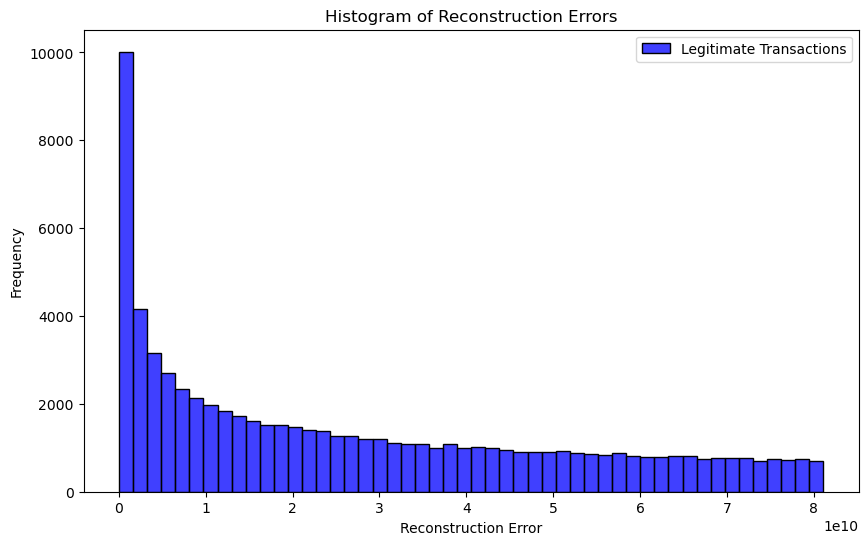

Threshold for Classification: 7510900.632889999


In [142]:
import matplotlib.pyplot as plt
import seaborn as sns


legit_errors = results_df[results_df['True Labels'] == 0]['Reconstruction Errors']
fraud_errors = results_df[results_df['True Labels'] == 1]['Reconstruction Errors']

# Plot histograms
plt.figure(figsize=(10, 6))
sns.histplot(legit_errors, bins=50, color='blue', kde=False, label='Legitimate Transactions')
sns.histplot(fraud_errors, bins=50, color='red', kde=False, label='Fraudulent Transactions')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


threshold = legit_errors.quantile(0.01)

print("Threshold for Classification:", threshold)


13. Compute the confusion_matrix (sklearn.metrics.confusion_matrix) and explain what the numbers in the confusion matrix mean

In [143]:
from sklearn.metrics import confusion_matrix

#assuming 'results_df' contains df with reconstruction errors and true labels and 'threshold' is the threshold determined in the previous step

predicted_labels = (results_df['Reconstruction Errors'] >= threshold).astype(int)

conf_matrix = confusion_matrix(results_df['True Labels'], predicted_labels)


print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import precision_score, recall_score, f1_score


precision = precision_score(results_df['True Labels'], predicted_labels)
recall = recall_score(results_df['True Labels'], predicted_labels)
f1 = f1_score(results_df['True Labels'], predicted_labels)


print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Confusion Matrix:
[[  711 70368]
 [    0     0]]
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/Users/moush/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The numbers in the confusion matrix have the following meanings:

True Negative (TN): Legitimate transactions correctly identified as legitimate.

False Positive (FP): Legitimate transactions incorrectly identified as fraudulent (Type I error).

False Negative (FN): Fraudulent transactions incorrectly identified as legitimate (Type II error).

True Positive (TP): Fraudulent transactions correctly identified as fraudulent.

14. Try different threshold values and see how the confusion matrix changes

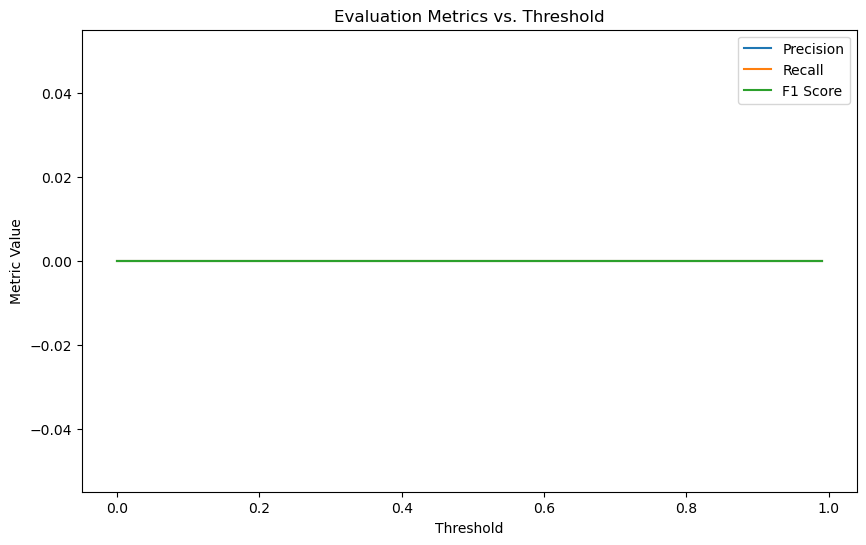

In [144]:
from sklearn.metrics import confusion_matrix

threshold_values = np.arange(0, 1, 0.01)


precision_list = []
recall_list = []
f1_score_list = []


for threshold in threshold_values:
    
    predicted_labels = (results_df['Reconstruction Errors'] >= threshold).astype(int)
    conf_matrix = confusion_matrix(results_df['True Labels'], predicted_labels)
    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1]) if conf_matrix[0, 1] + conf_matrix[1, 1] > 0 else 0
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]) if conf_matrix[1, 1] + conf_matrix[1, 0] > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)


plt.figure(figsize=(10, 6))
plt.plot(threshold_values, precision_list, label='Precision')
plt.plot(threshold_values, recall_list, label='Recall')
plt.plot(threshold_values, f1_score_list, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics vs. Threshold')
plt.legend()
plt.show()
